## Qualitative evaluation

### Imports

In [2]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse
from evaluation.evaluate import evaluate
from evaluation.metrics import MyMetrics

/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model and dev set

In [3]:
# run_name = 'Final_MMULA'
run_name = 'Enhancing_MMULA_length_indep_1'

In [4]:
# device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")
print(device)

### for debugging use cpu
# device = cpu

config = {
    #    "run_name": "Run_test_TLWAN"
    "run_name": run_name,
    "project_path": "/vol/bitbucket/mh1022/temporal-modelling-icd",
}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "r") as f:
    config = json.load(f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)
notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])

# Get training / validation / test
dataset_config = {
    "max_chunks": config["max_chunks"],
    "setup": config["setup"],
    "limit_ds": config["limit_ds"],
}

val_set = get_dataset(notes_agg_df, "VALIDATION", tokenizer=tokenizer, **dataset_config)
val_generator = get_dataloader(val_set)

# only to run on CPU
os.environ["TOKENIZERS_PARALLELISM"] = "false"

config["num_categories"] = len(categories_mapping)
model = Model(config, device=device)


# load best model
checkpoint = torch.load(
    os.path.join(
        config["project_path"], f"results/BEST_{config['run_name']}.pth"
    )
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at RoBERTa-base-PM-M3-Voc-hf were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50008, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

### Qualitative evaluation functions

In [5]:
data = val_set[0]

In [6]:
labels = data["label"][: model.num_labels]
input_ids = data["input_ids"]
attention_mask = data["attention_mask"]
seq_ids = data["seq_ids"]
category_ids = data["category_ids"]
avail_docs = seq_ids.max().item() + 1
# note_end_chunk_ids = data["note_end_chunk_ids"]
cutoffs = data["cutoffs"]

complete_sequence_output = []
# run through data in chunks of max_chunks
for i in range(0, input_ids.shape[0], 4):
    # only get the document embeddings
    sequence_output = model(
        input_ids=input_ids[i : i + model.max_chunks].to(
            device, dtype=torch.long
        ),
        attention_mask=attention_mask[i : i + model.max_chunks].to(
            device, dtype=torch.long
        ),
        seq_ids=seq_ids[i : i + model.max_chunks].to(
            device, dtype=torch.long
        ),
        category_ids=category_ids[i : i + model.max_chunks].to(
            device, dtype=torch.long
        ),
        cutoffs=None,
        is_evaluation=True,
        # note_end_chunk_ids=note_end_chunk_ids,
    )
    complete_sequence_output.append(sequence_output)
# concatenate the sequence output
sequence_output = torch.cat(complete_sequence_output, dim=0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 10.75 GiB total capacity; 5.66 GiB already allocated; 31.38 MiB free; 5.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def return_attn_scores(lwan, encoding, all_tokens=True, cutoffs=None):
    # encoding: Tensor of size (Nc x T) x H
    # mask: Tensor of size Nn x (Nc x T) x H
    # temporal_encoding = Nn x (N x T) x hidden_size
    T = lwan.seq_len
    if not lwan.all_tokens:
        T = 1  # only use the [CLS]-token representation
    Nc = int(encoding.shape[0] / T)
    H = lwan.hidden_size
    Nl = lwan.num_labels

    # label query: shape L, H
    # encoding: hape NcxT, H
    # query shape:  Nn, L, H
    # key shape: Nn, Nc*T, H
    # values shape: Nn, Nc*T, H
    # key padding mask: Nn, Nc*T (true if ignore)
    # output: N, L, H
    mask = torch.ones(size=(Nc, Nc * T), dtype=torch.bool).to(device=lwan.device)
    for i in range(Nc):
        mask[i, : (i + 1) * T] = False

    # only mask out at 2d, 5d, 13d and no DS to reduce computation
    # get list of cutoff indices from cutoffs dictionary

    attn_output, attn_output_weights = lwan.multiheadattn.forward(
        query=lwan.label_queries.repeat(mask.shape[0], 1, 1),
        key=encoding.repeat(mask.shape[0], 1, 1),
        value=encoding.repeat(mask.shape[0], 1, 1),
        key_padding_mask=mask,
        need_weights=True,
    )

    score = torch.sum(
        attn_output
        * lwan.label_weights.unsqueeze(0).view(
            1, lwan.num_labels, lwan.hidden_size
        ),
        dim=2,
    )
    return attn_output_weights, score


In [7]:
# run through LWAN to get the scores
attn_output_weights, scores = return_attn_scores(model.label_attn, sequence_output, cutoffs=cutoffs)

Cutoff 2d
Label 0


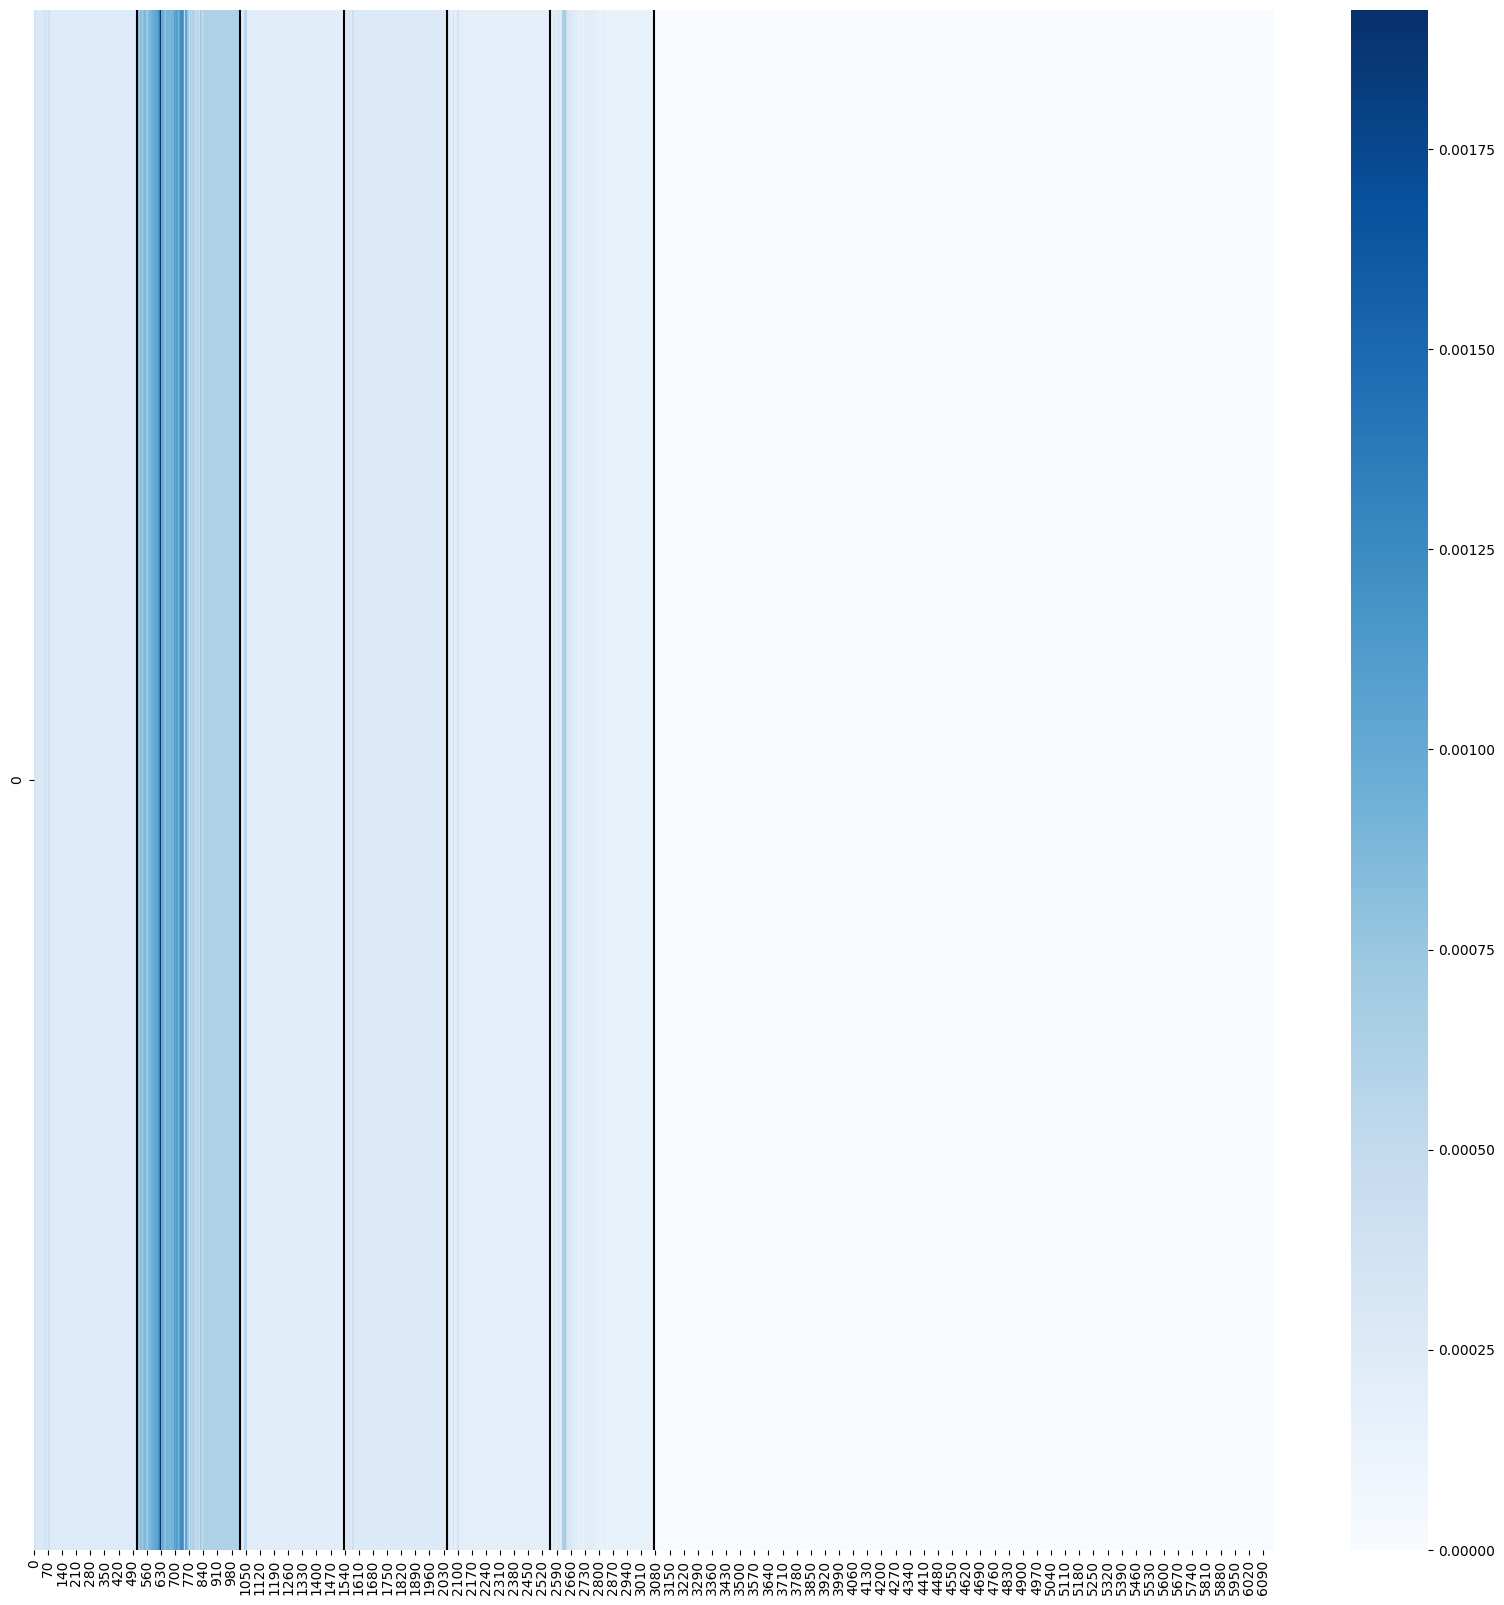

Label 5


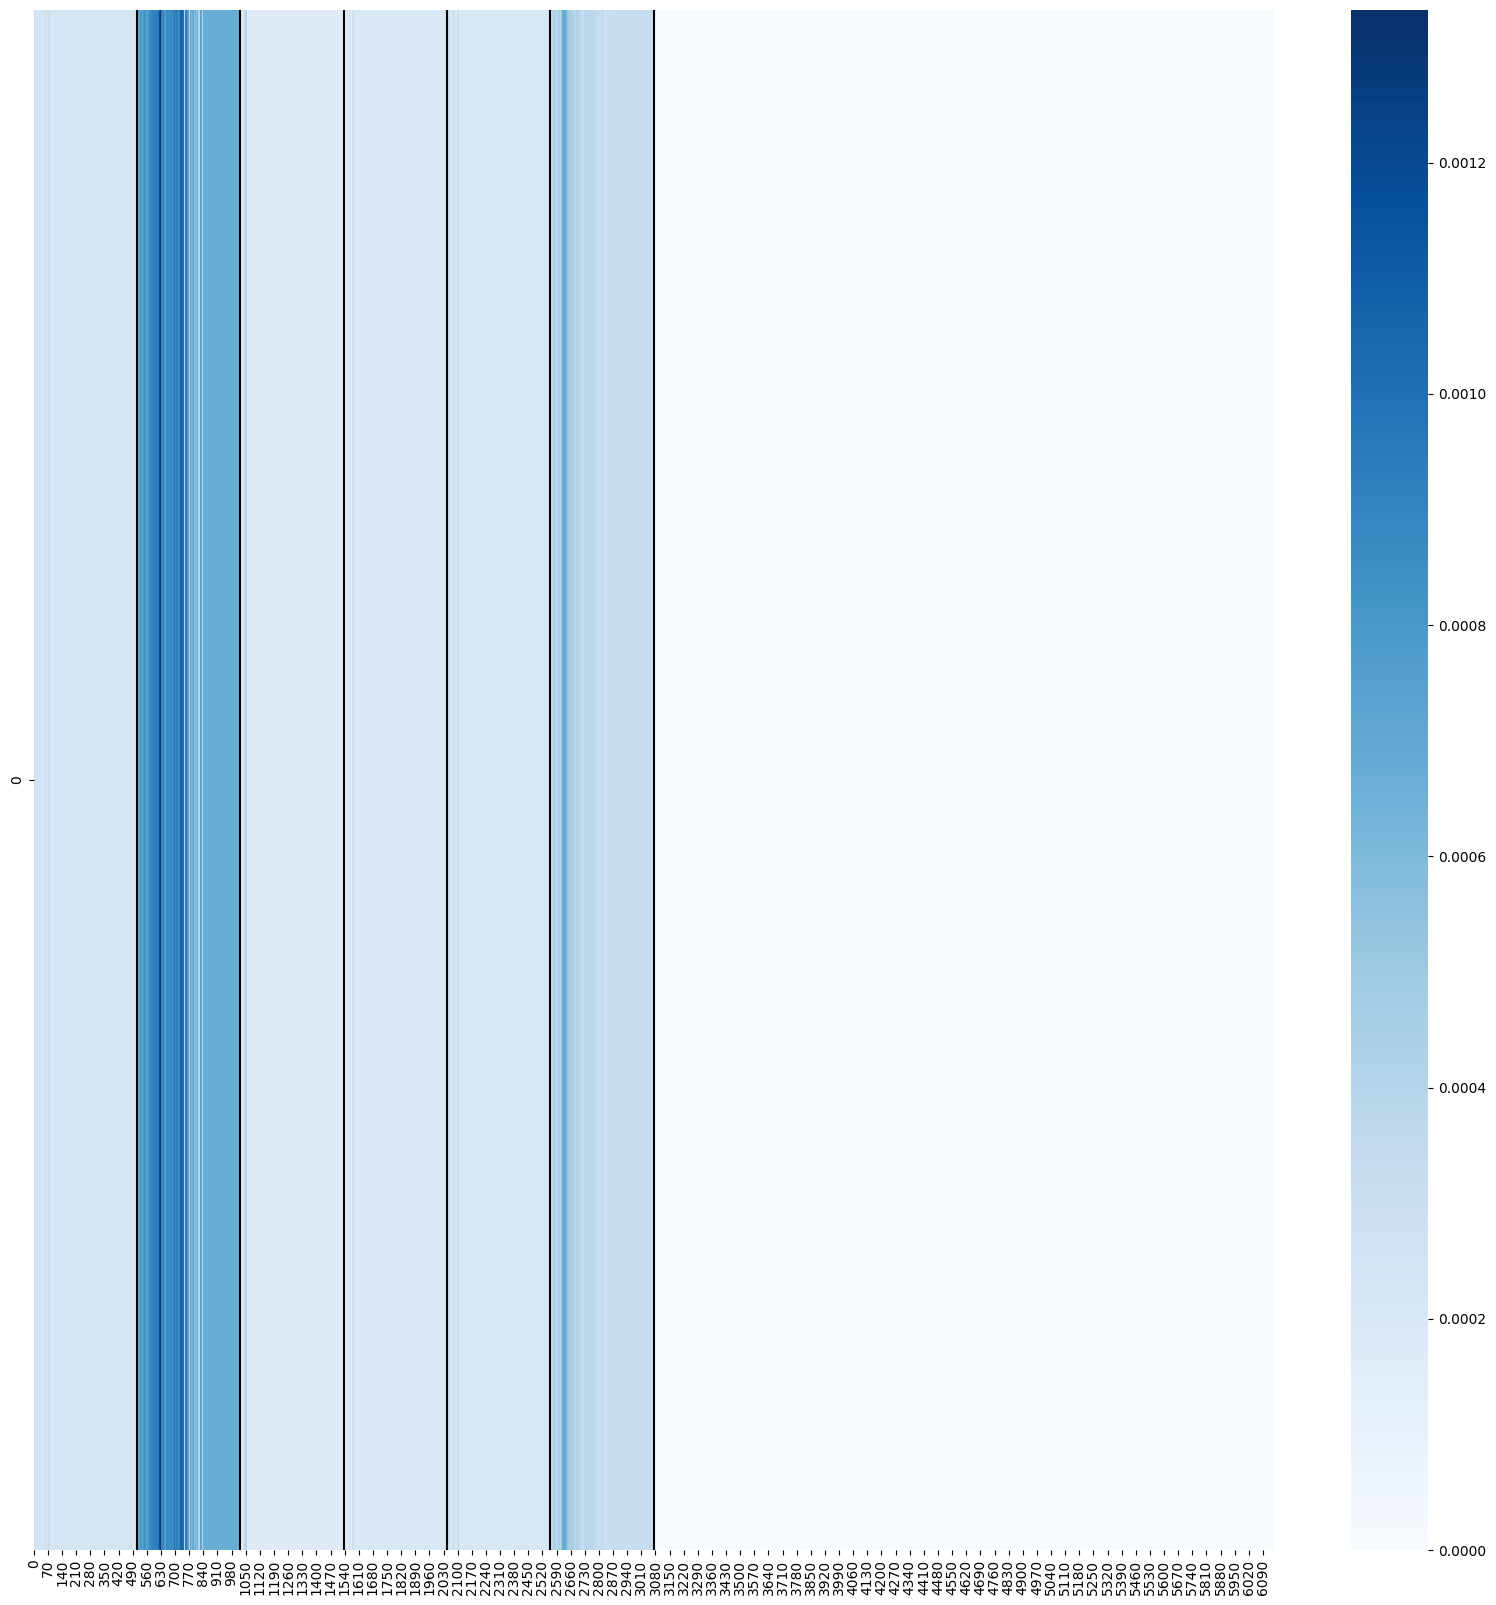

Label 20


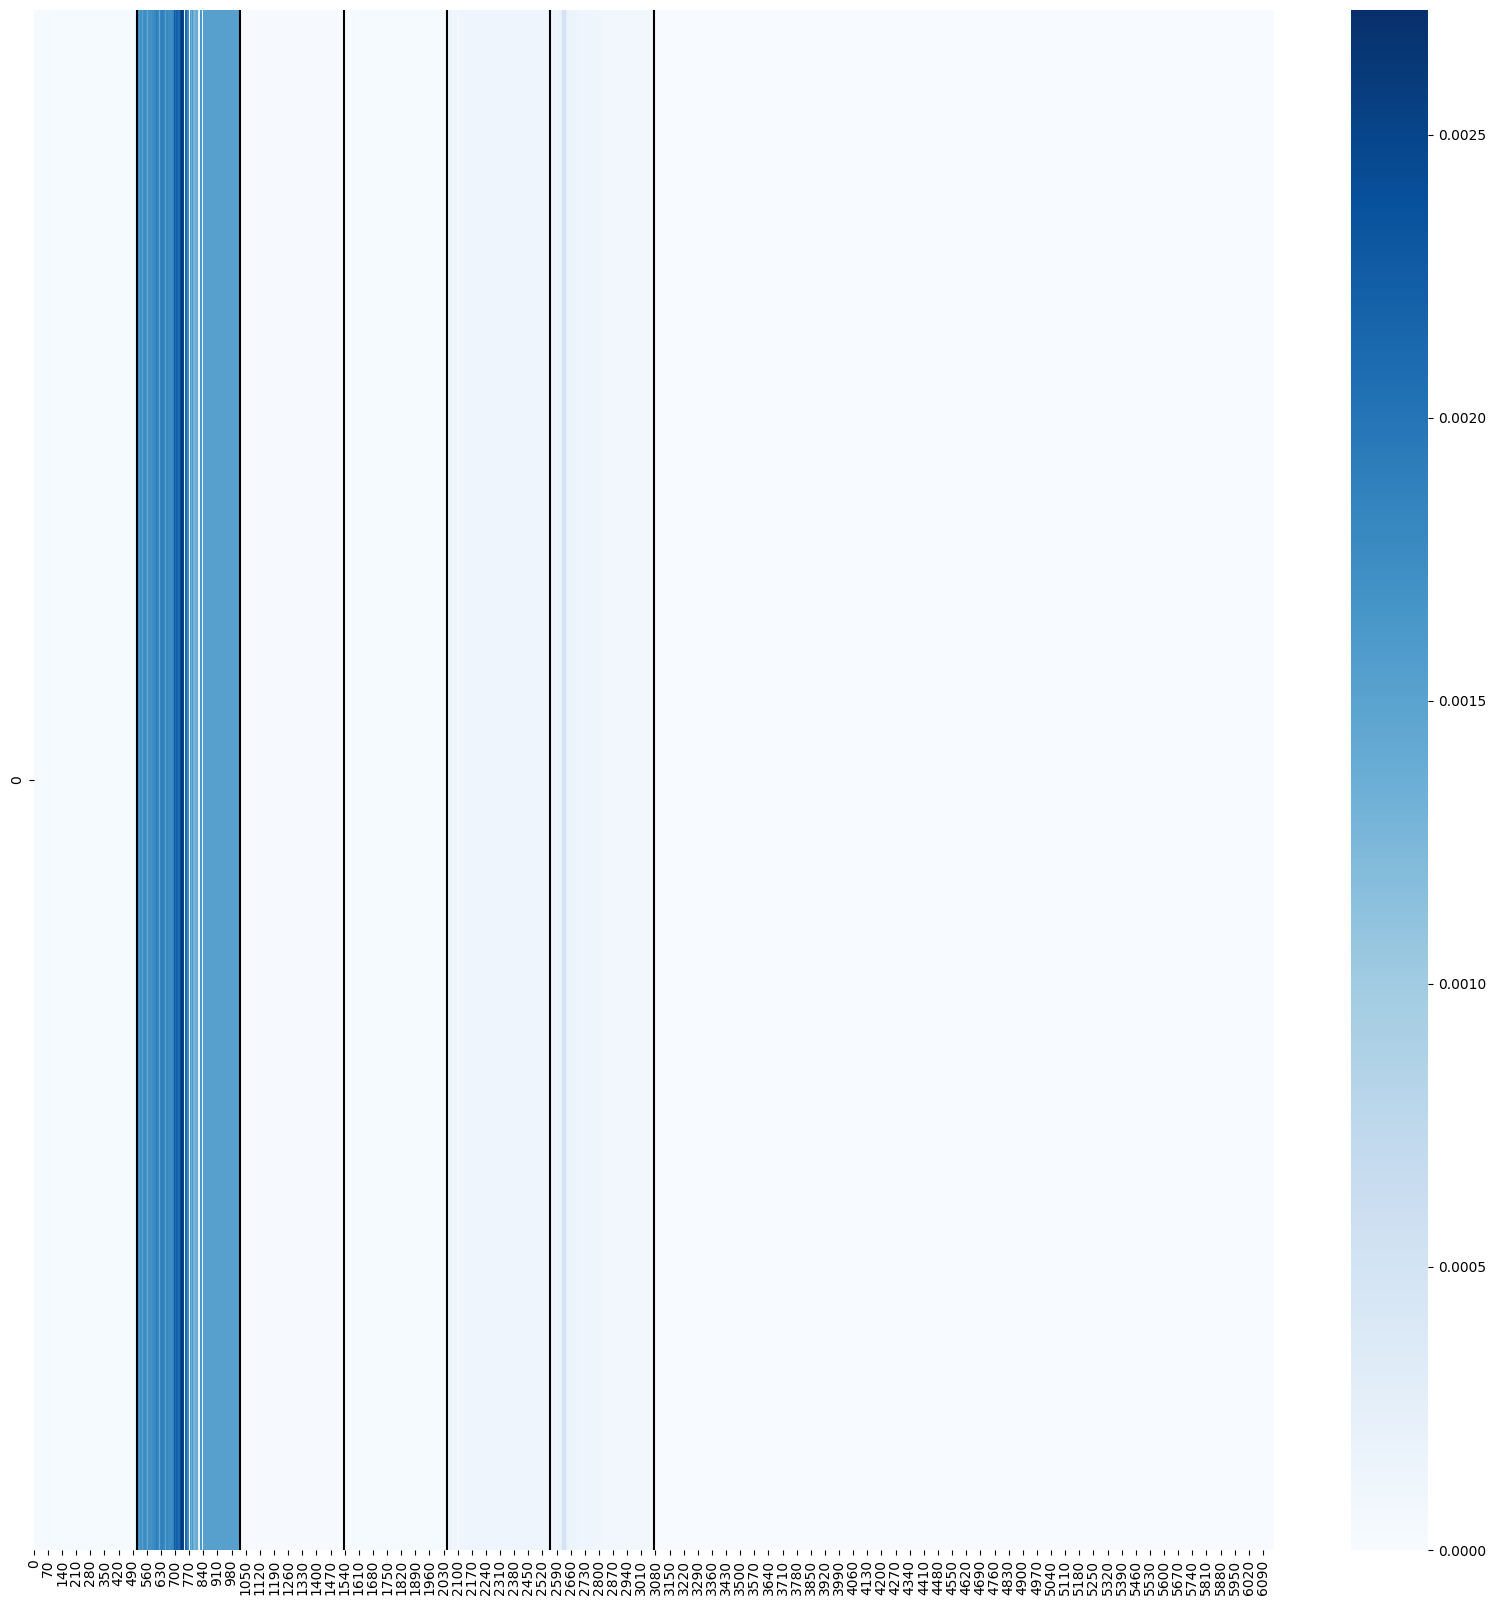

Label 21


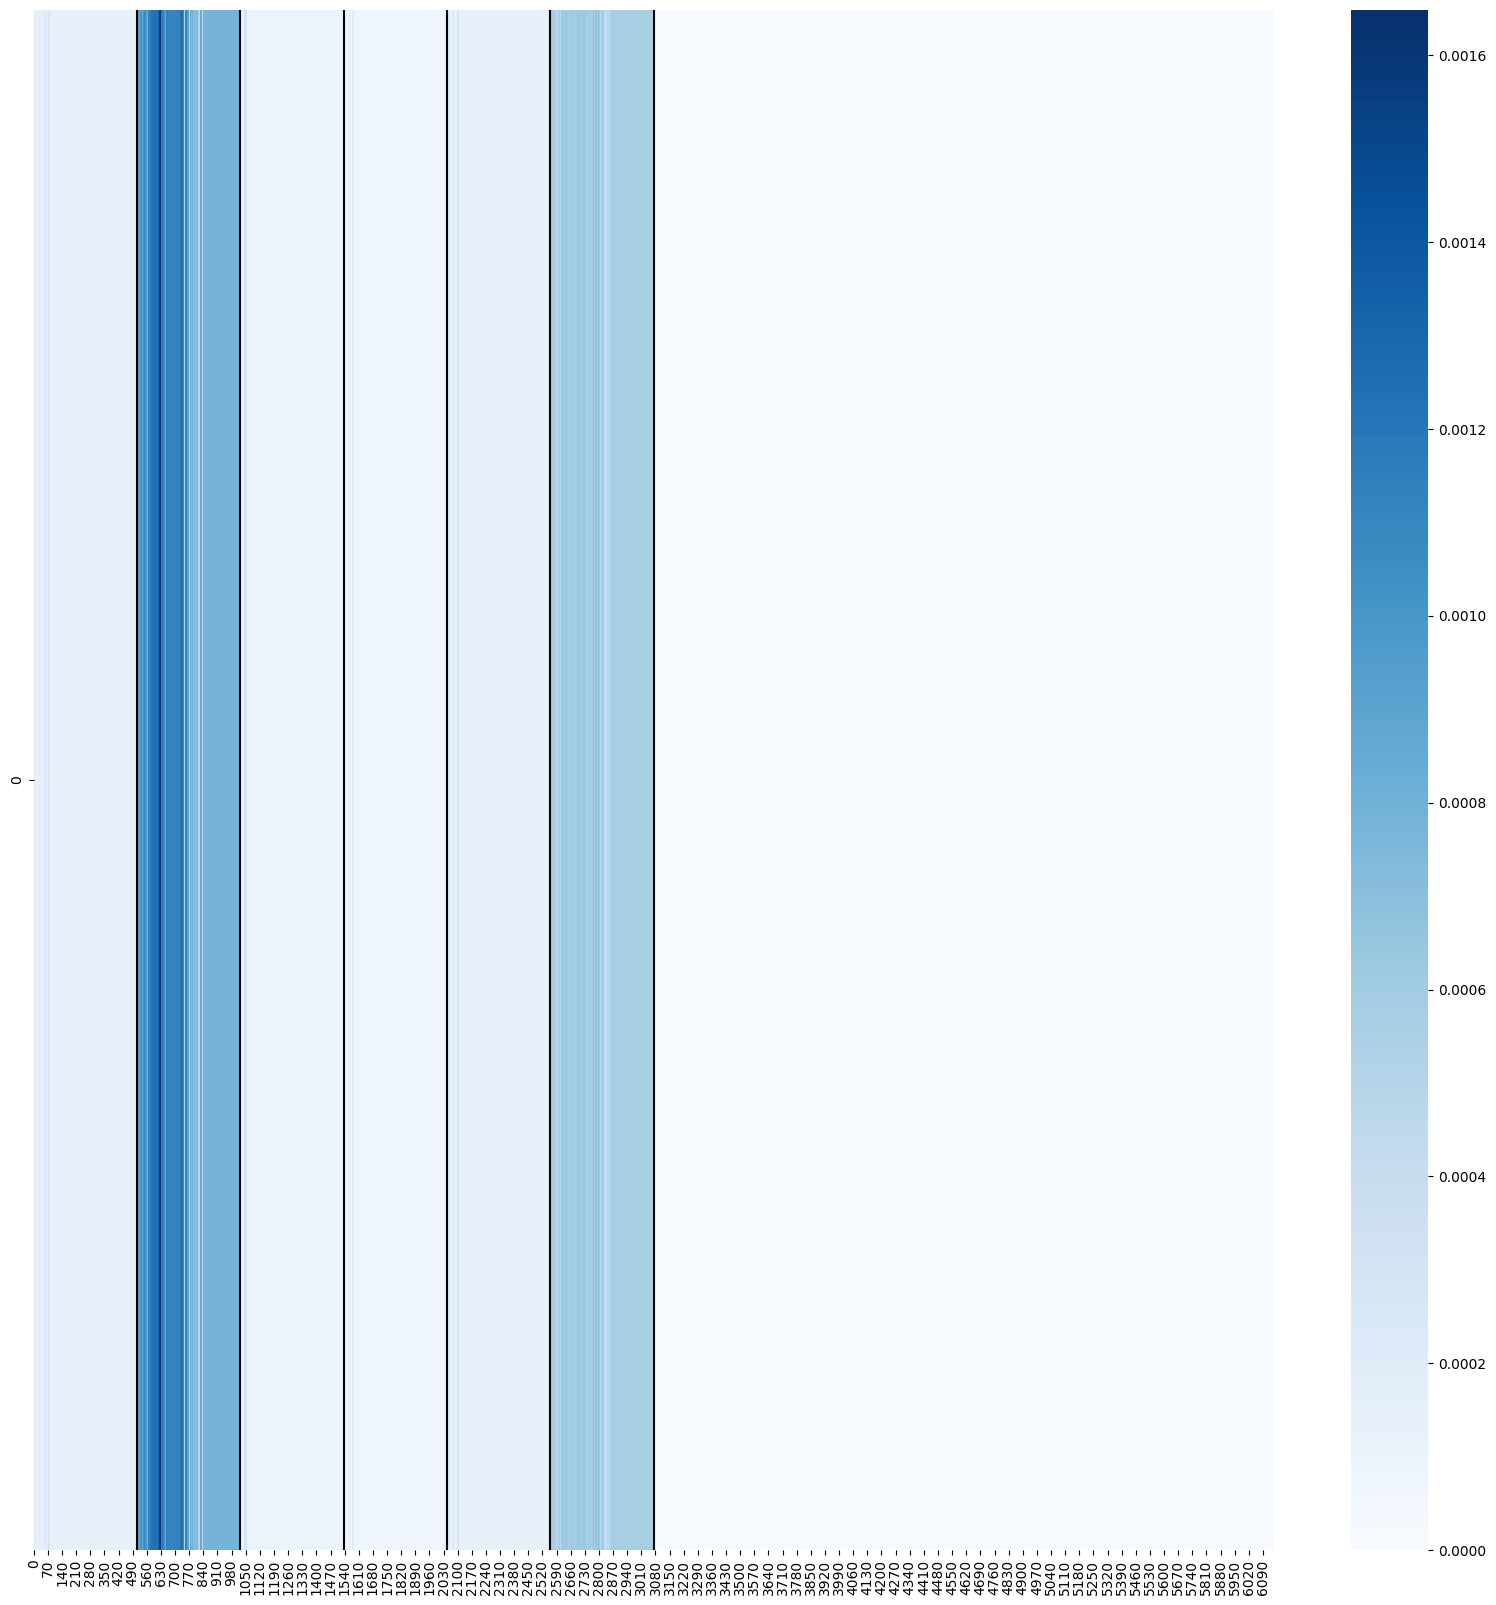

Label 43


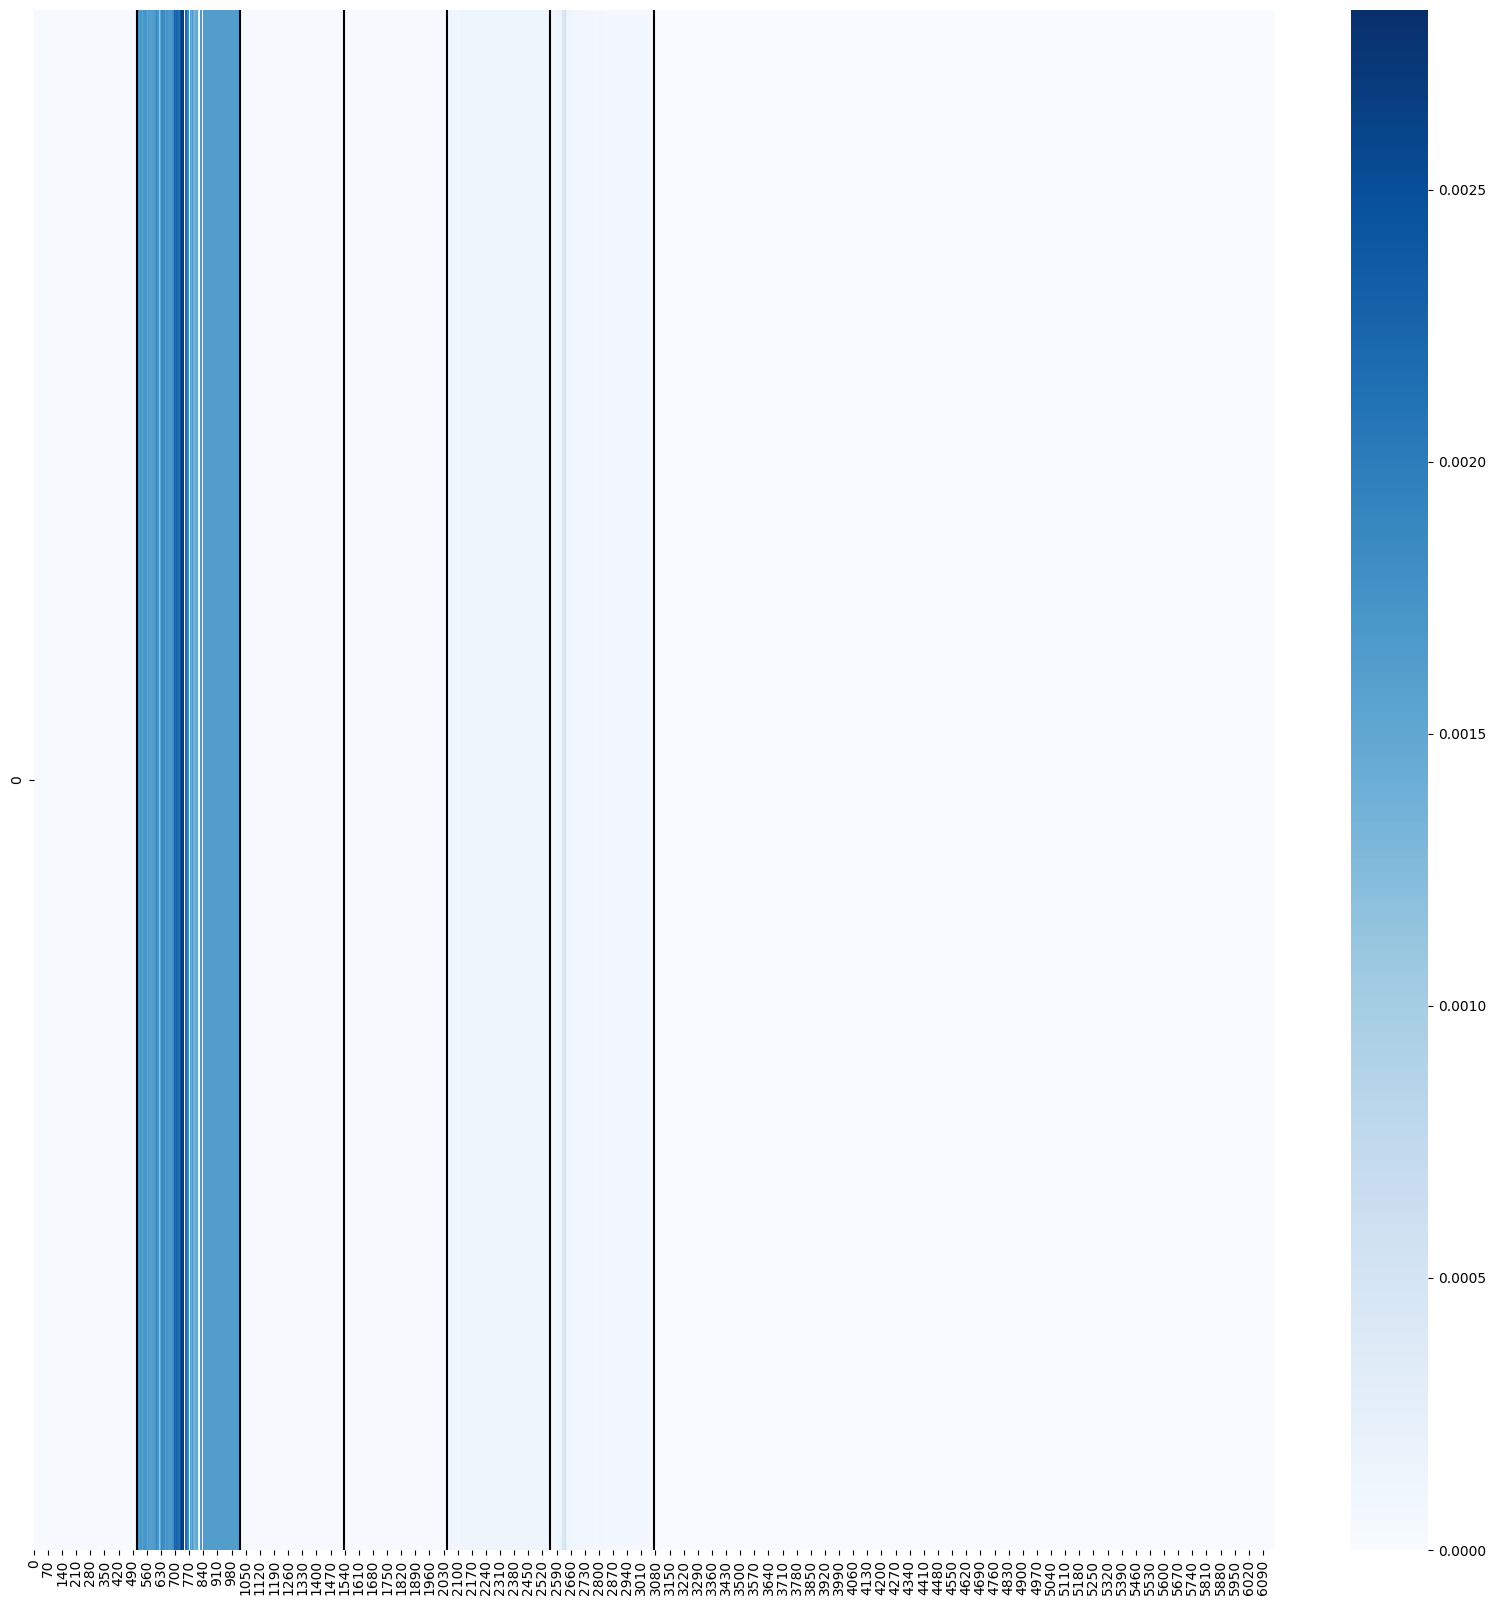

Label 45


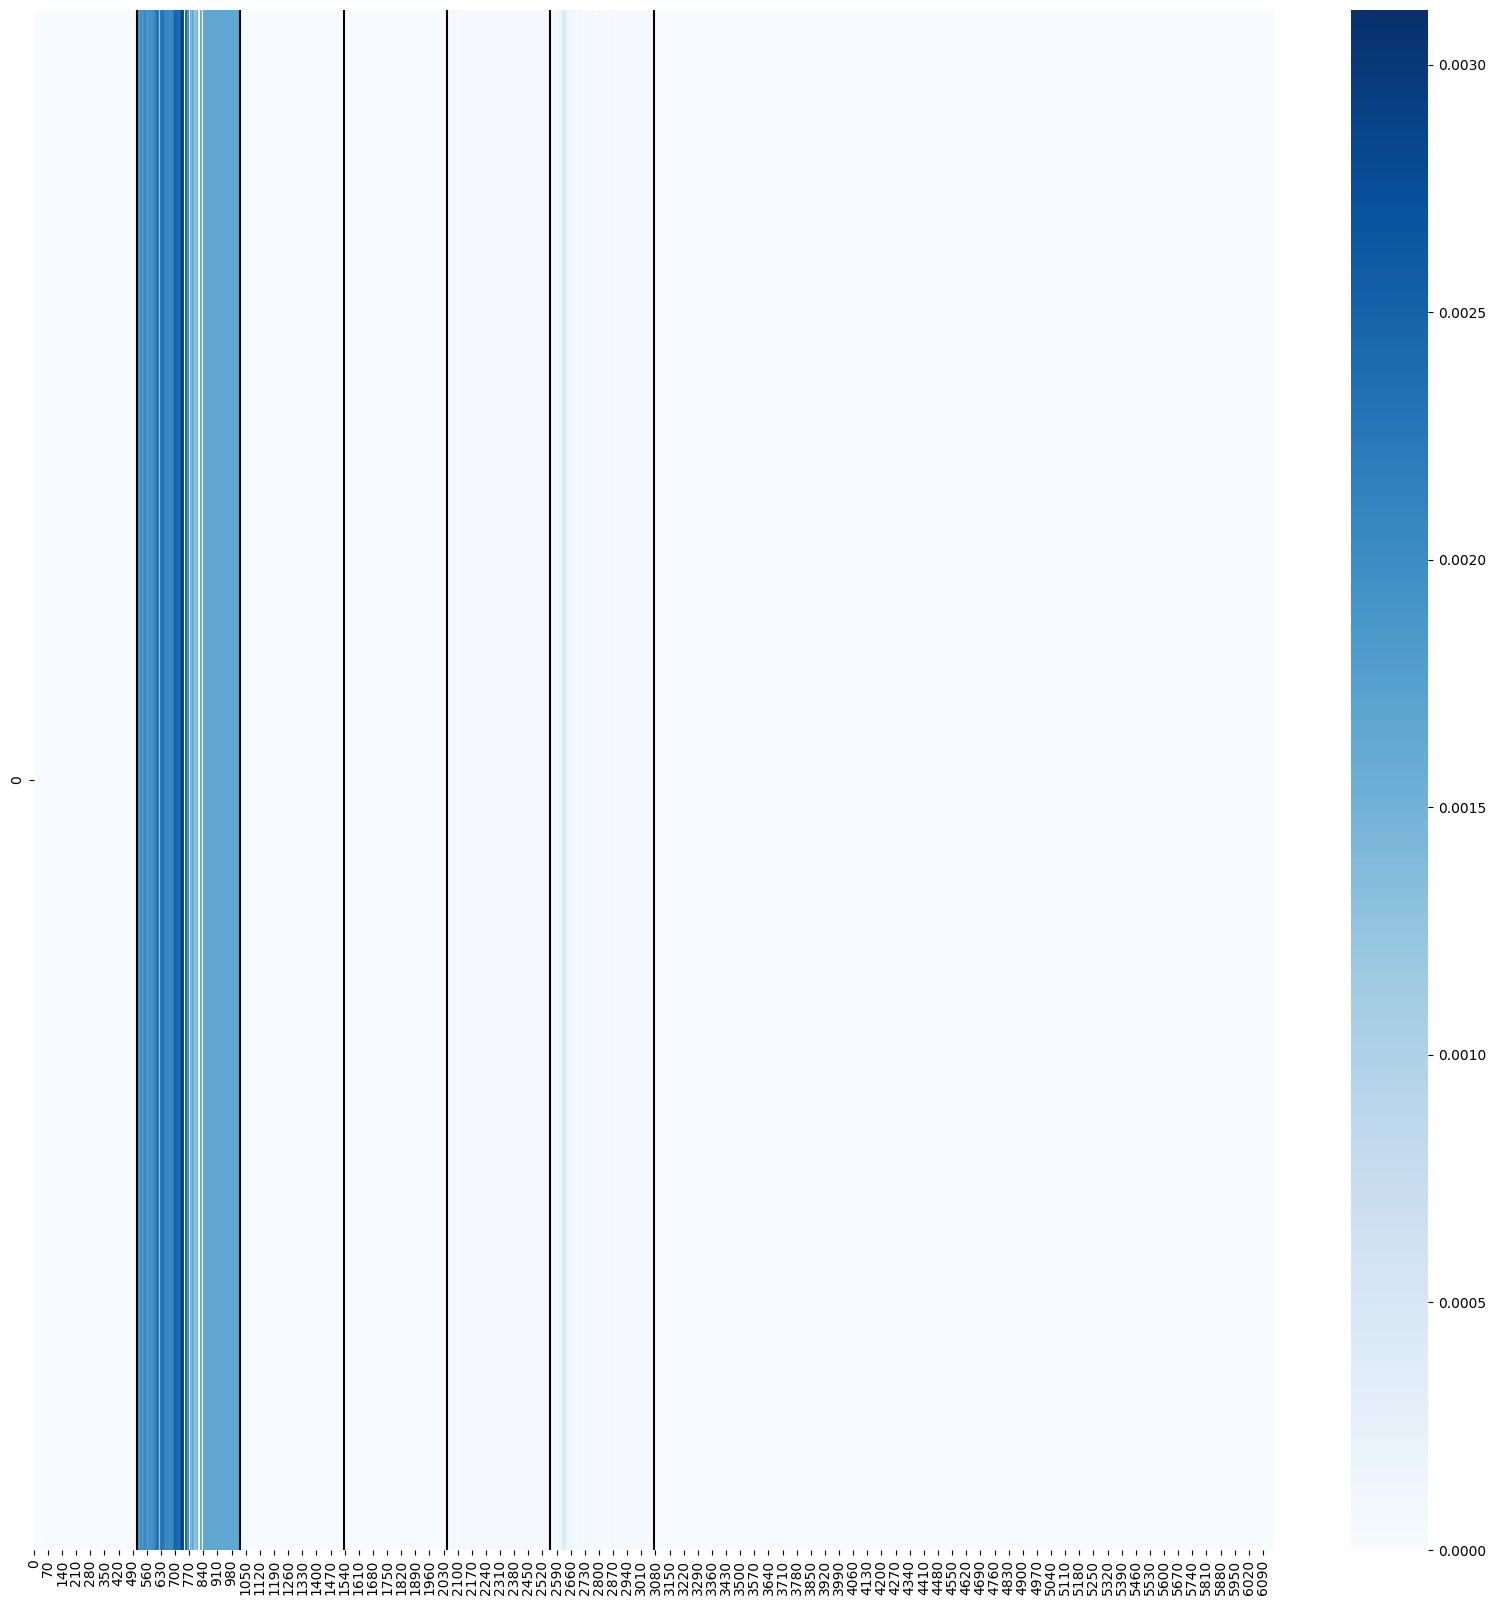

Cutoff 5d
Label 0


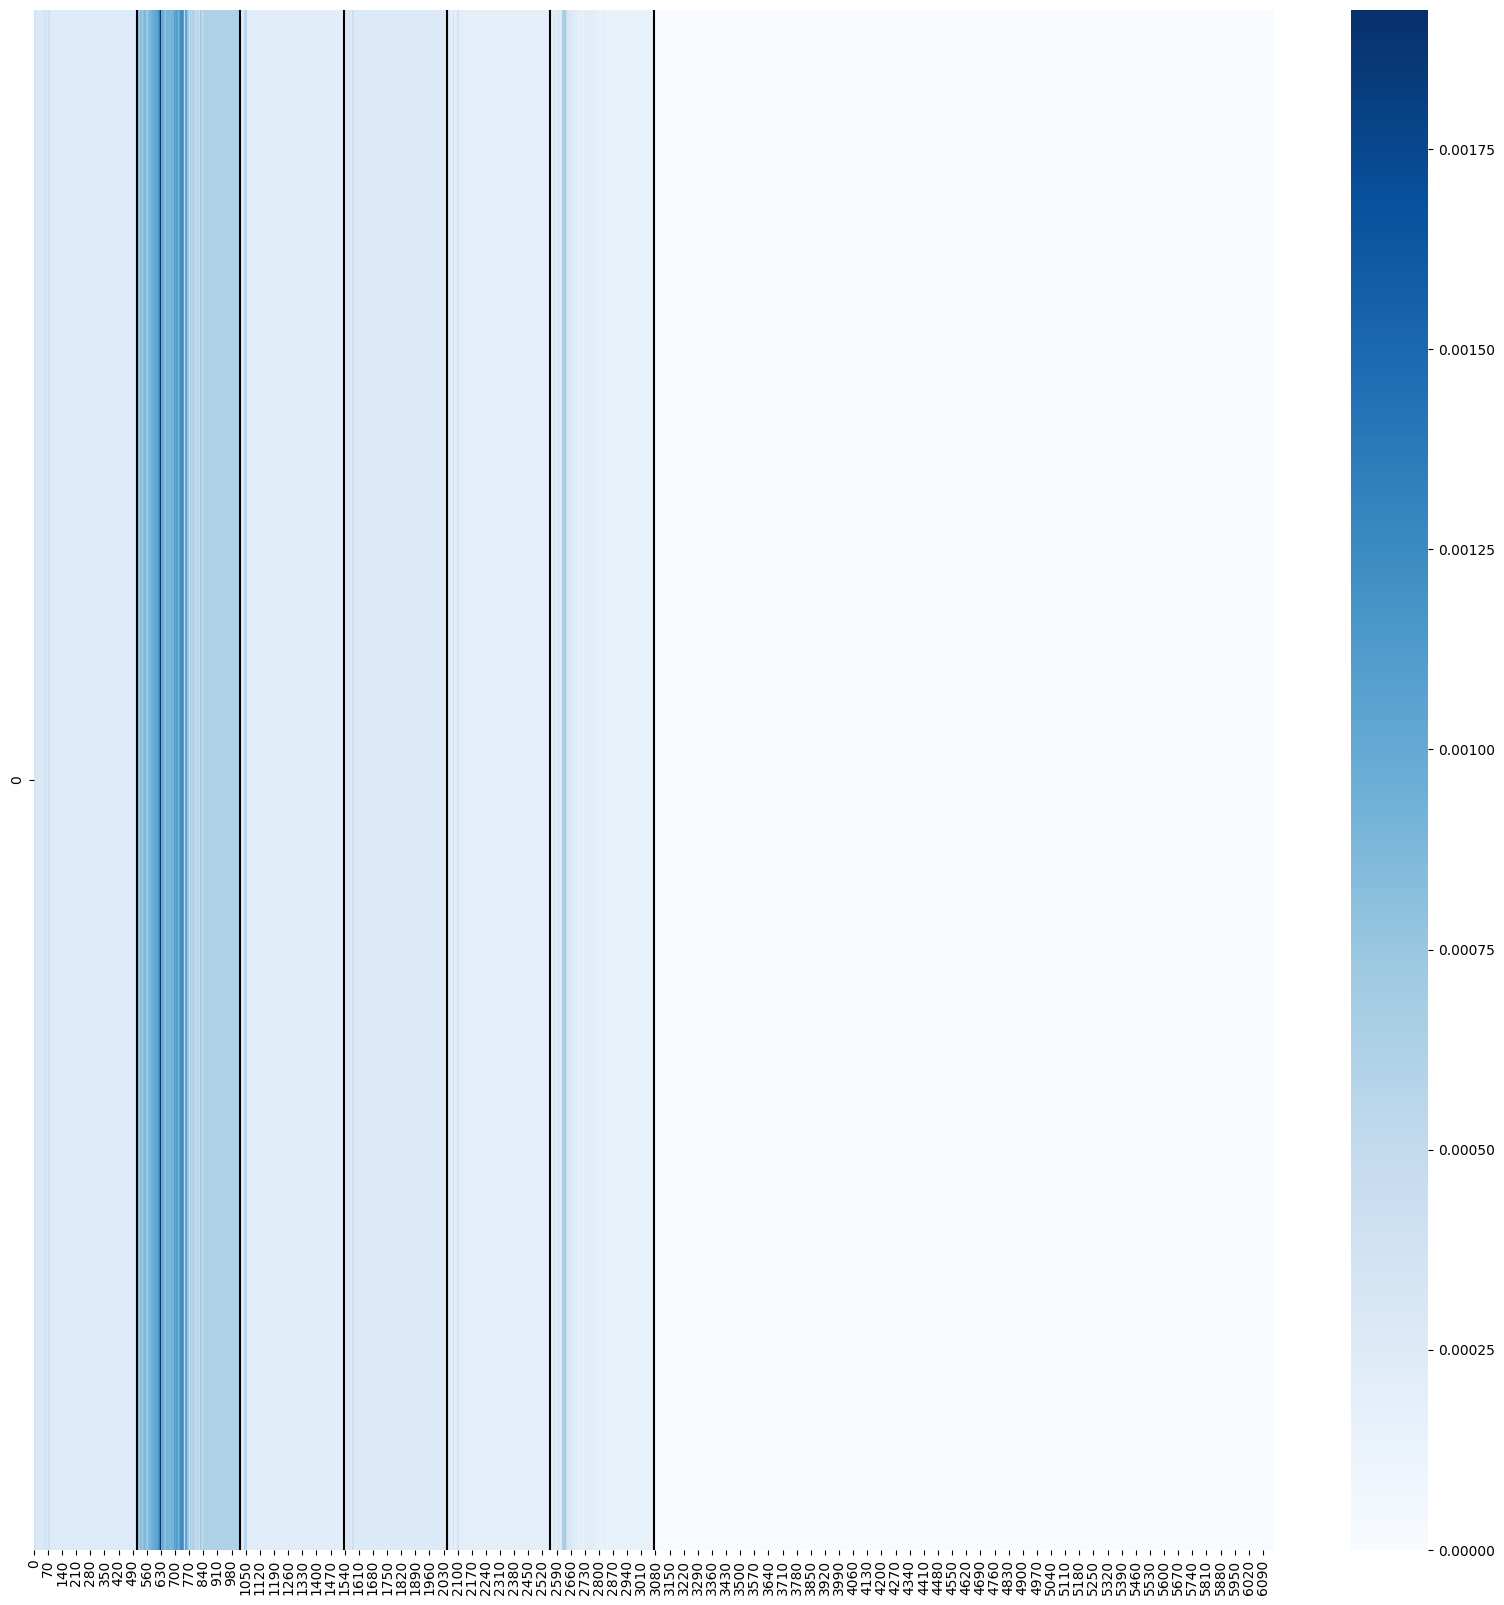

Label 5


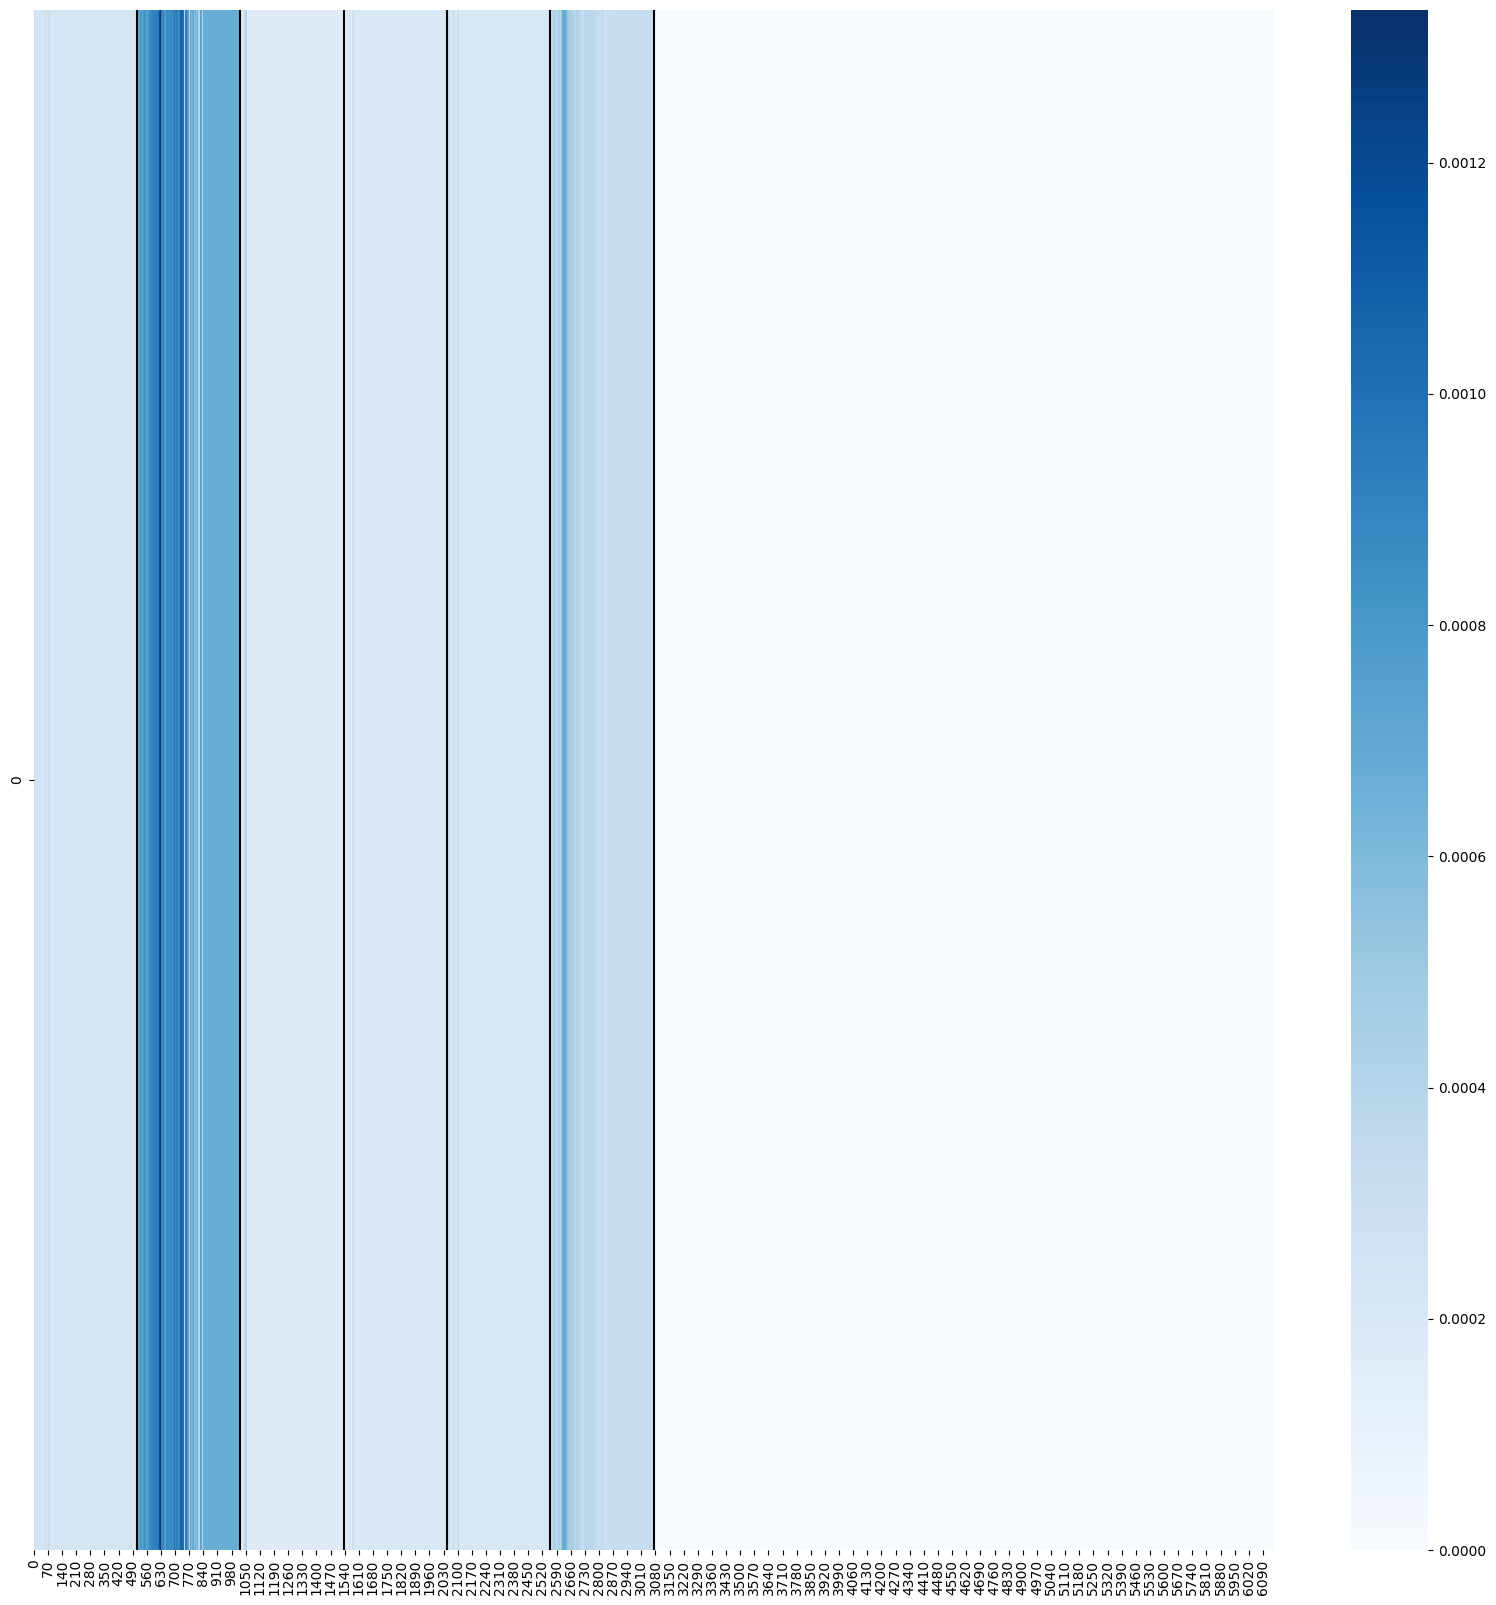

Label 20


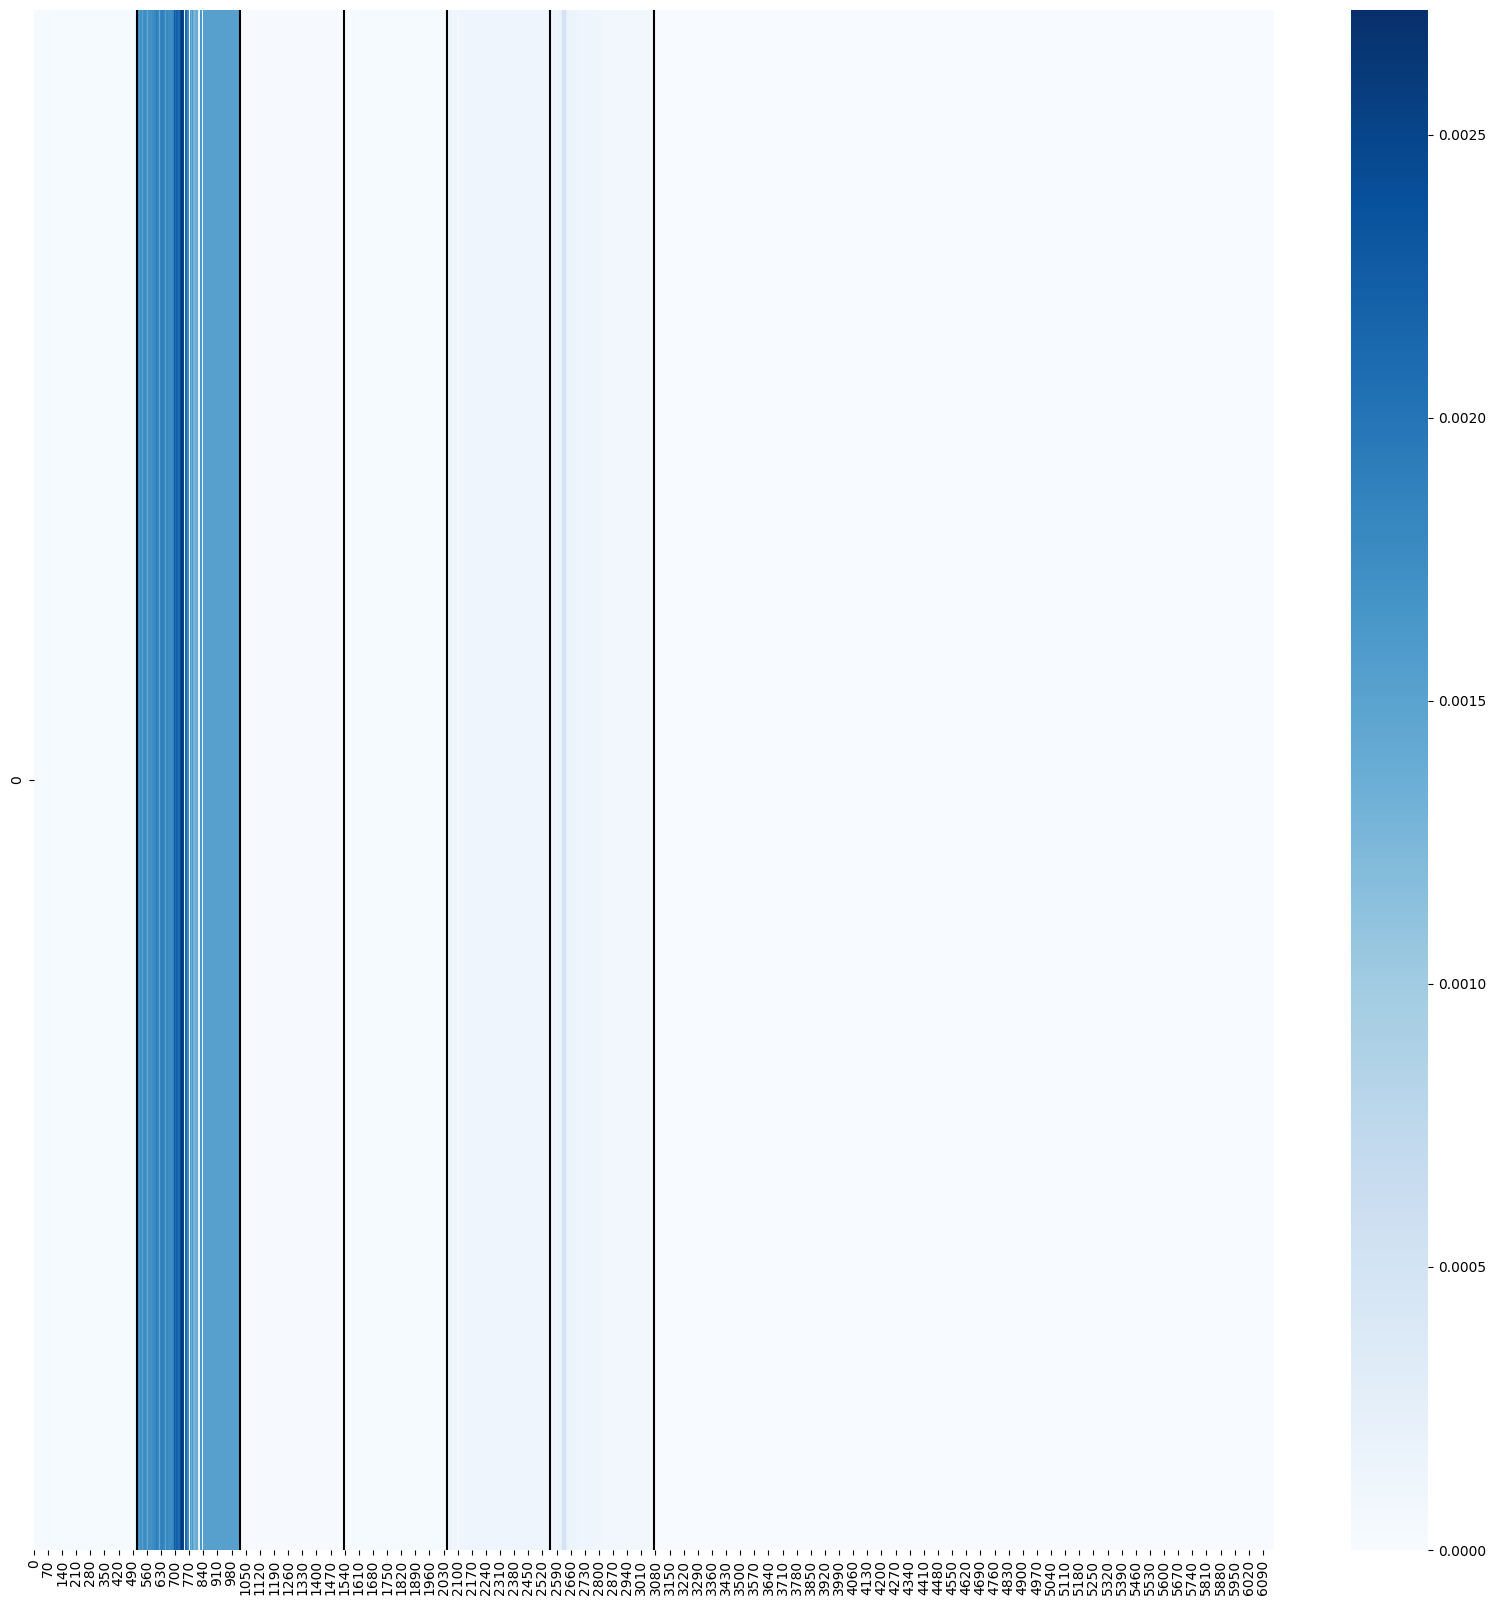

Label 21


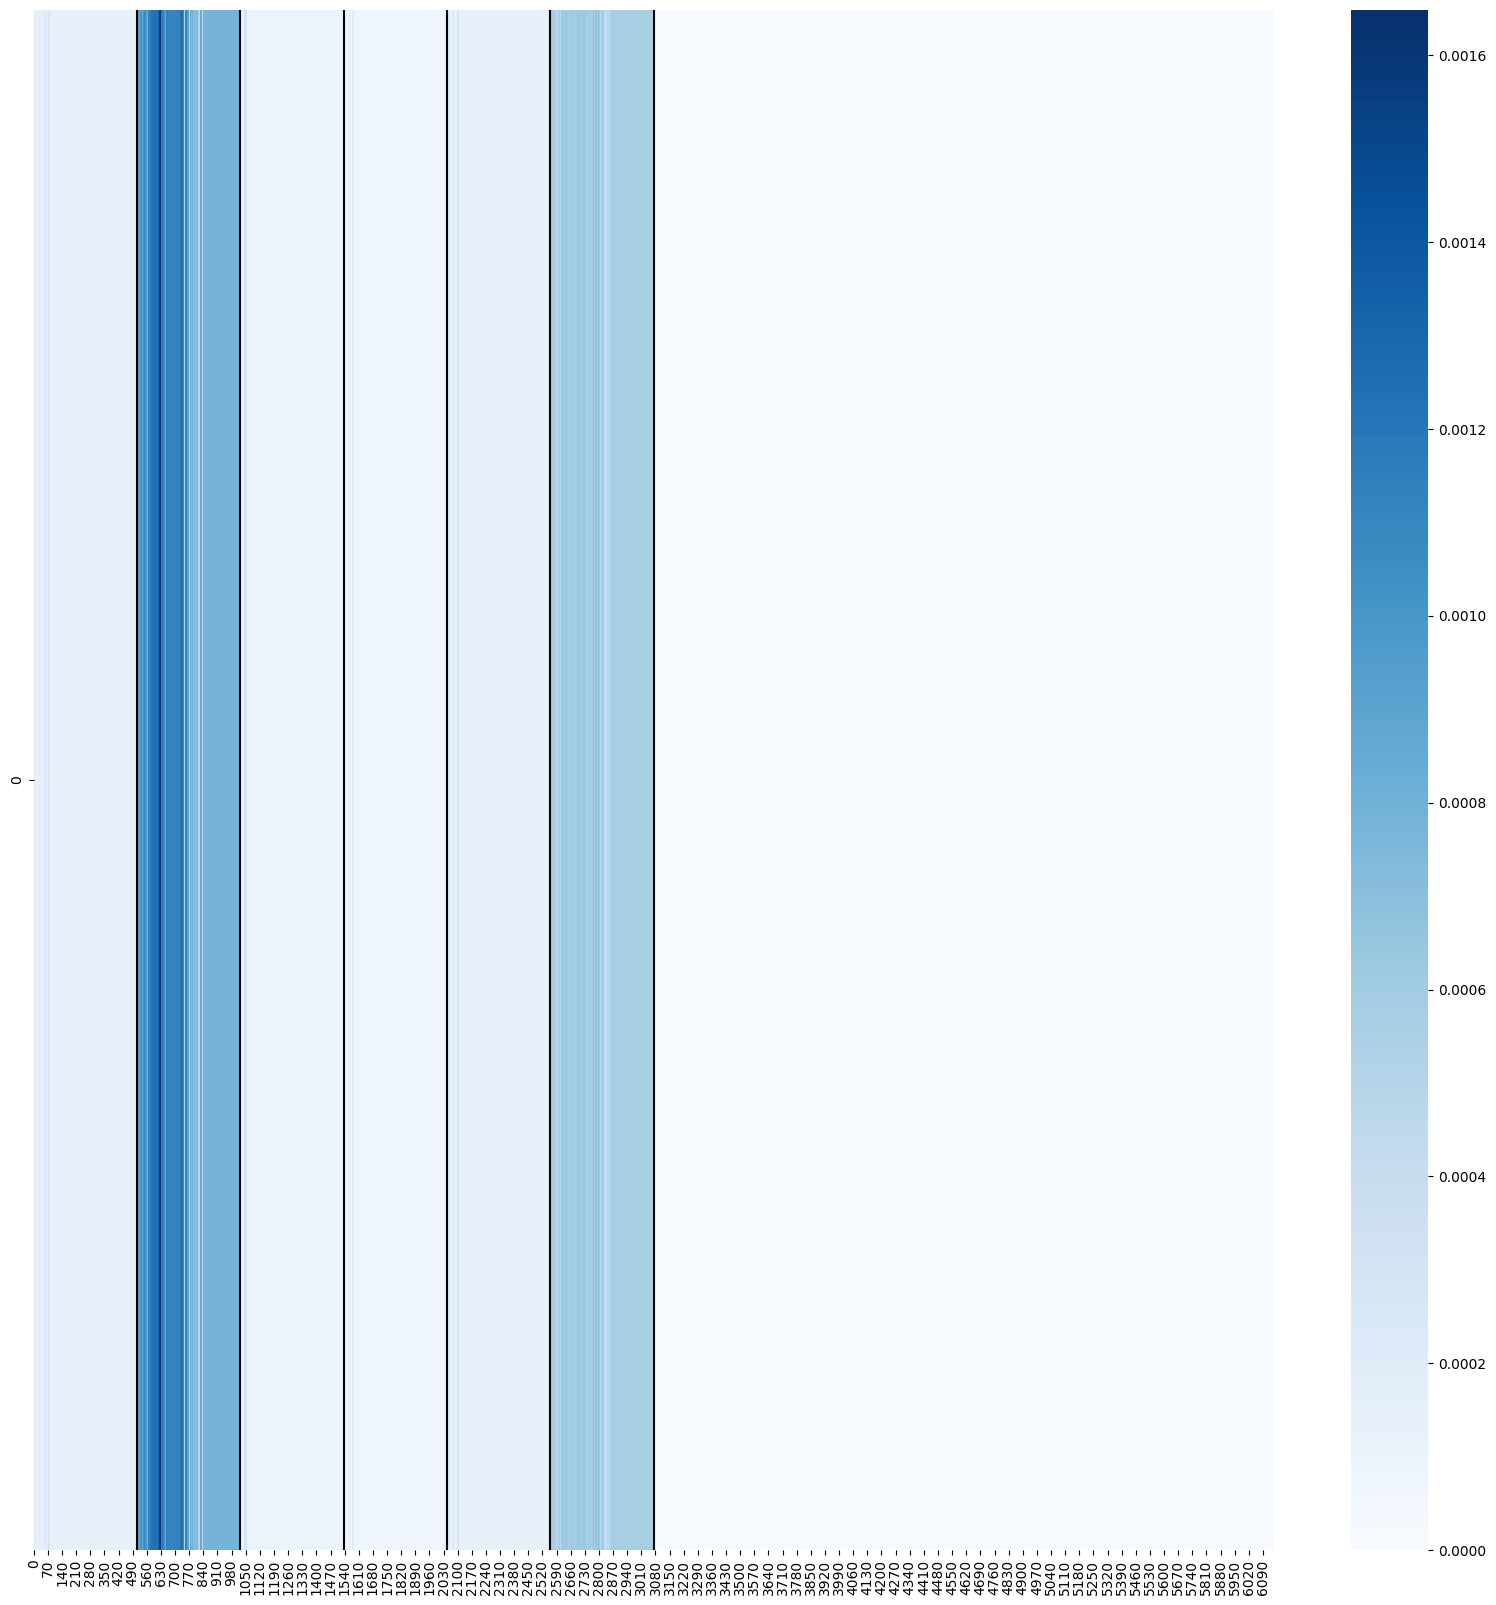

Label 43


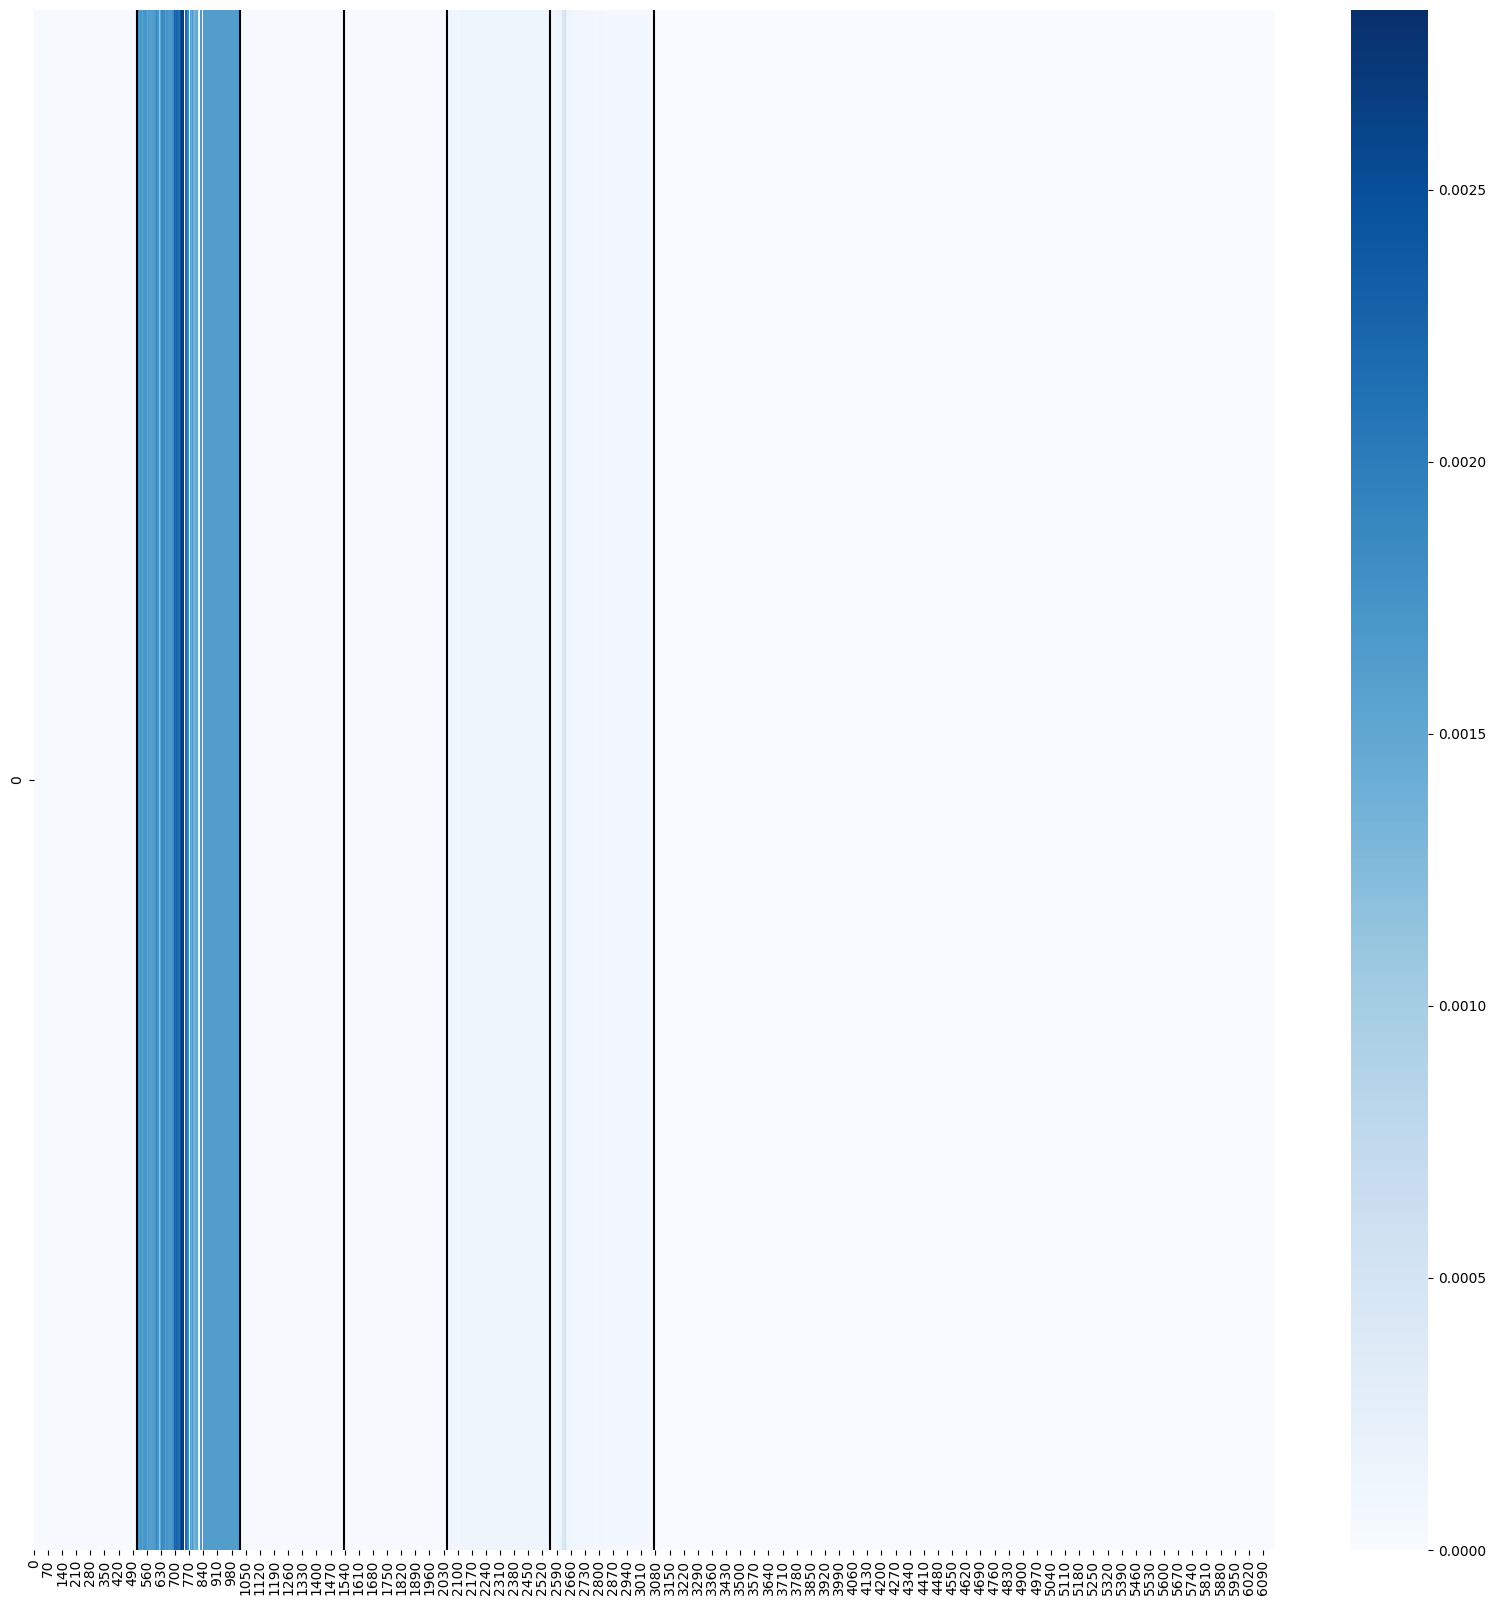

Label 45


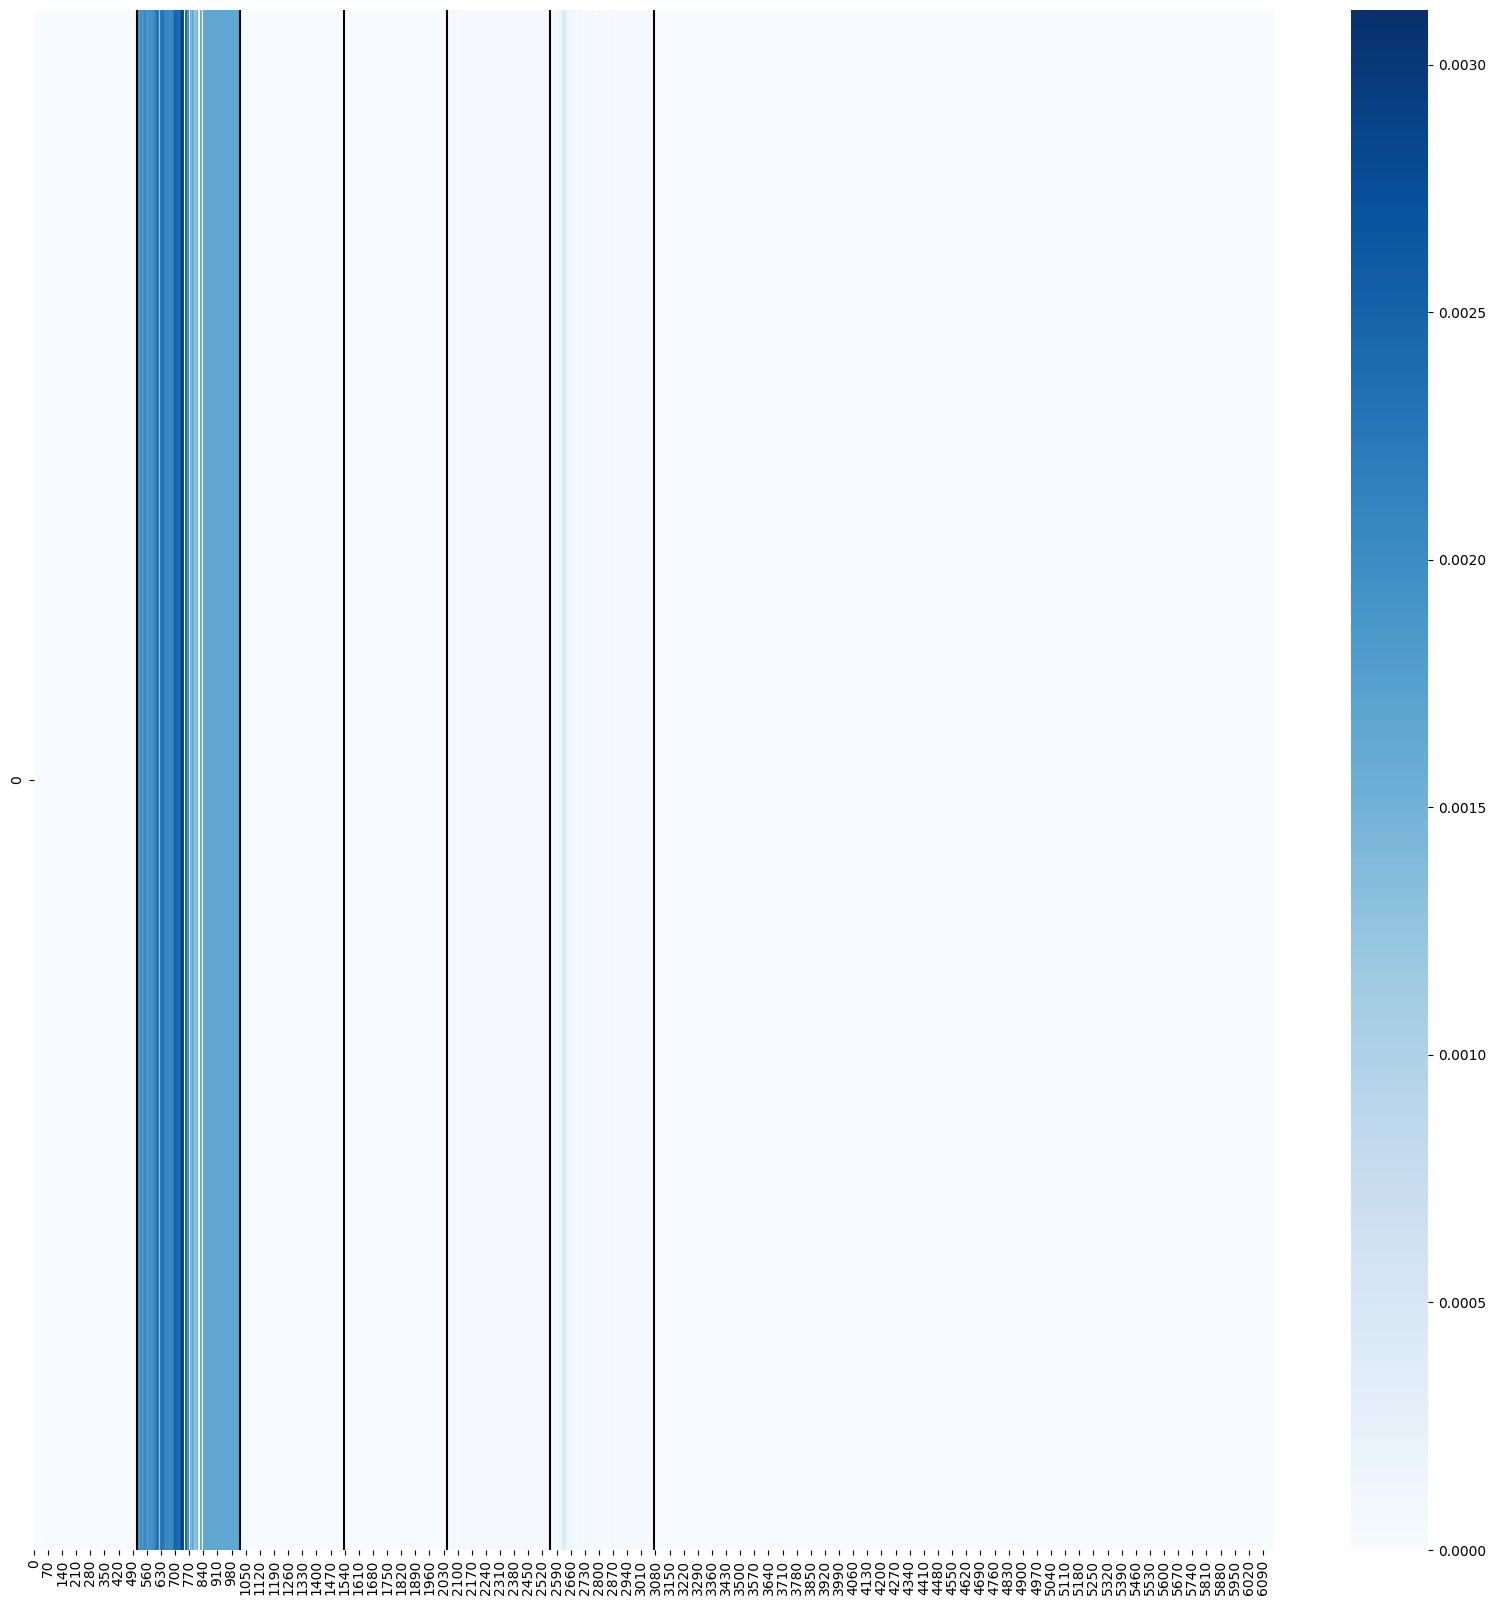

Cutoff 13d
Label 0


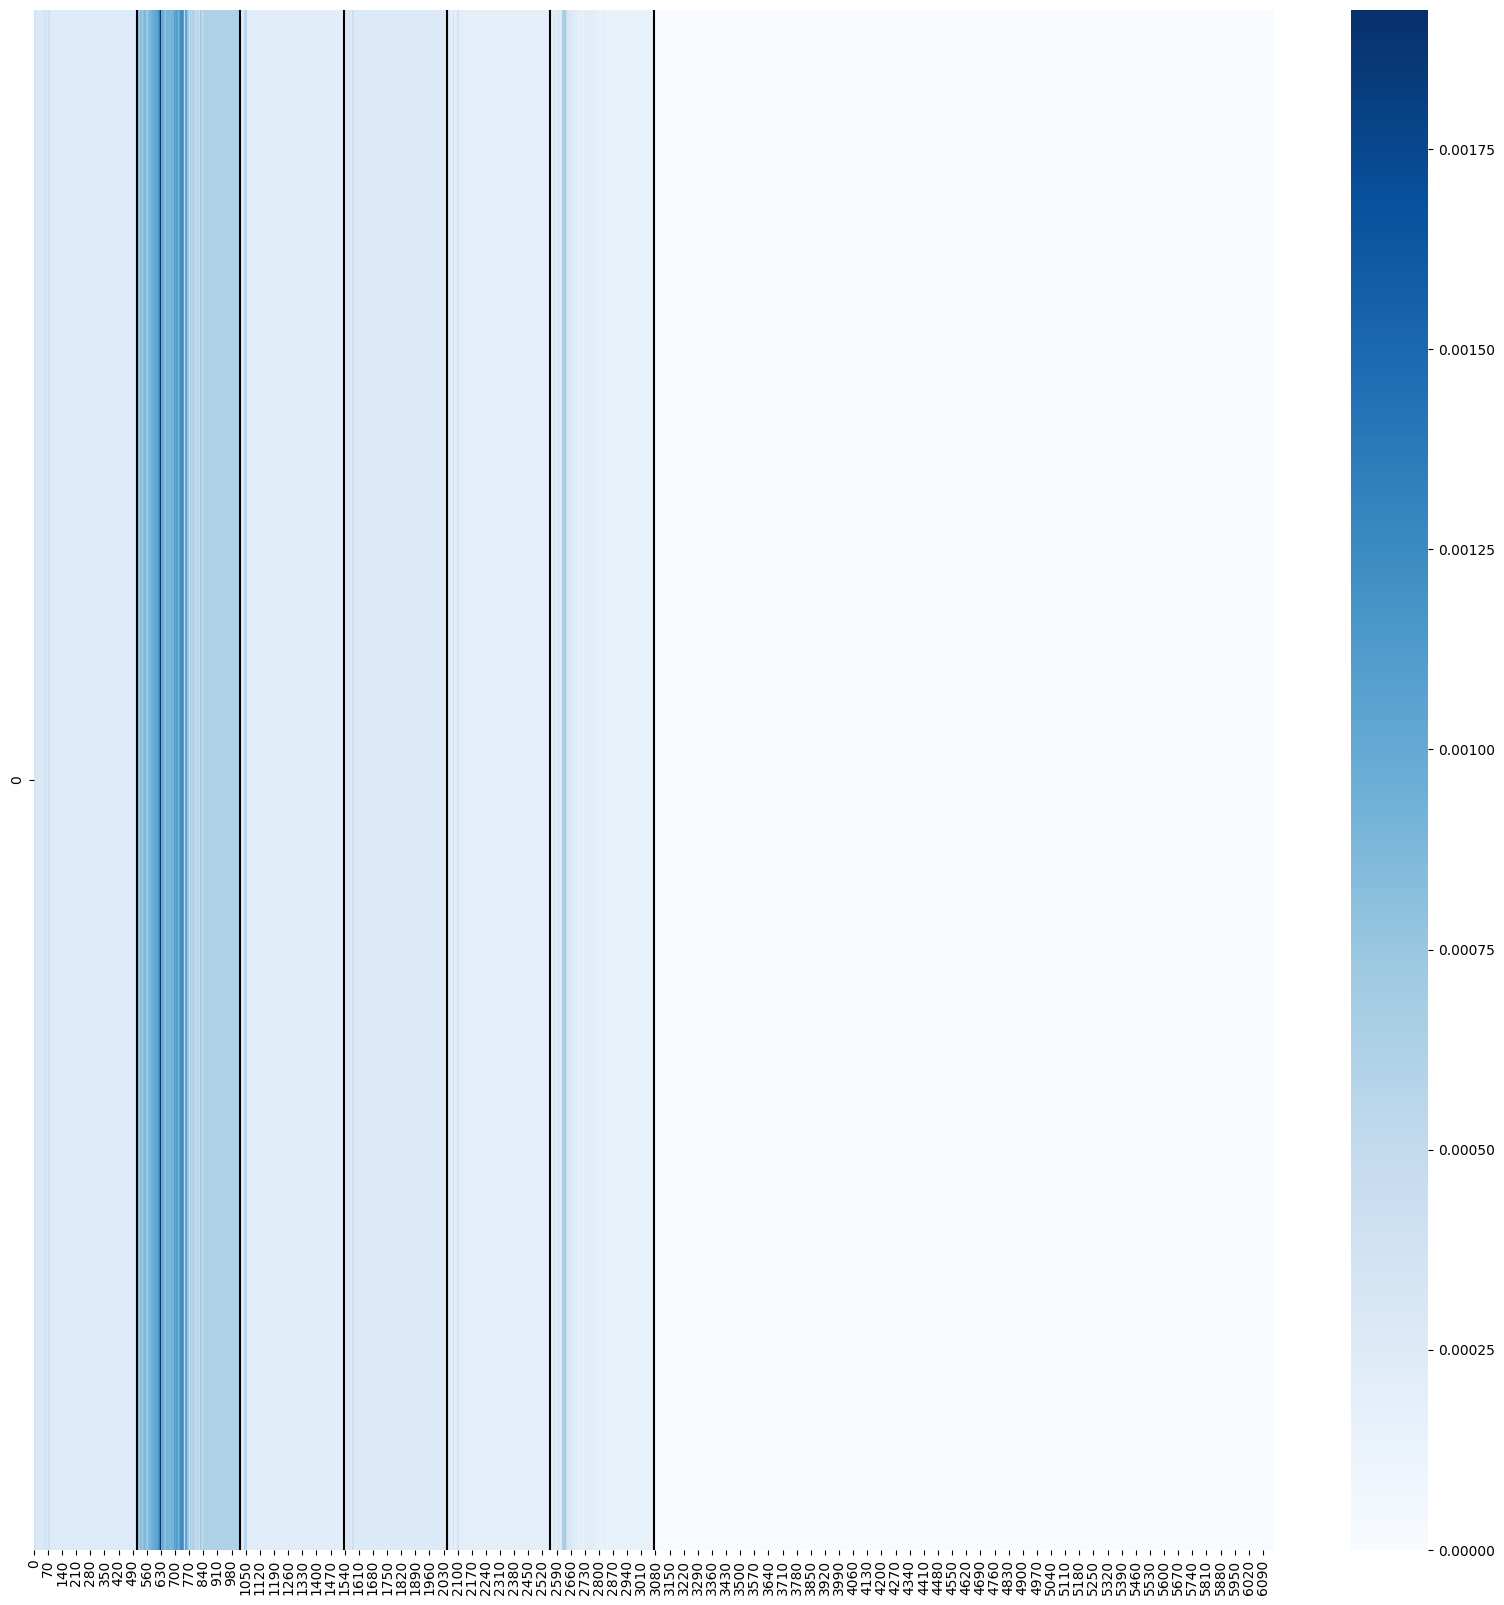

Label 5


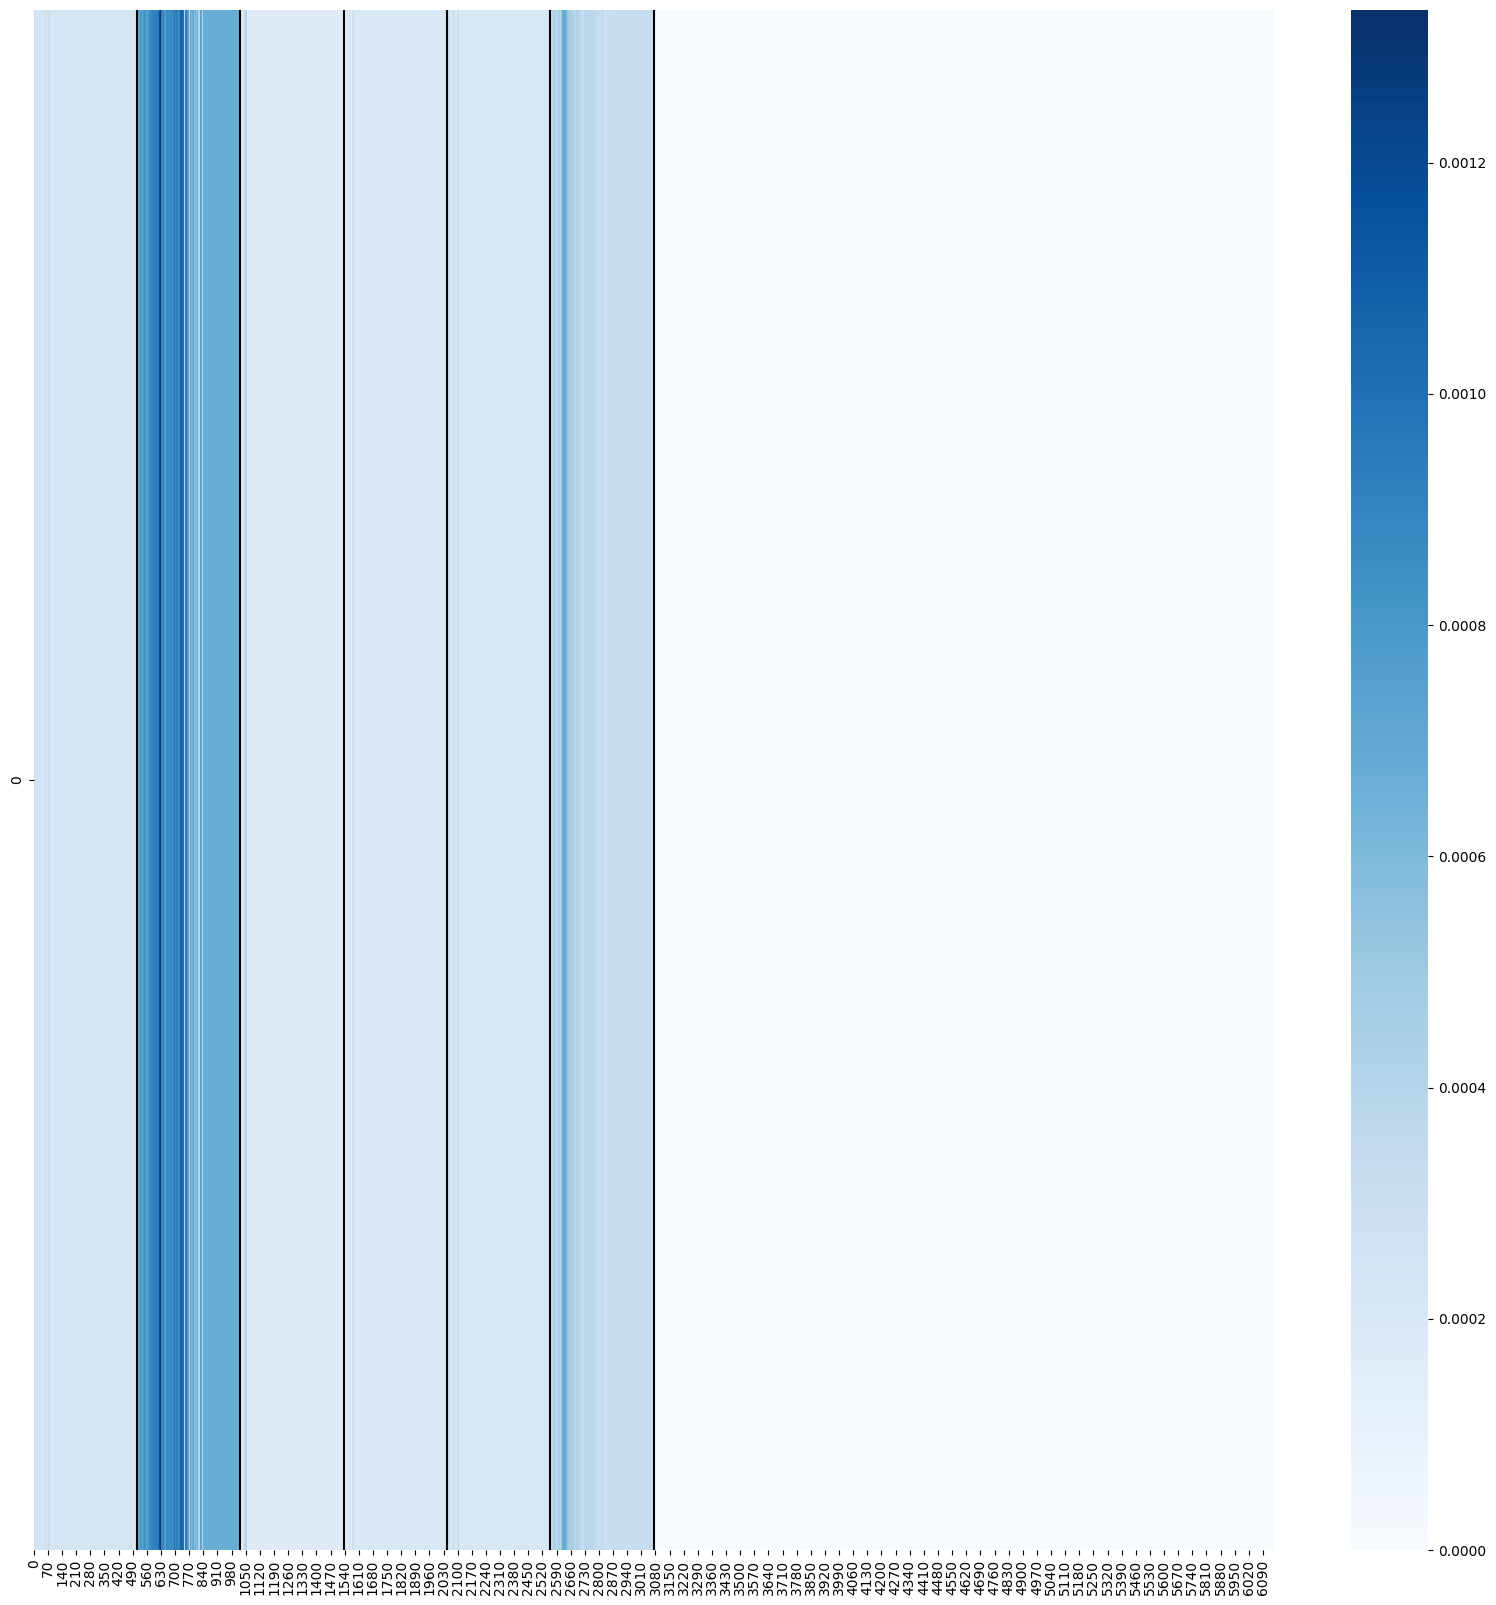

Label 20


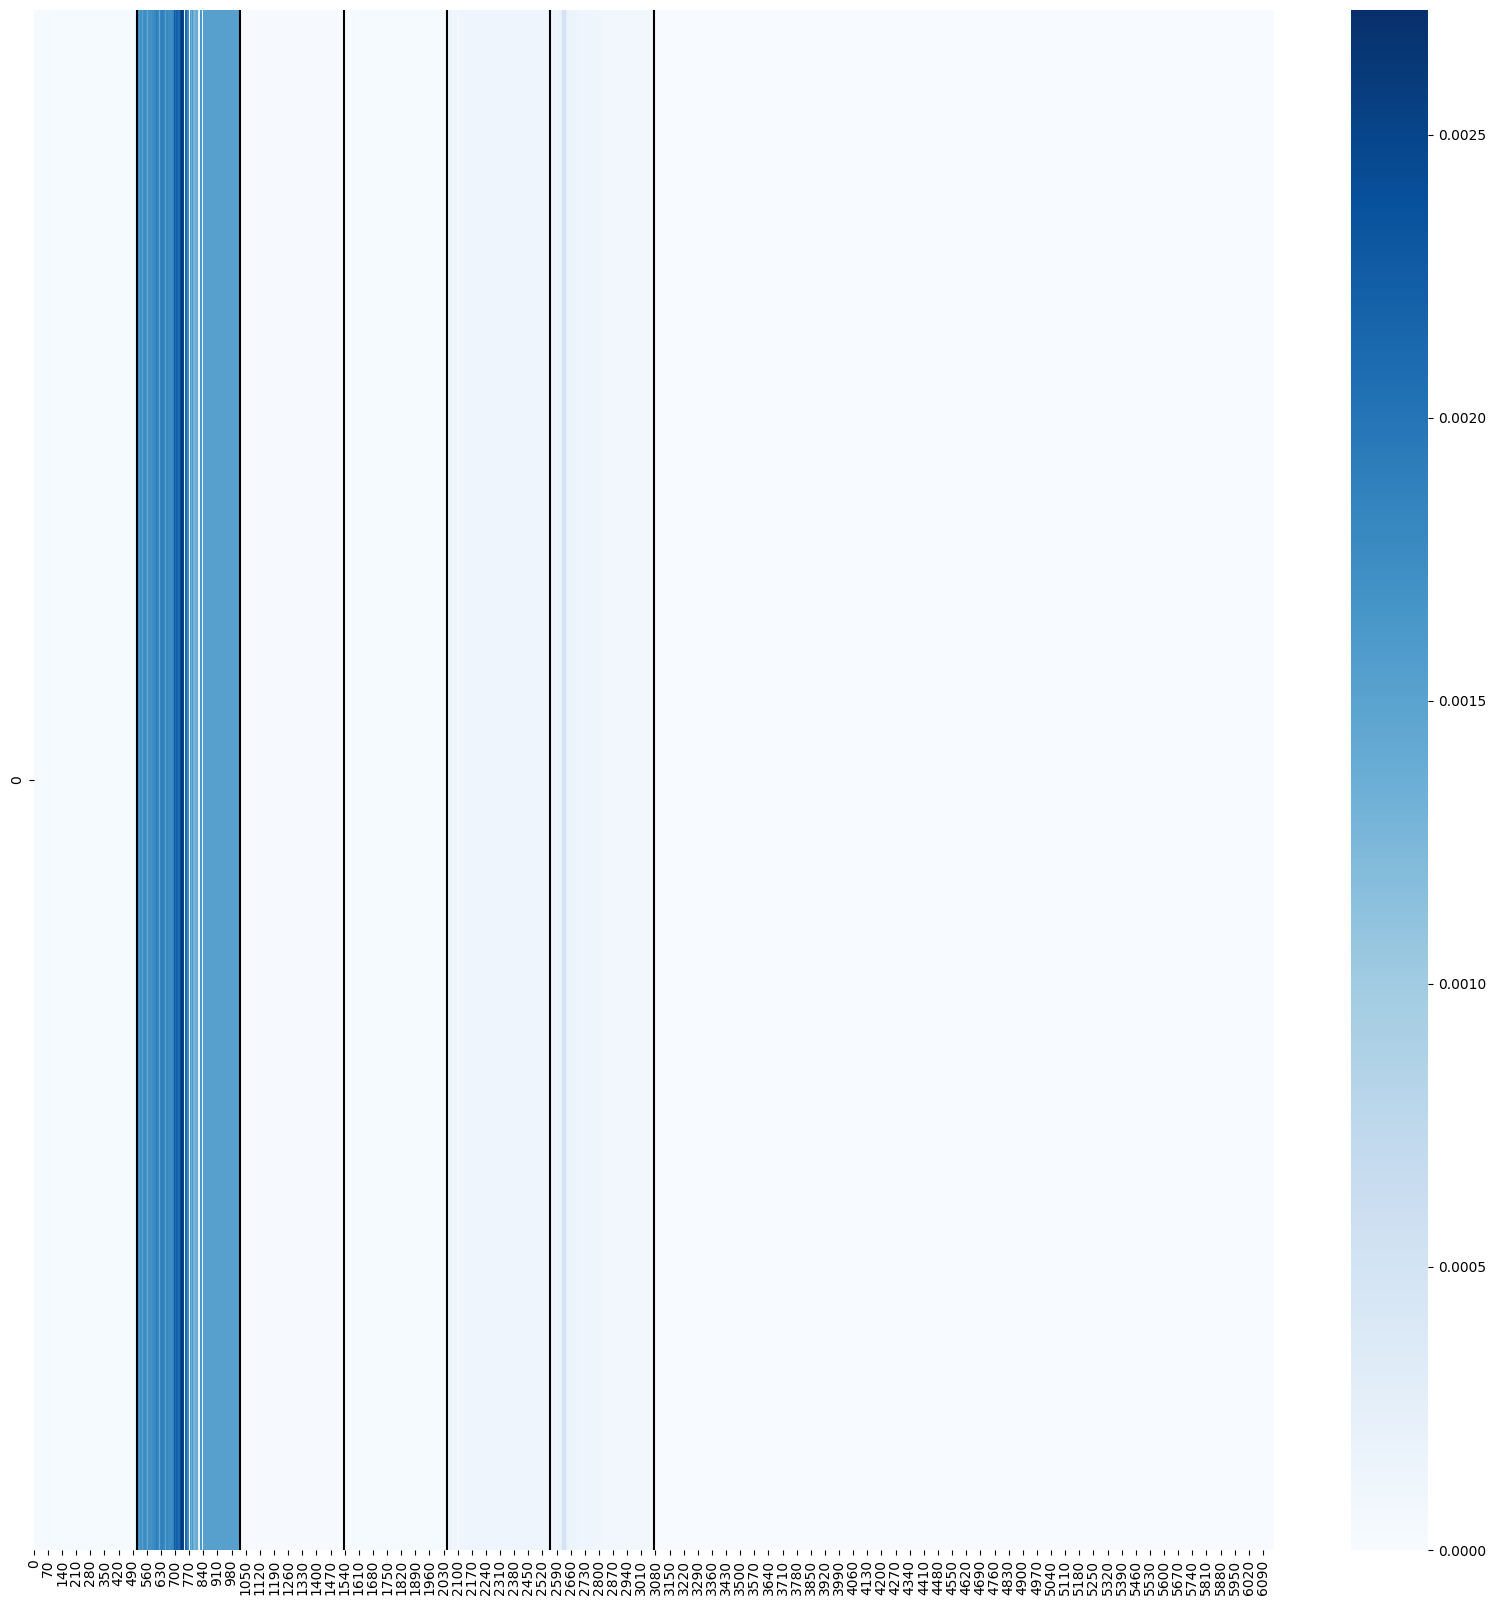

Label 21


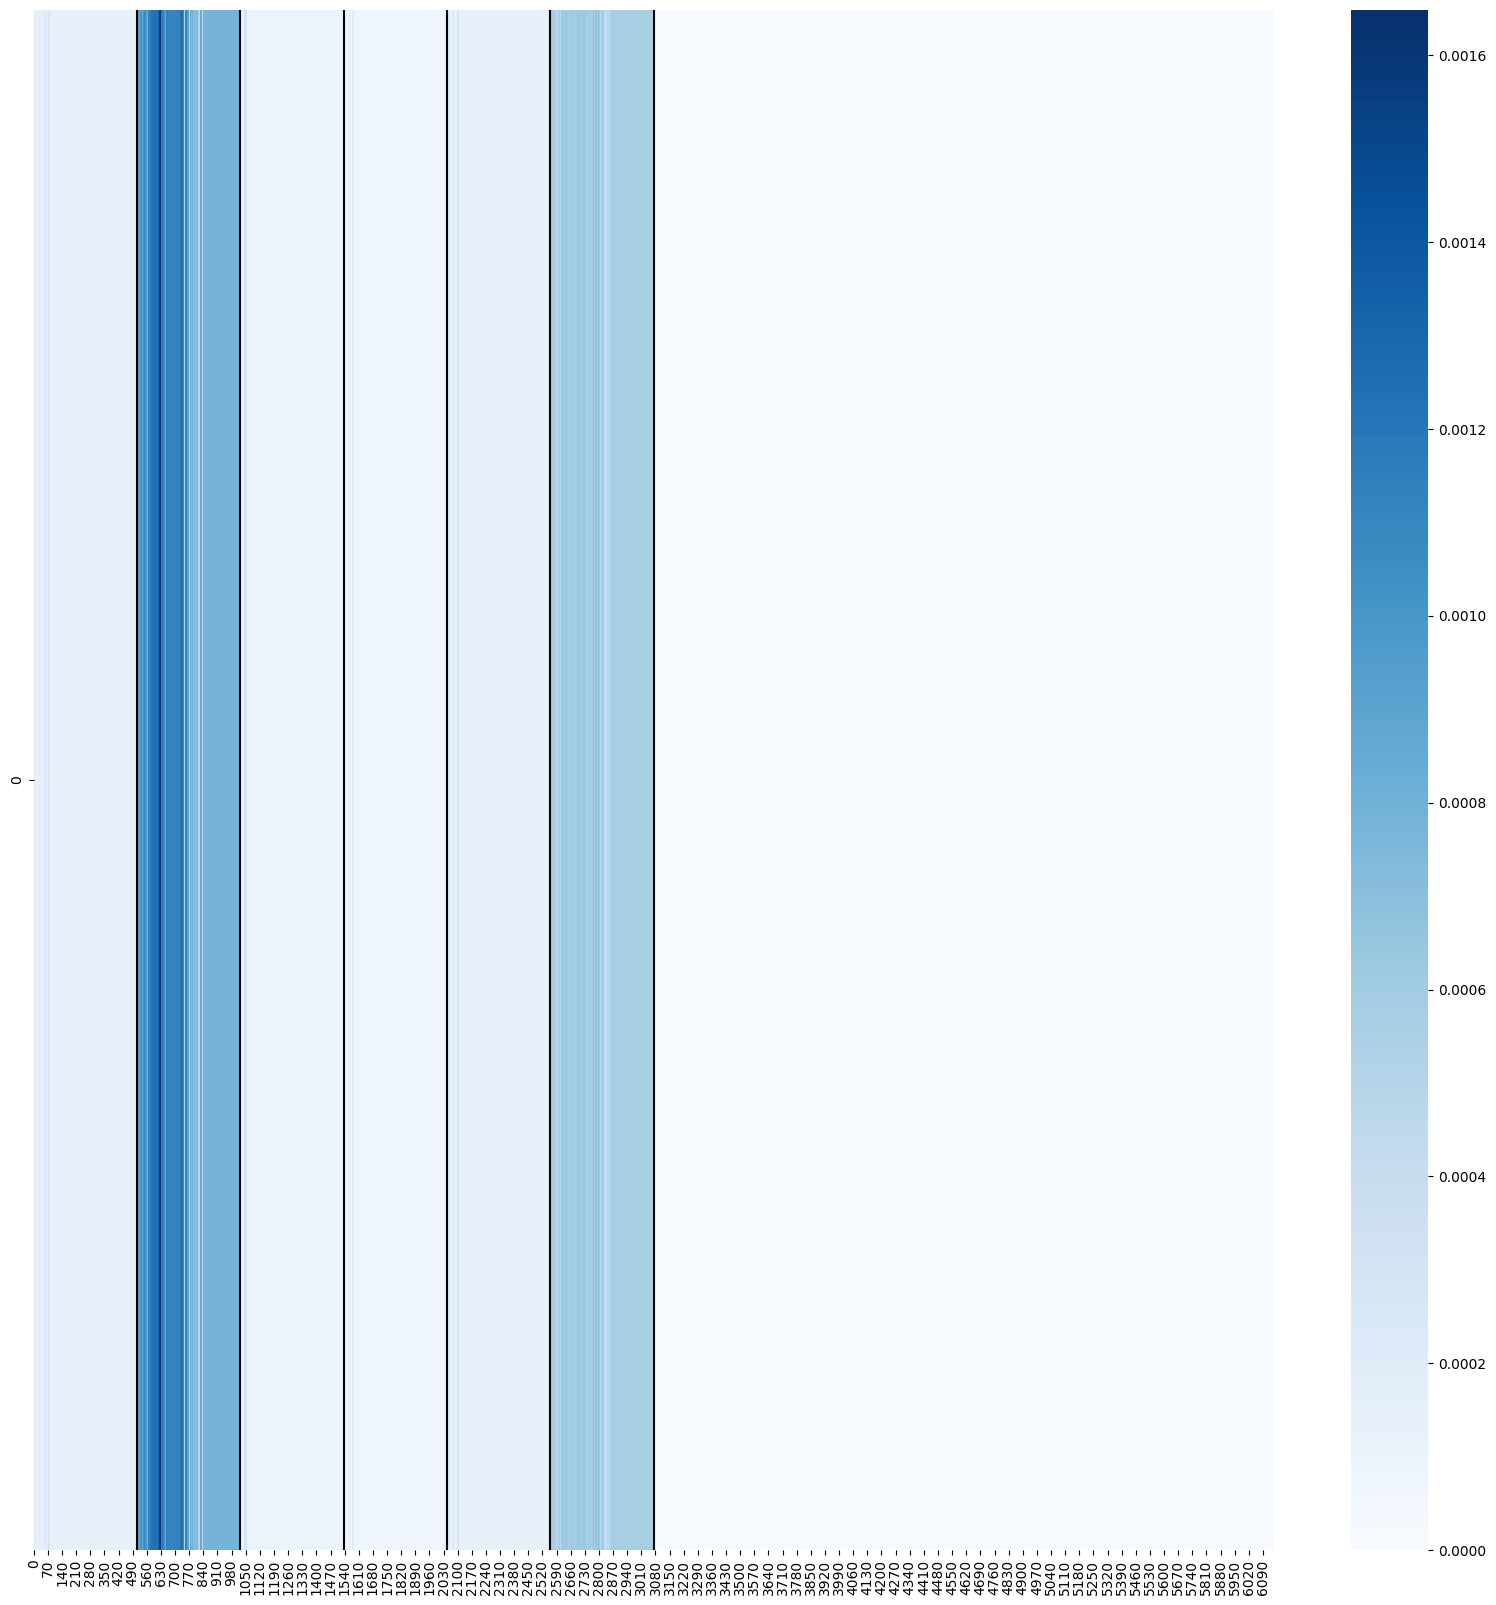

Label 43


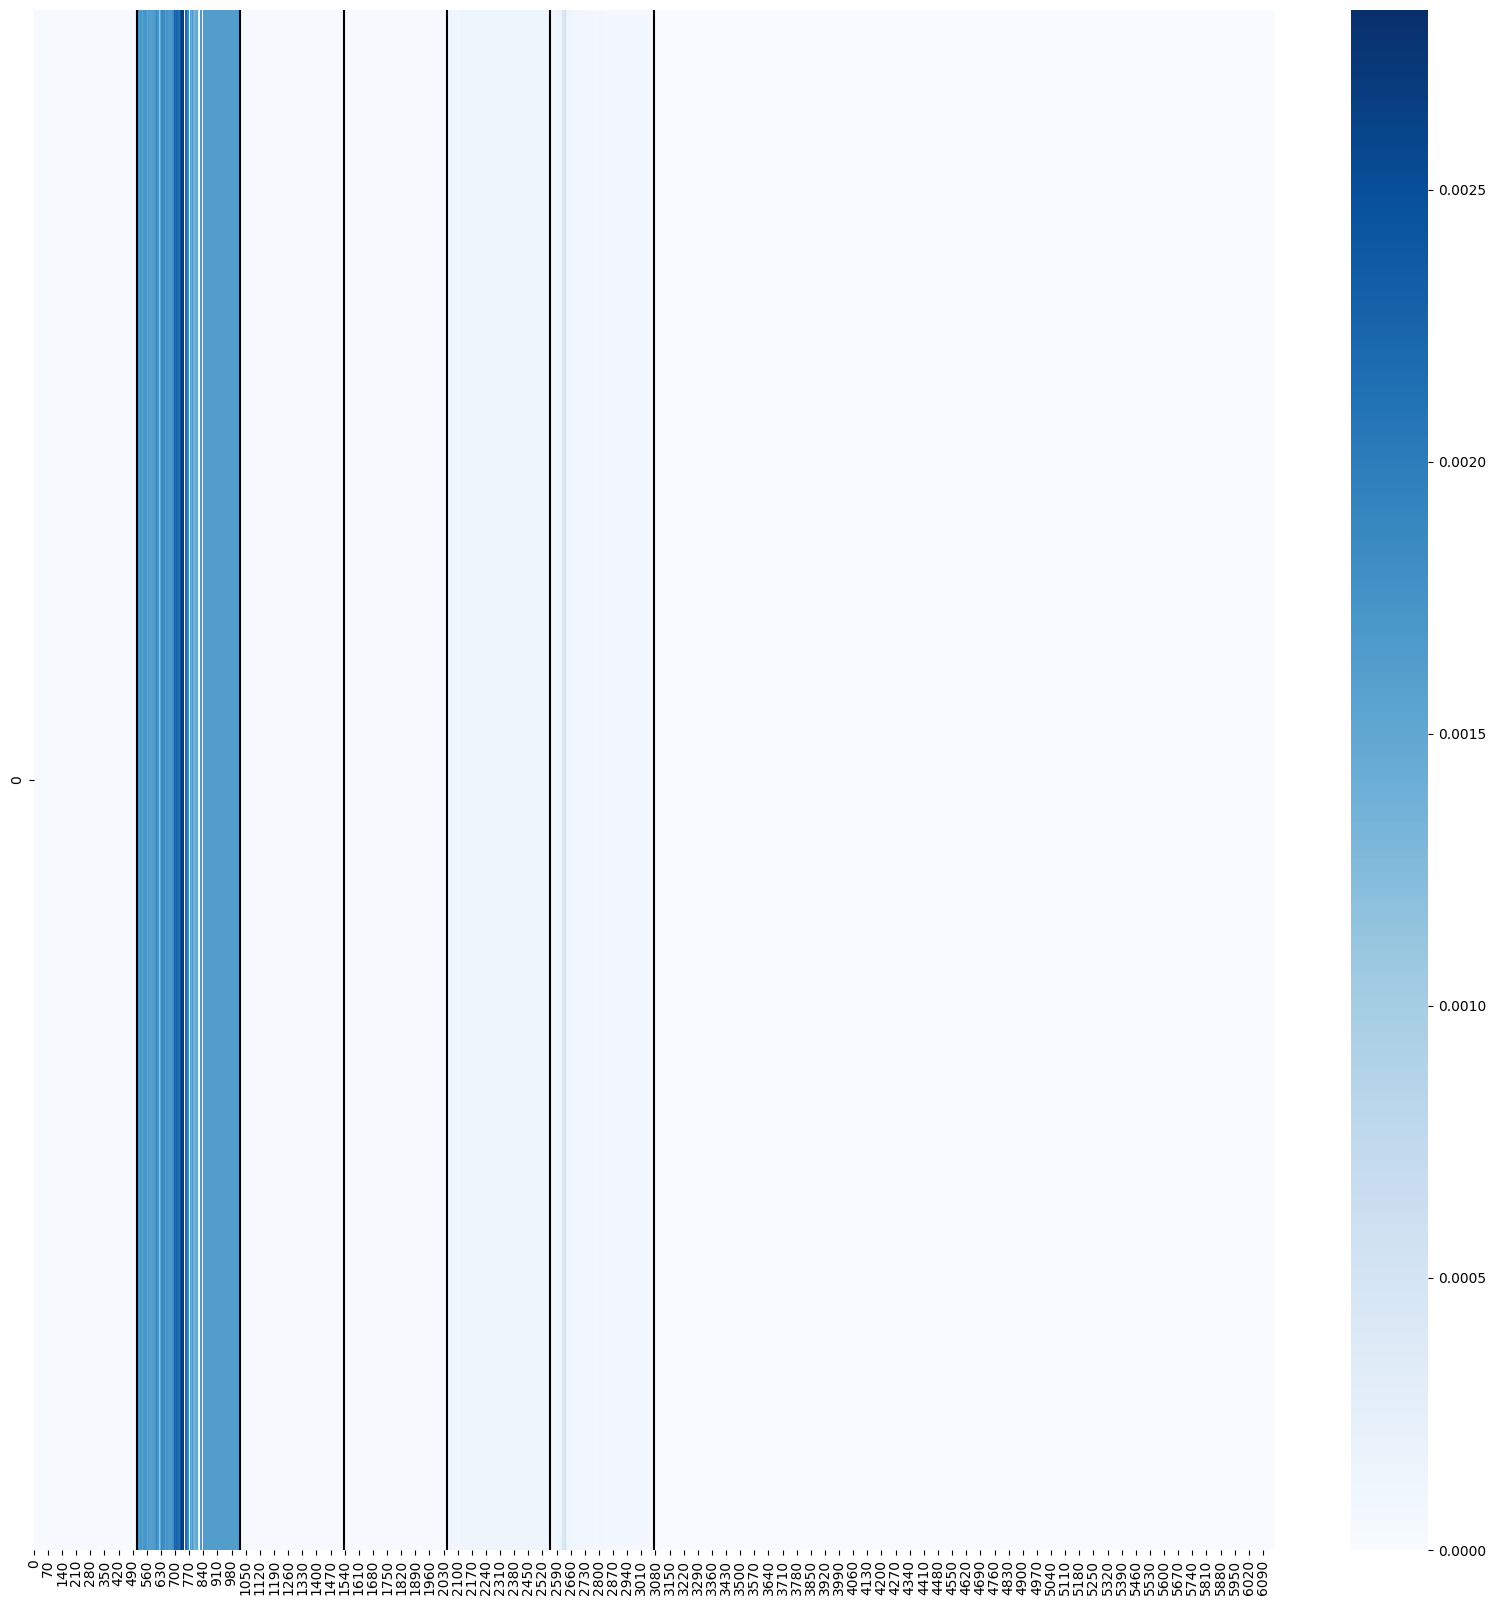

Label 45


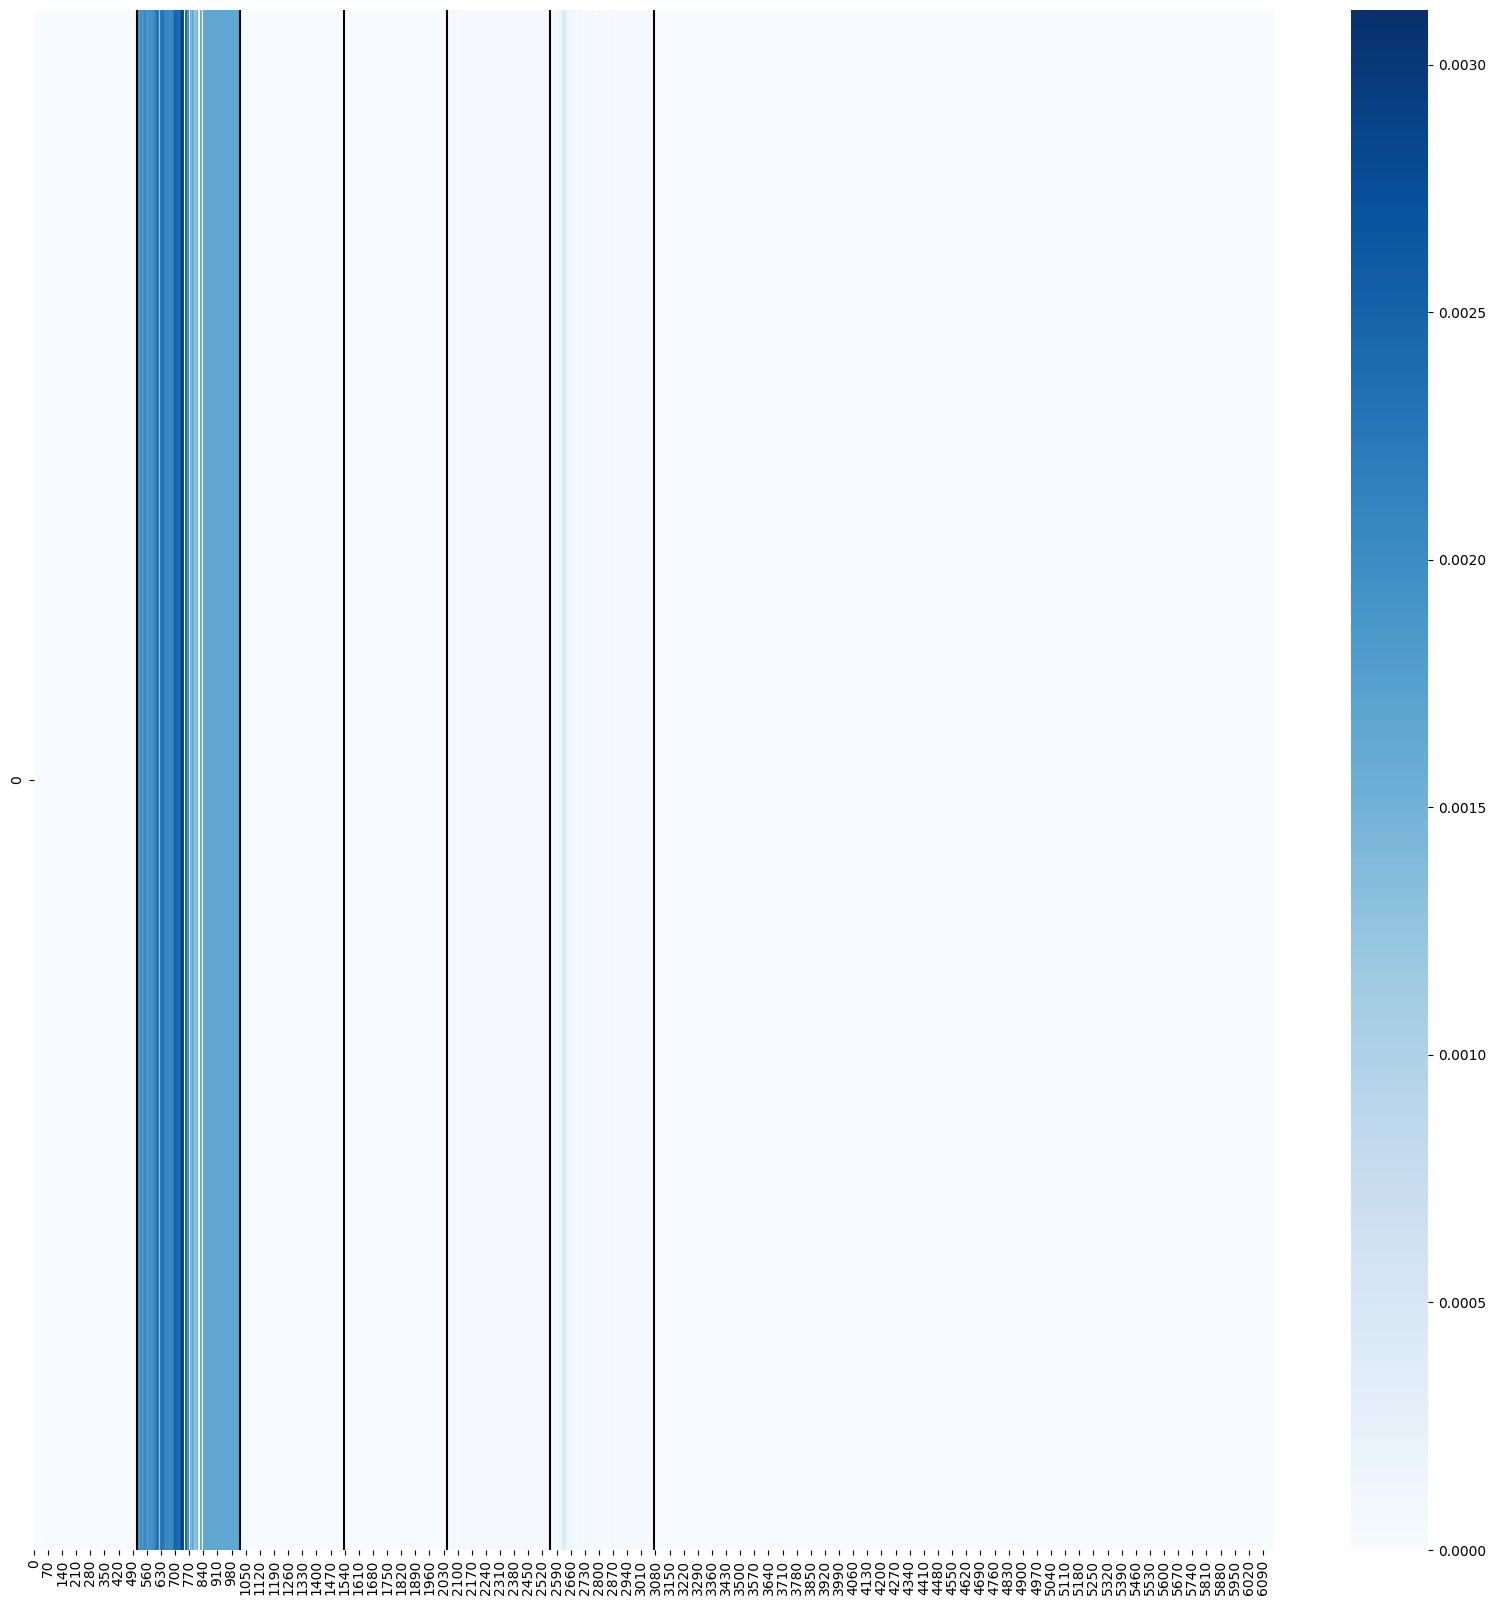

Cutoff noDS
Label 0


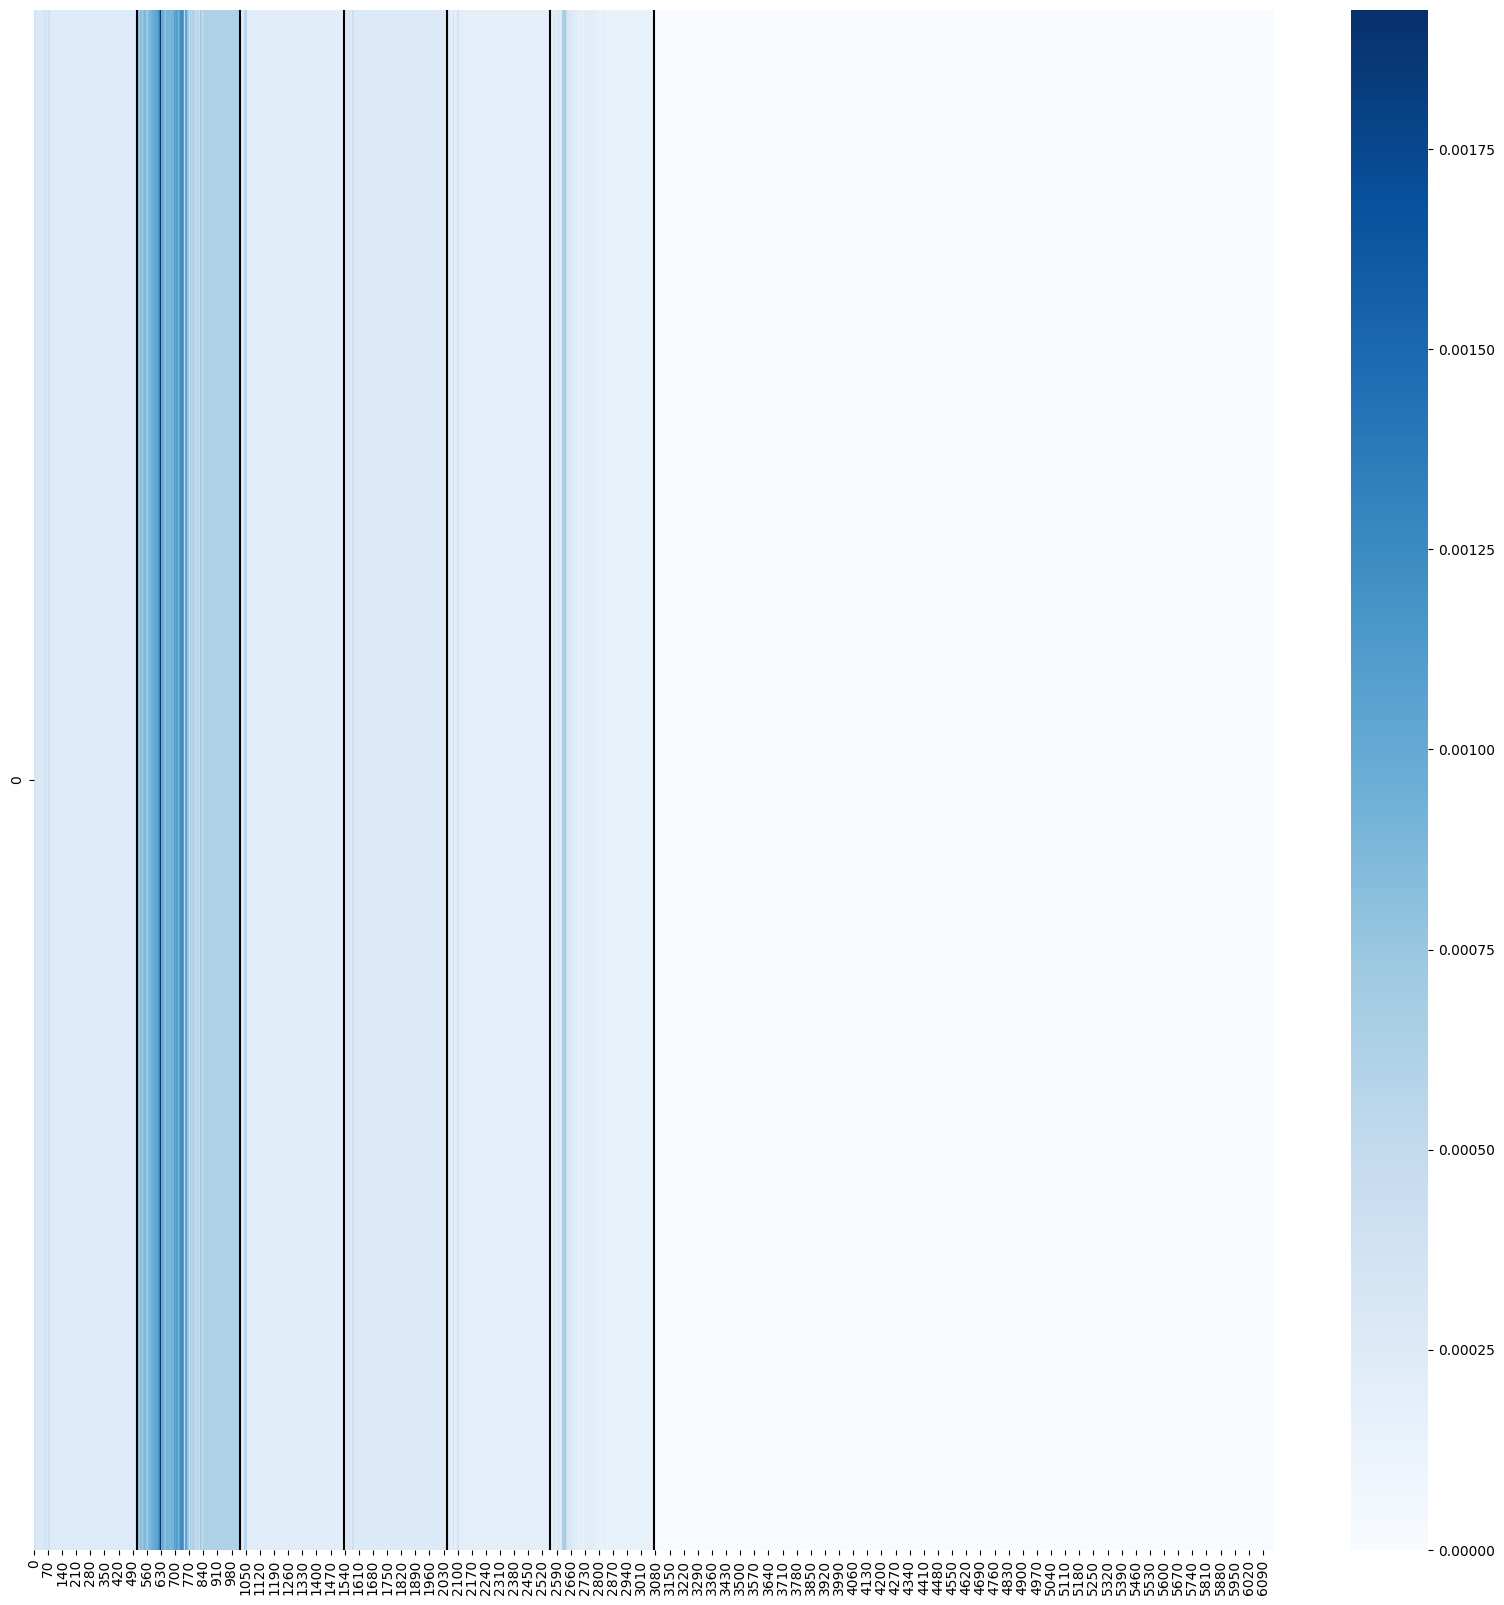

Label 5


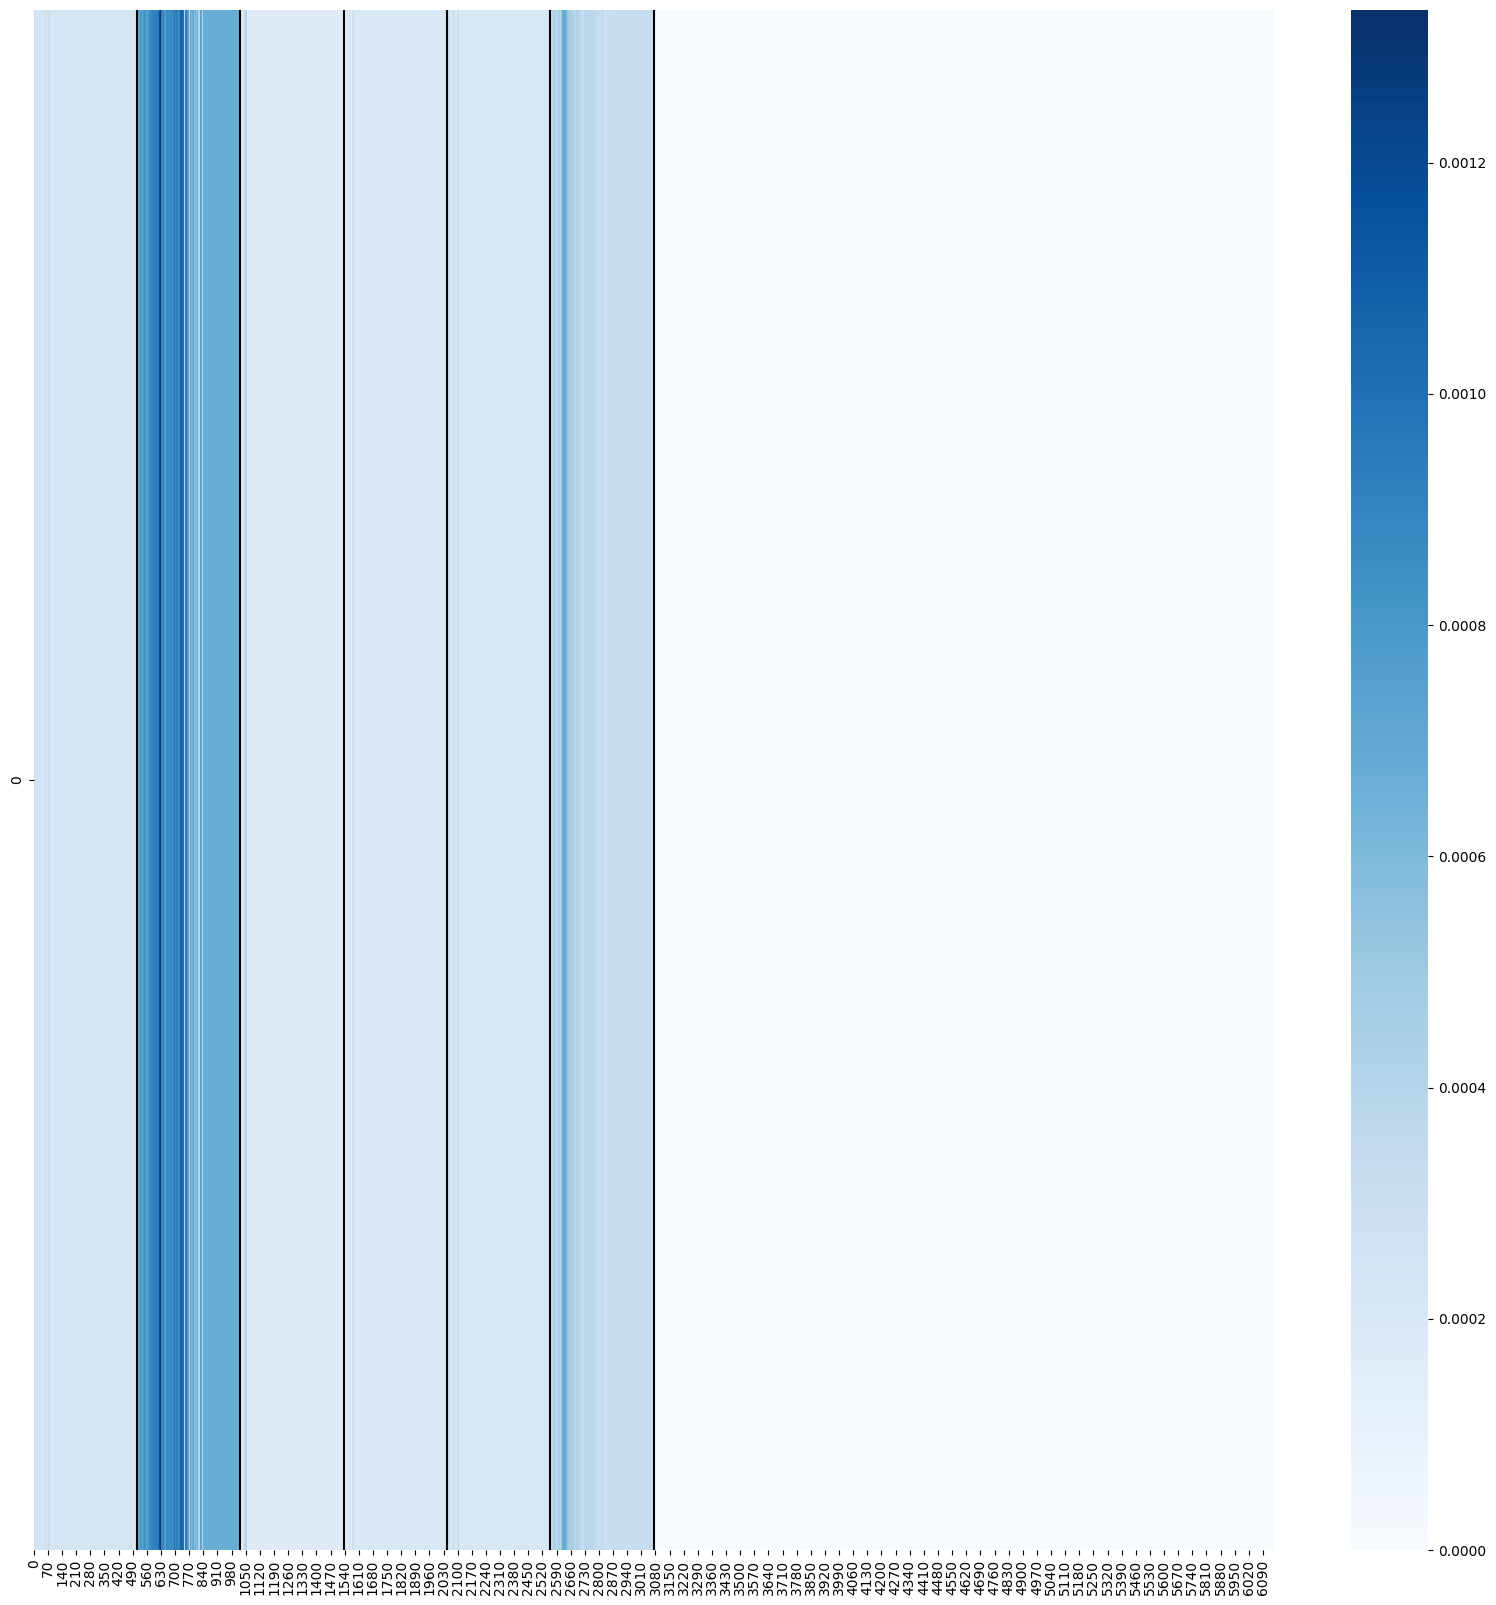

Label 20


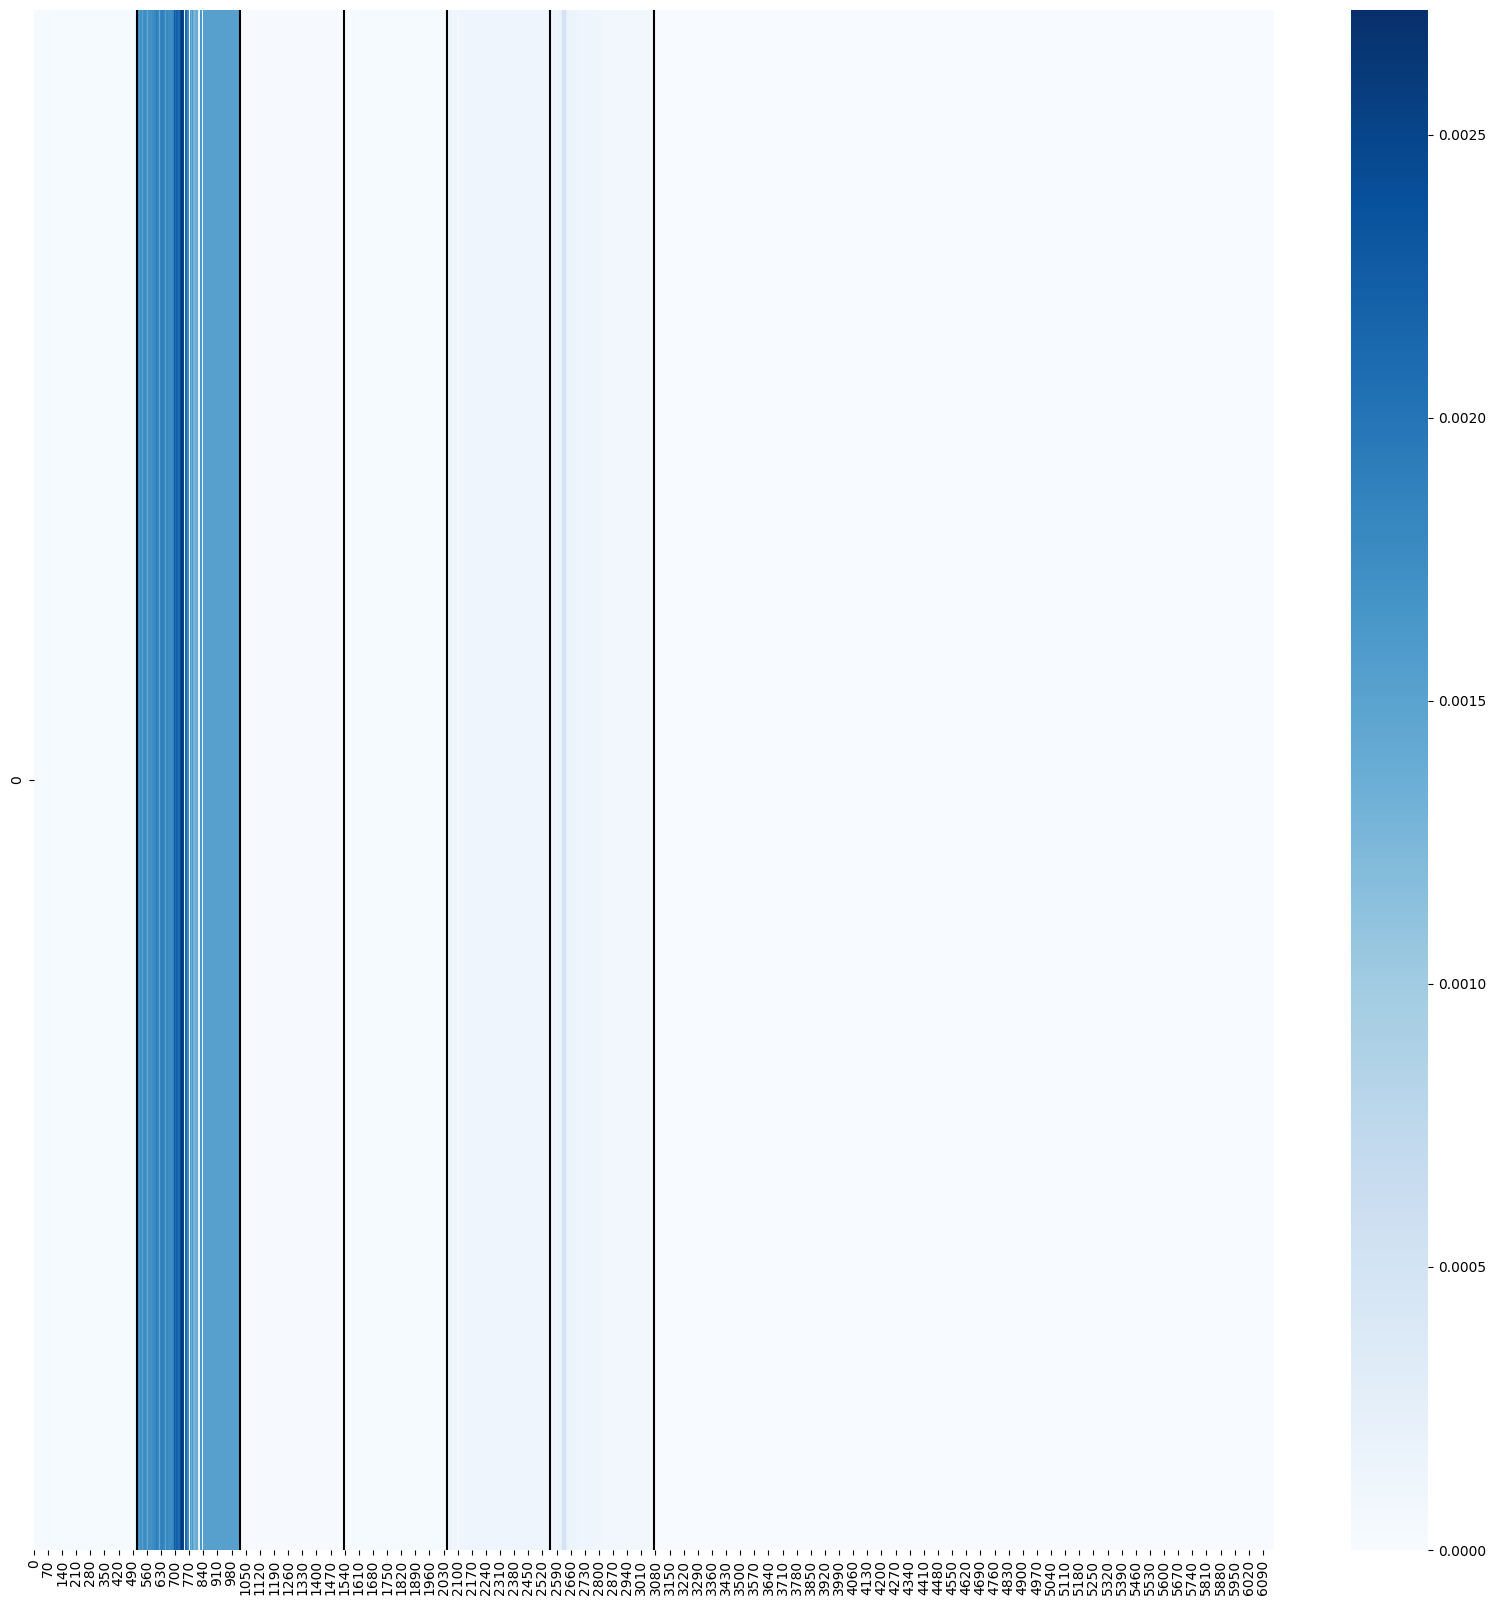

Label 21


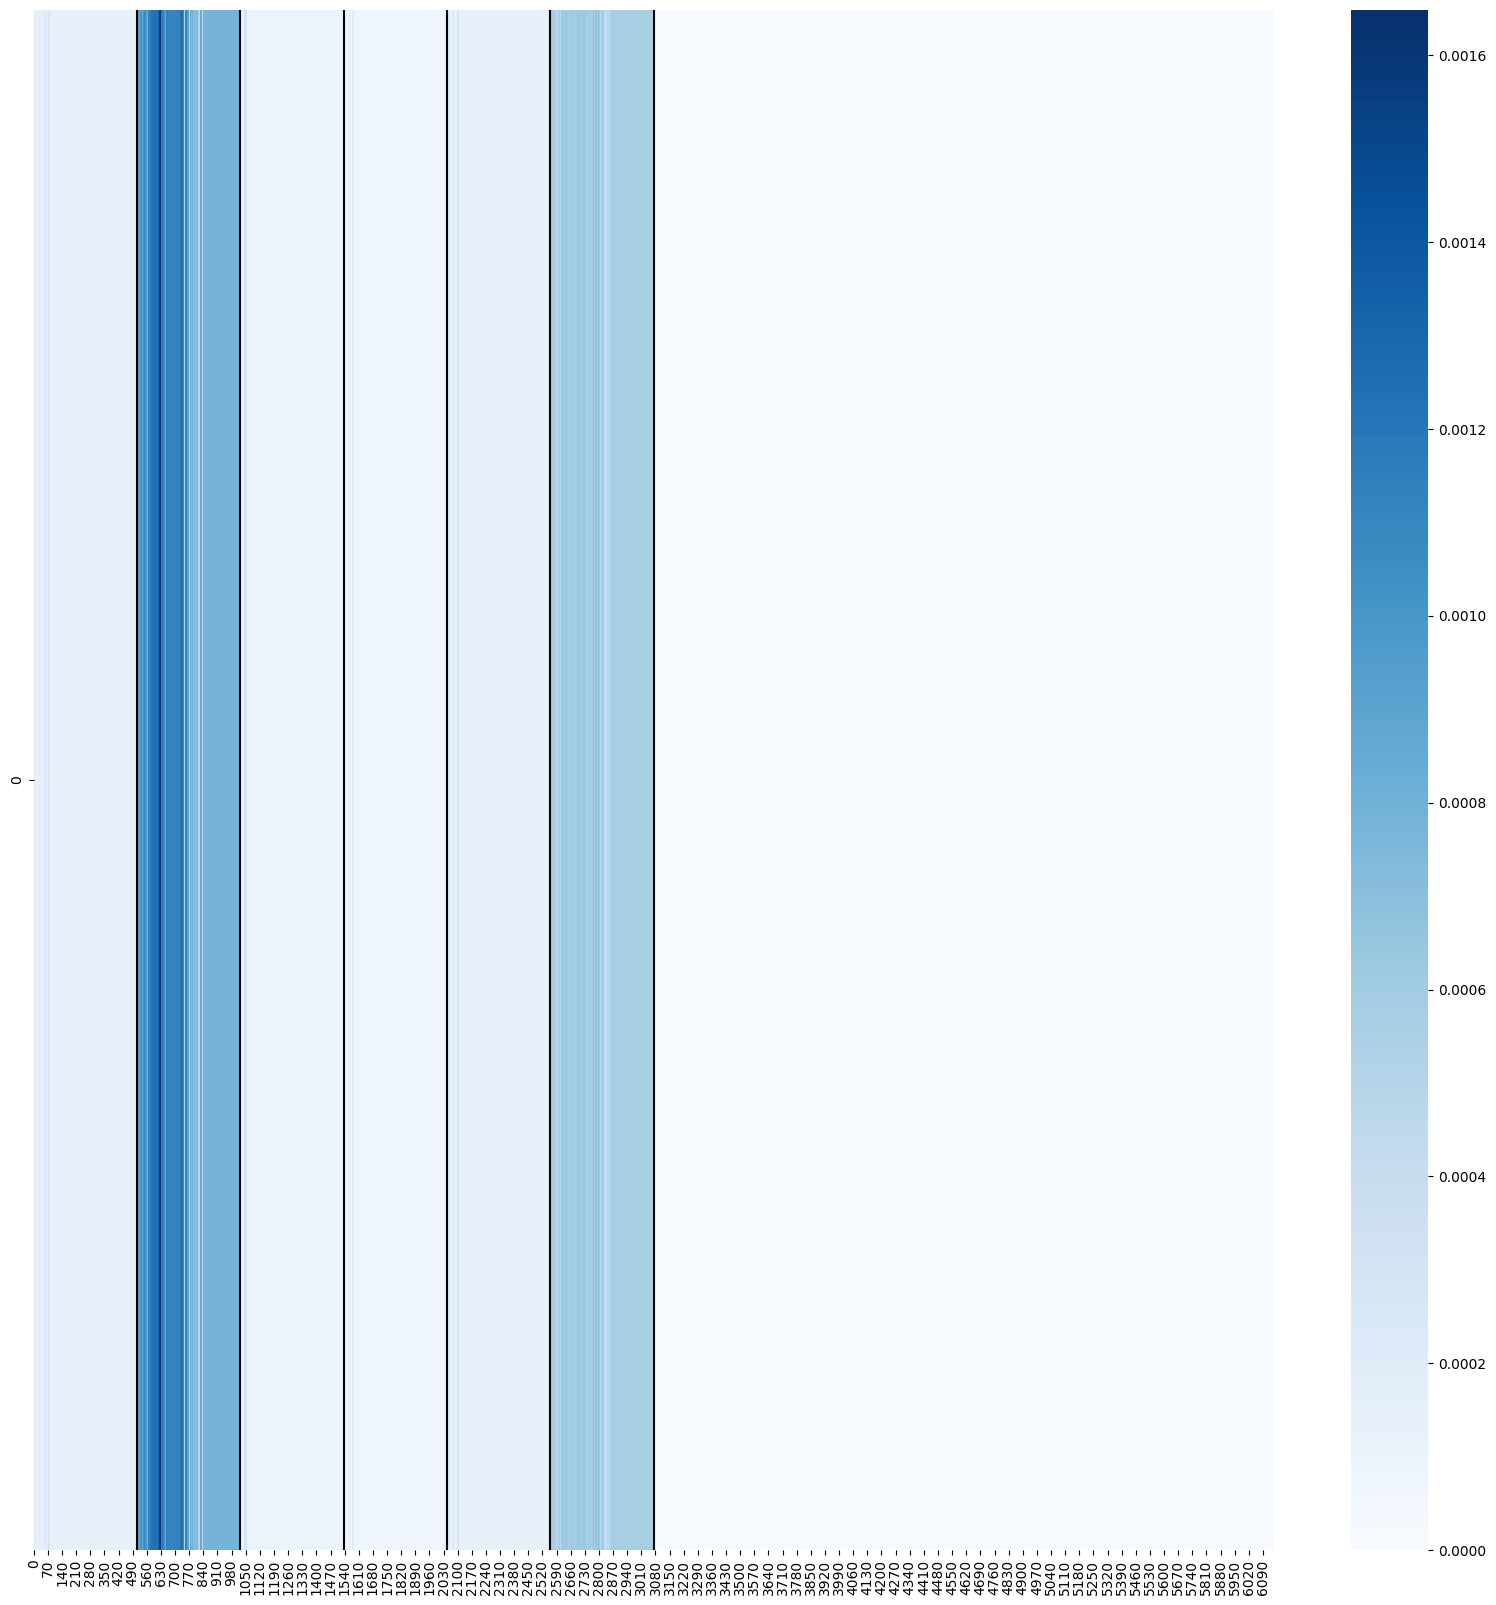

Label 43


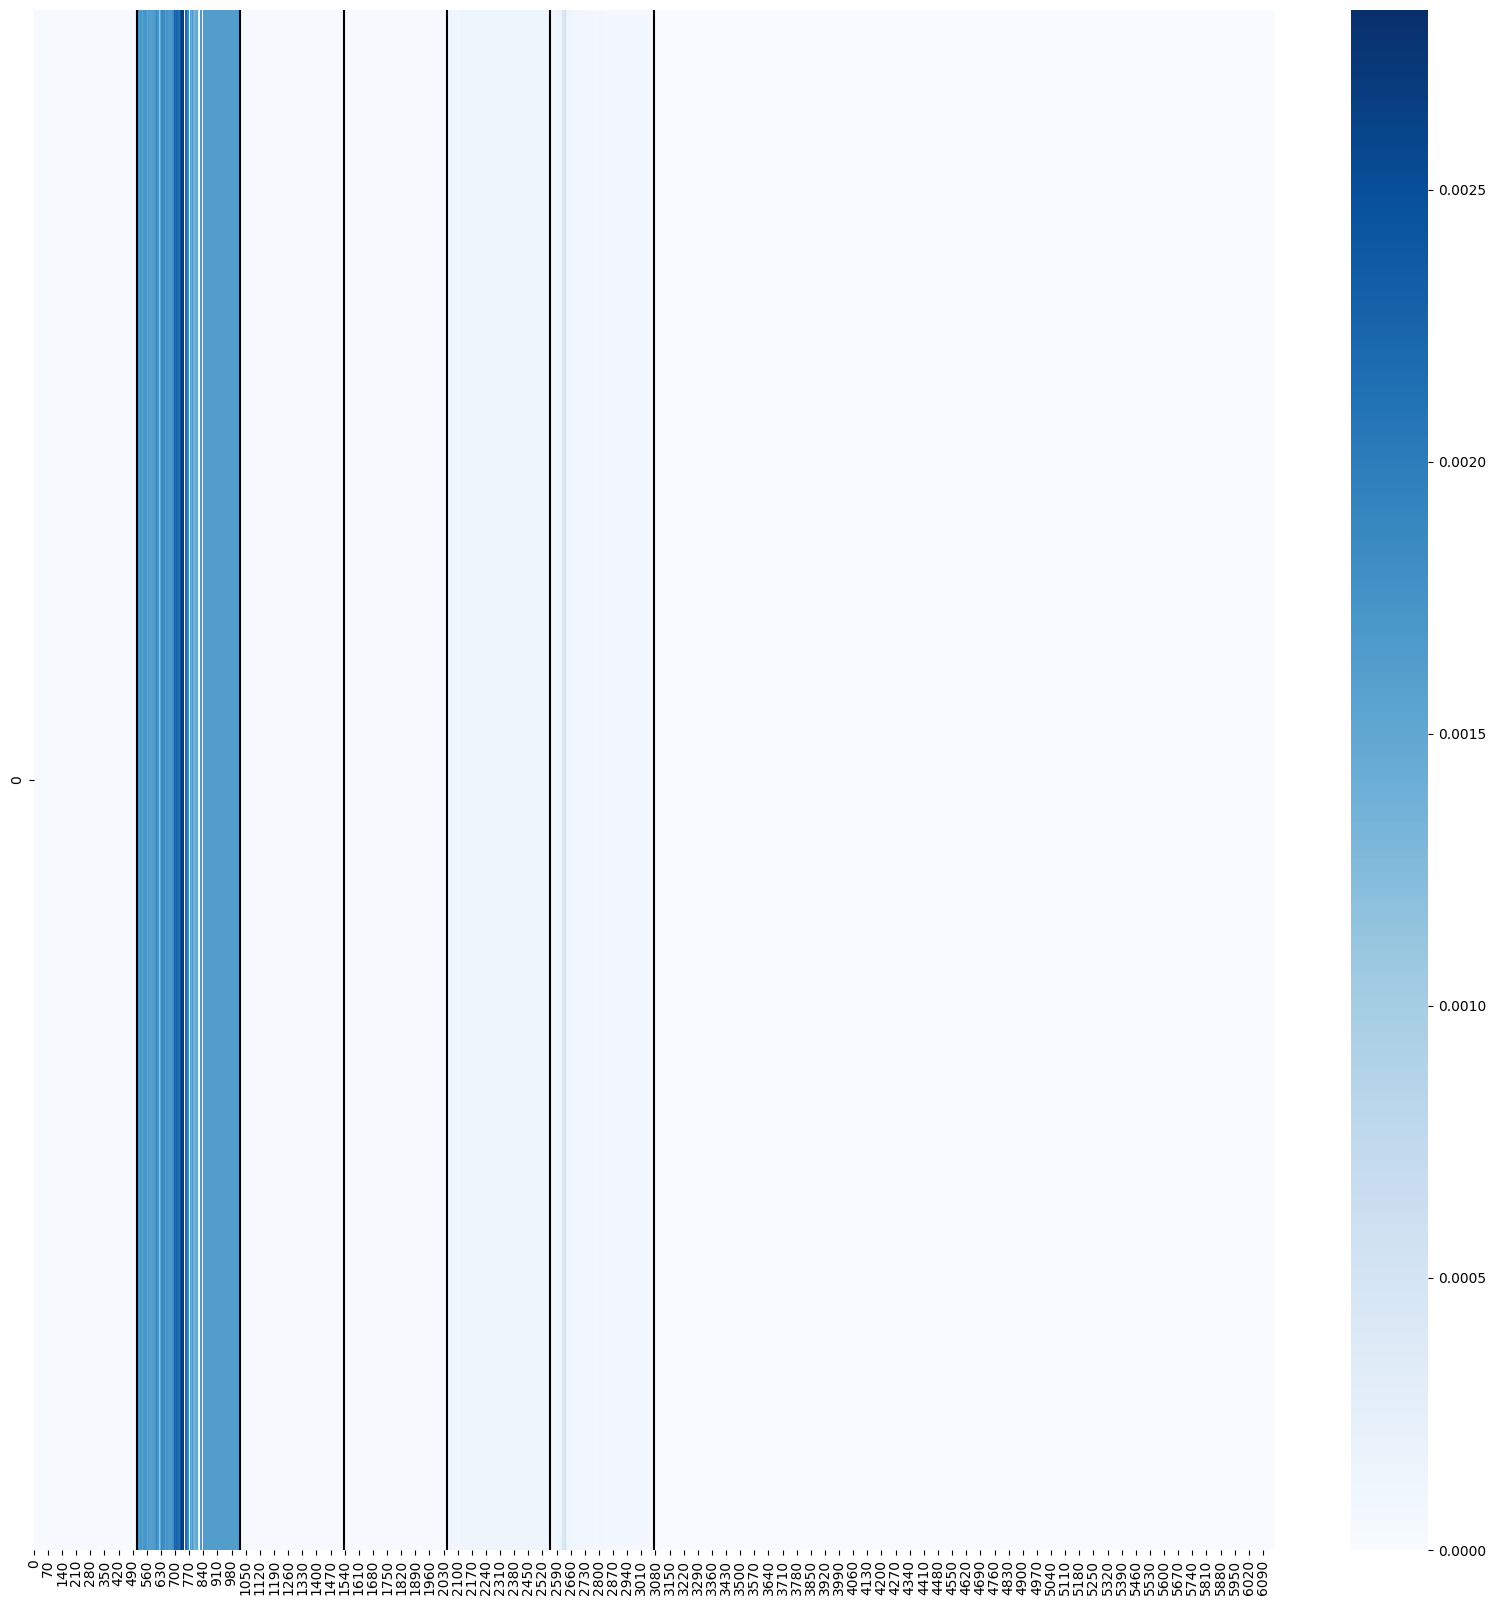

Label 45


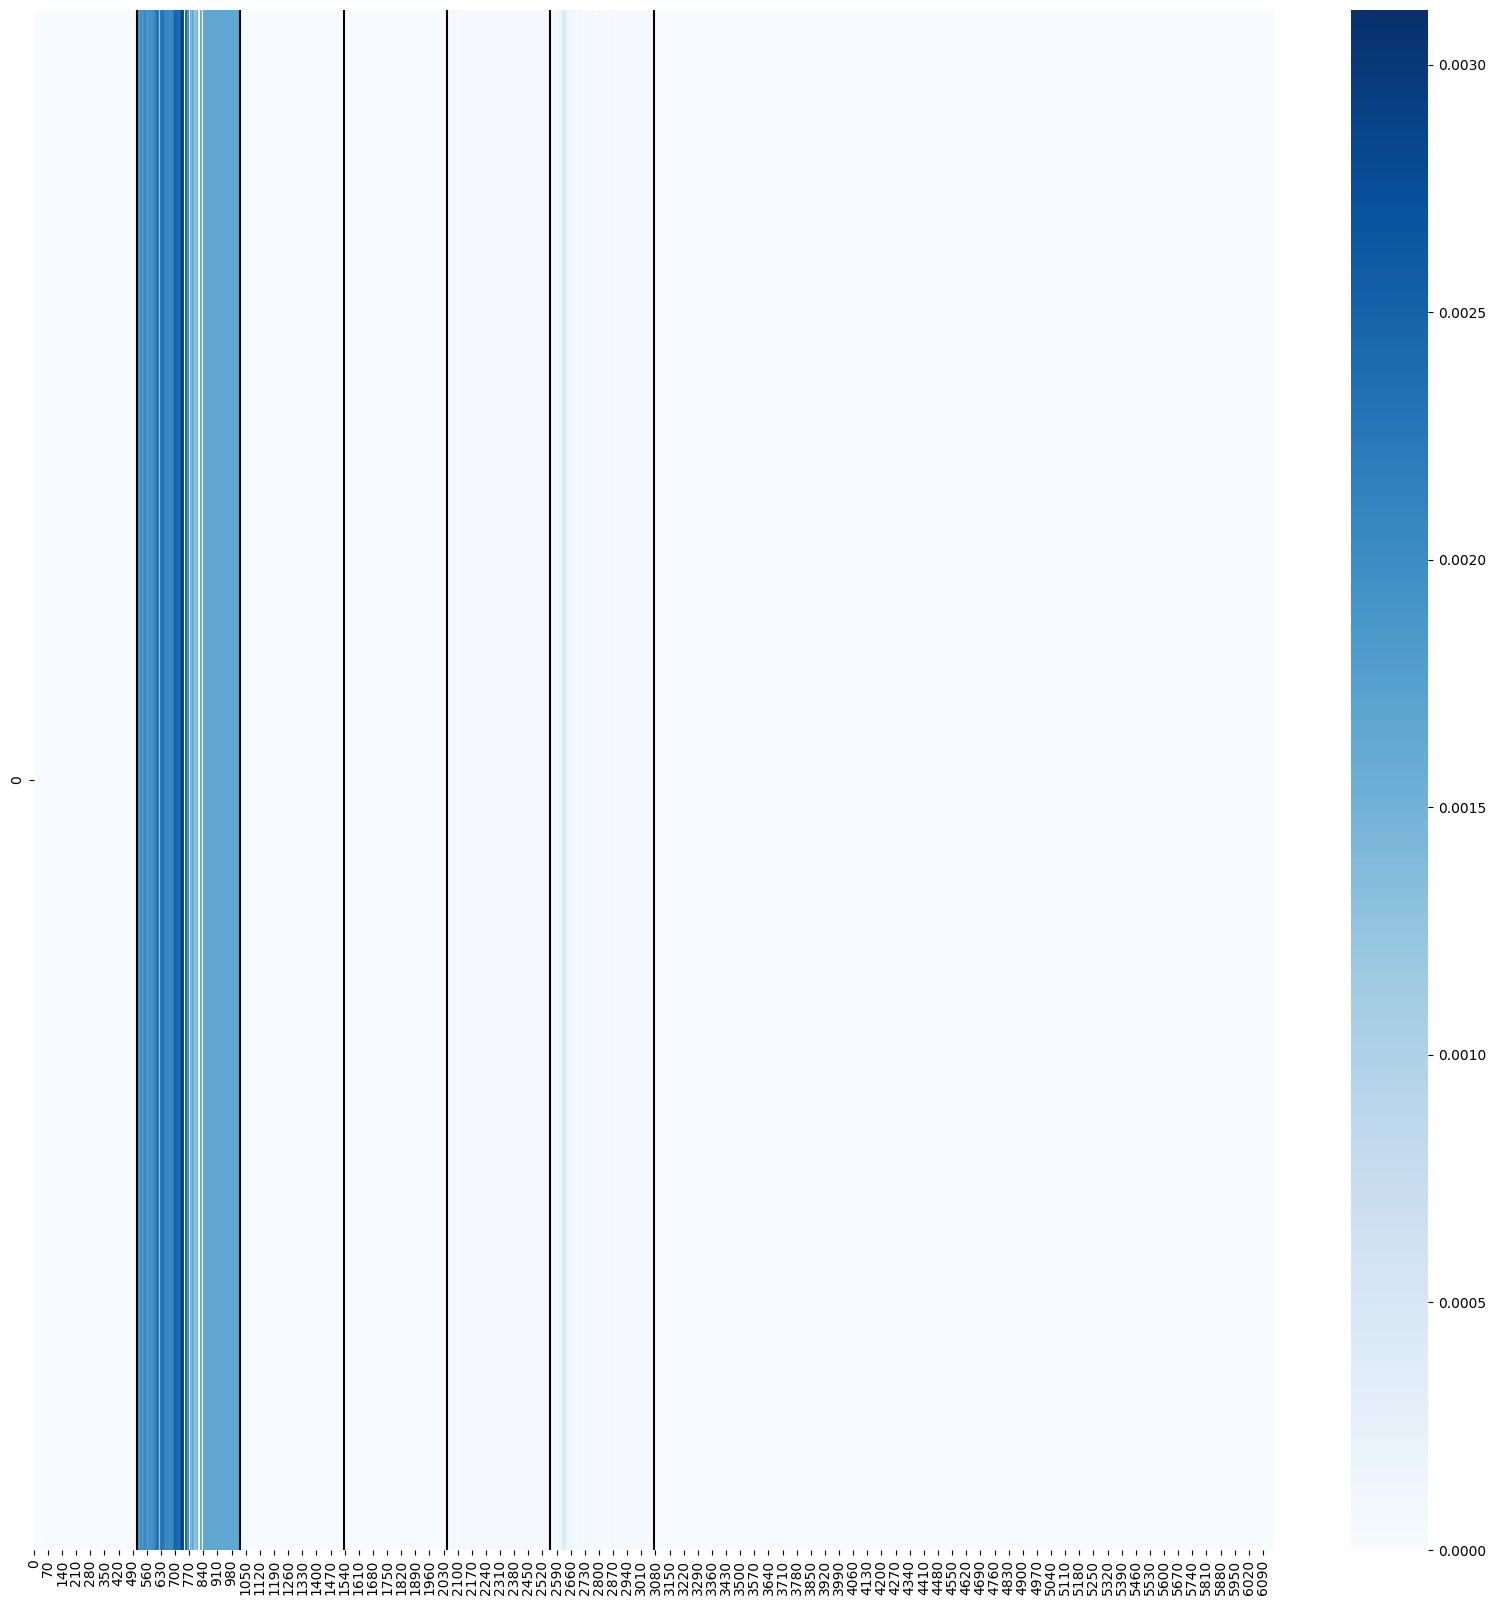

Cutoff all
Label 0


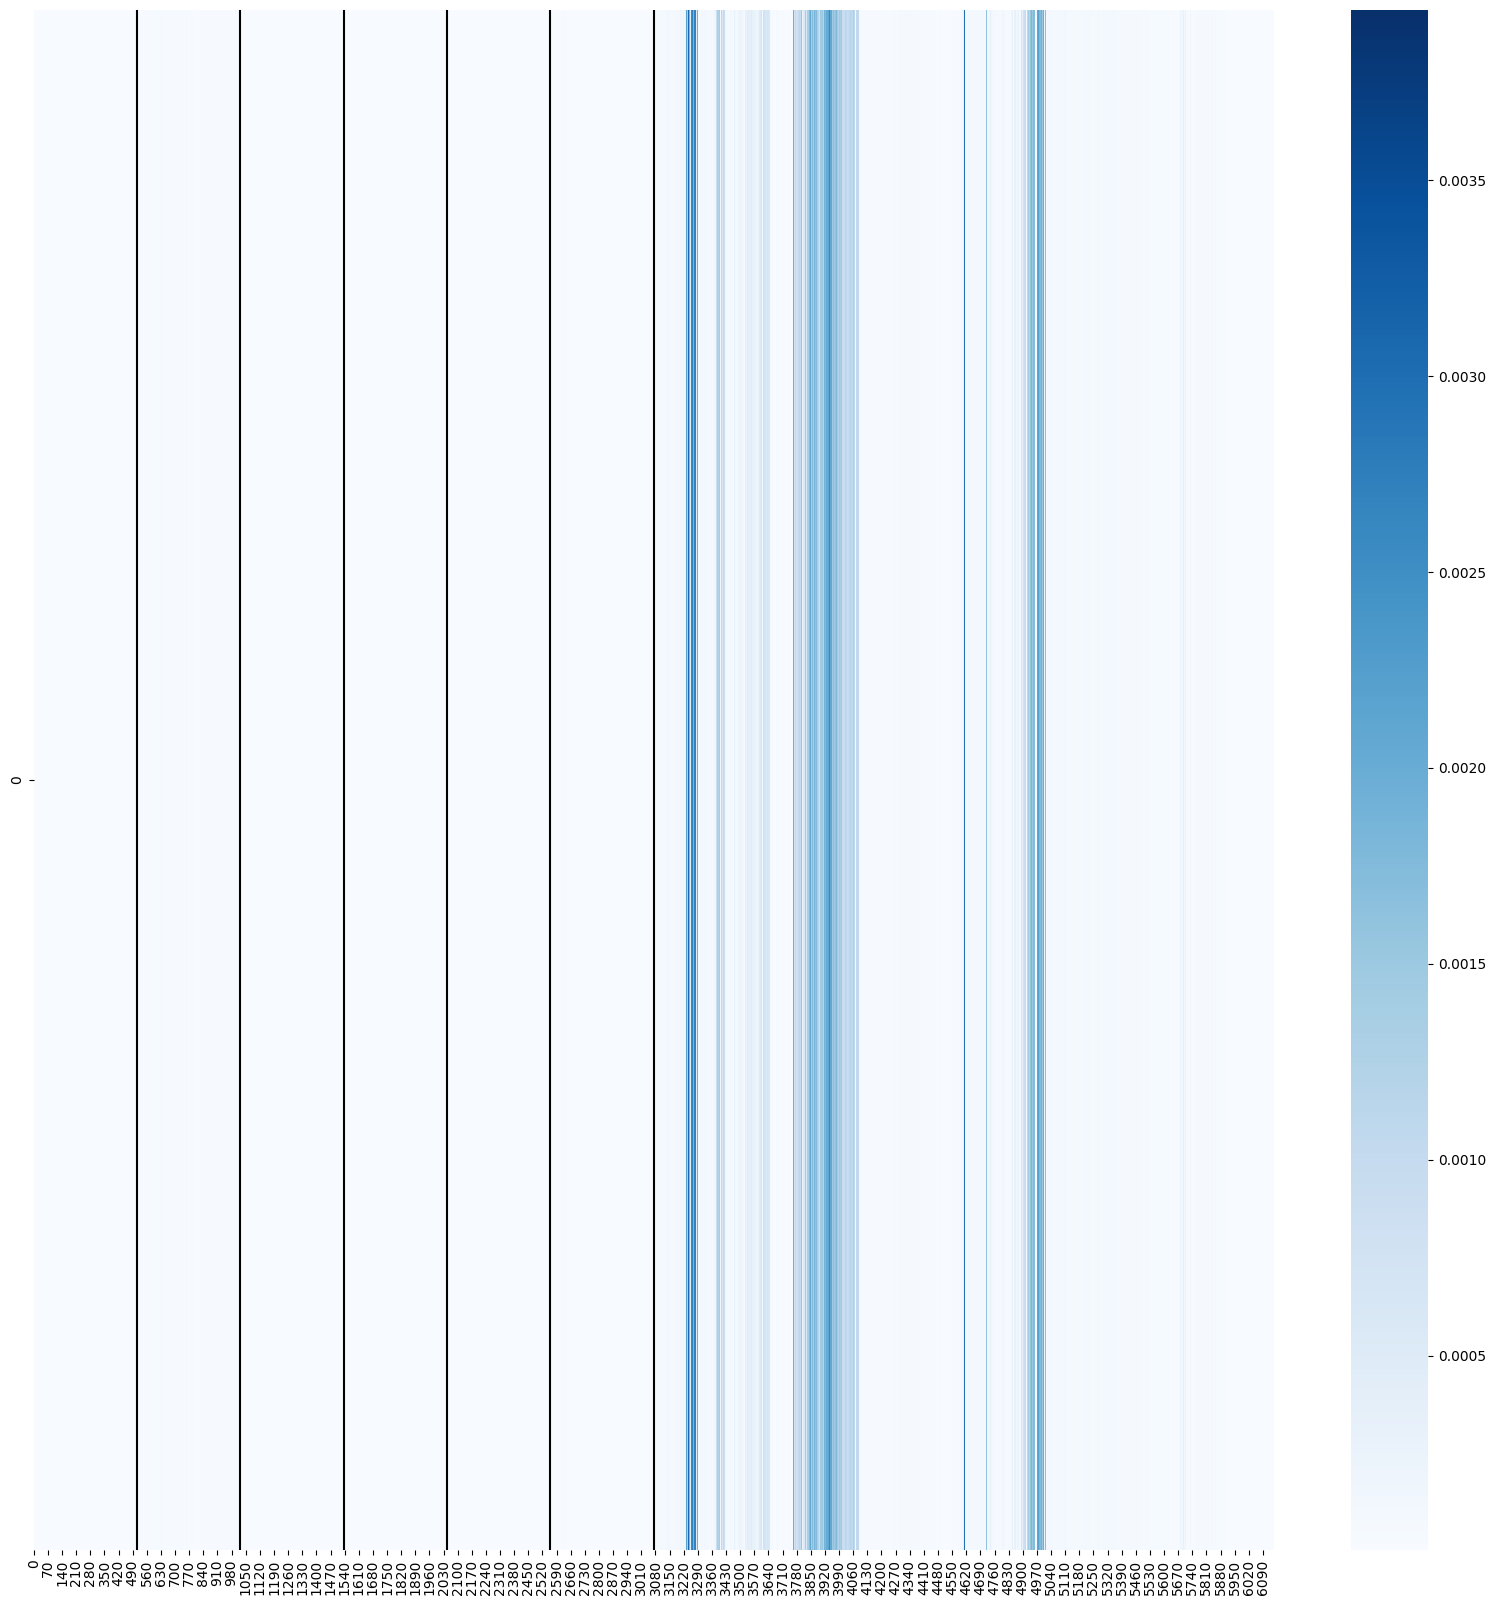

Label 5


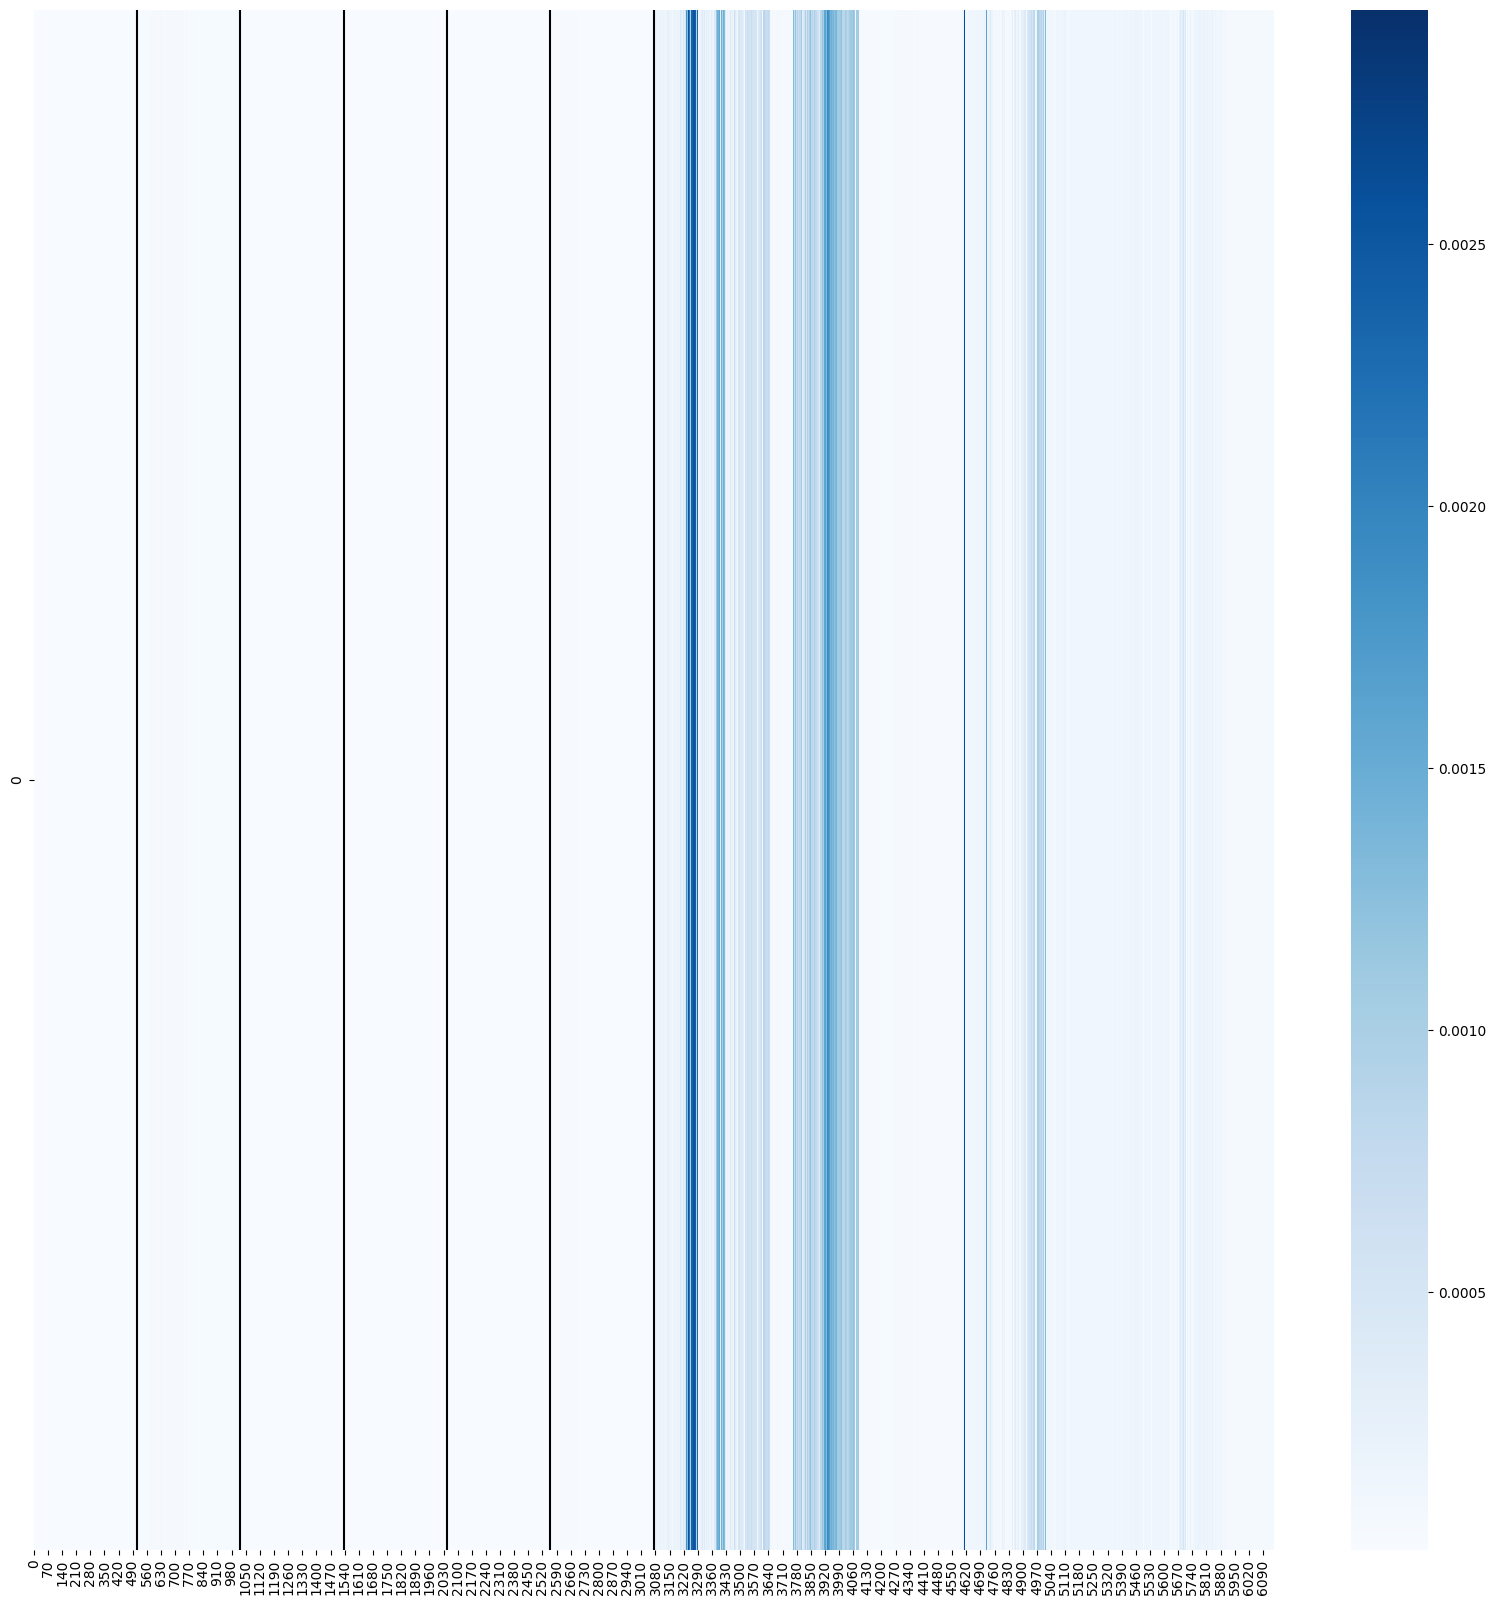

Label 20


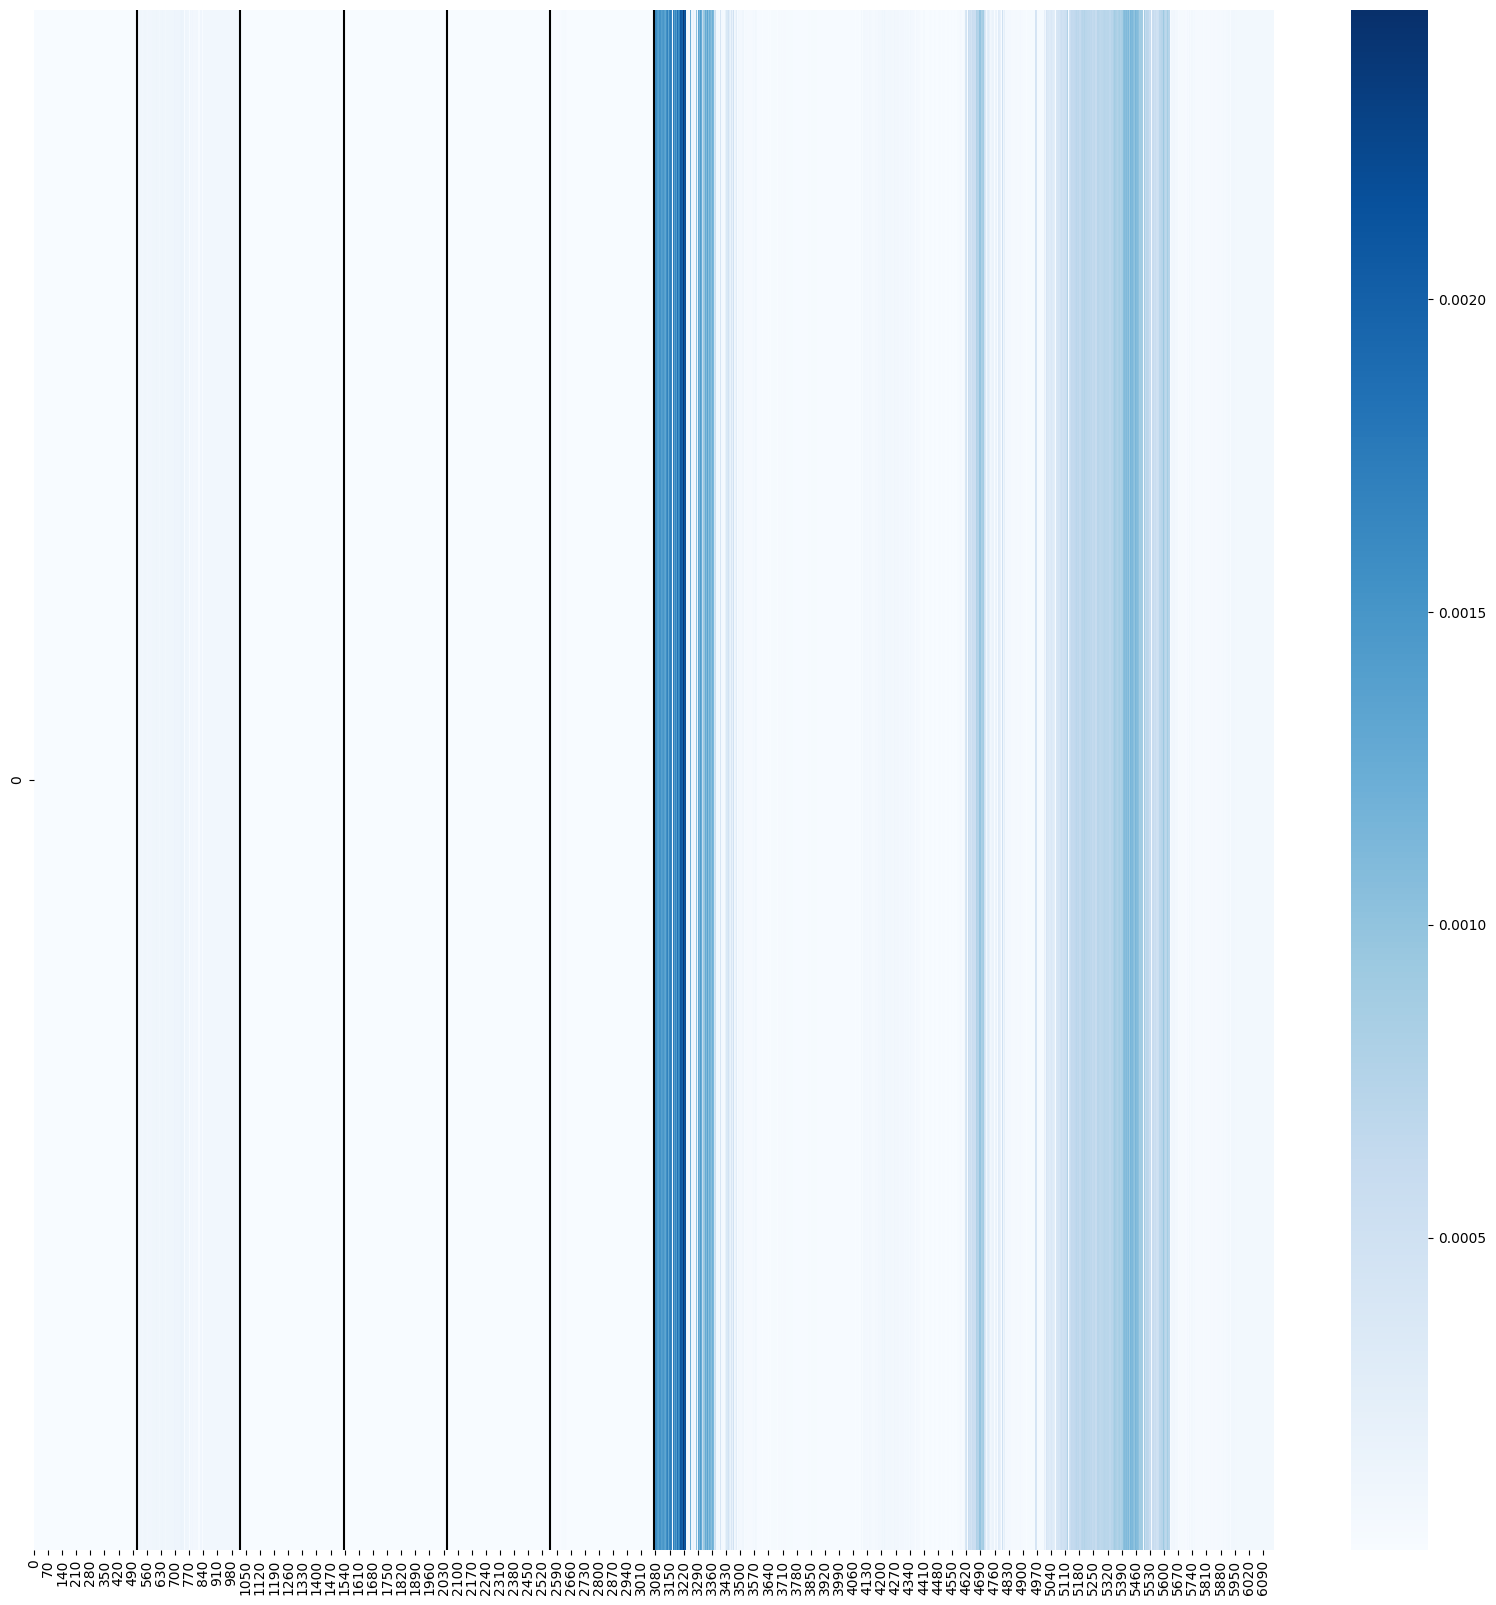

Label 21


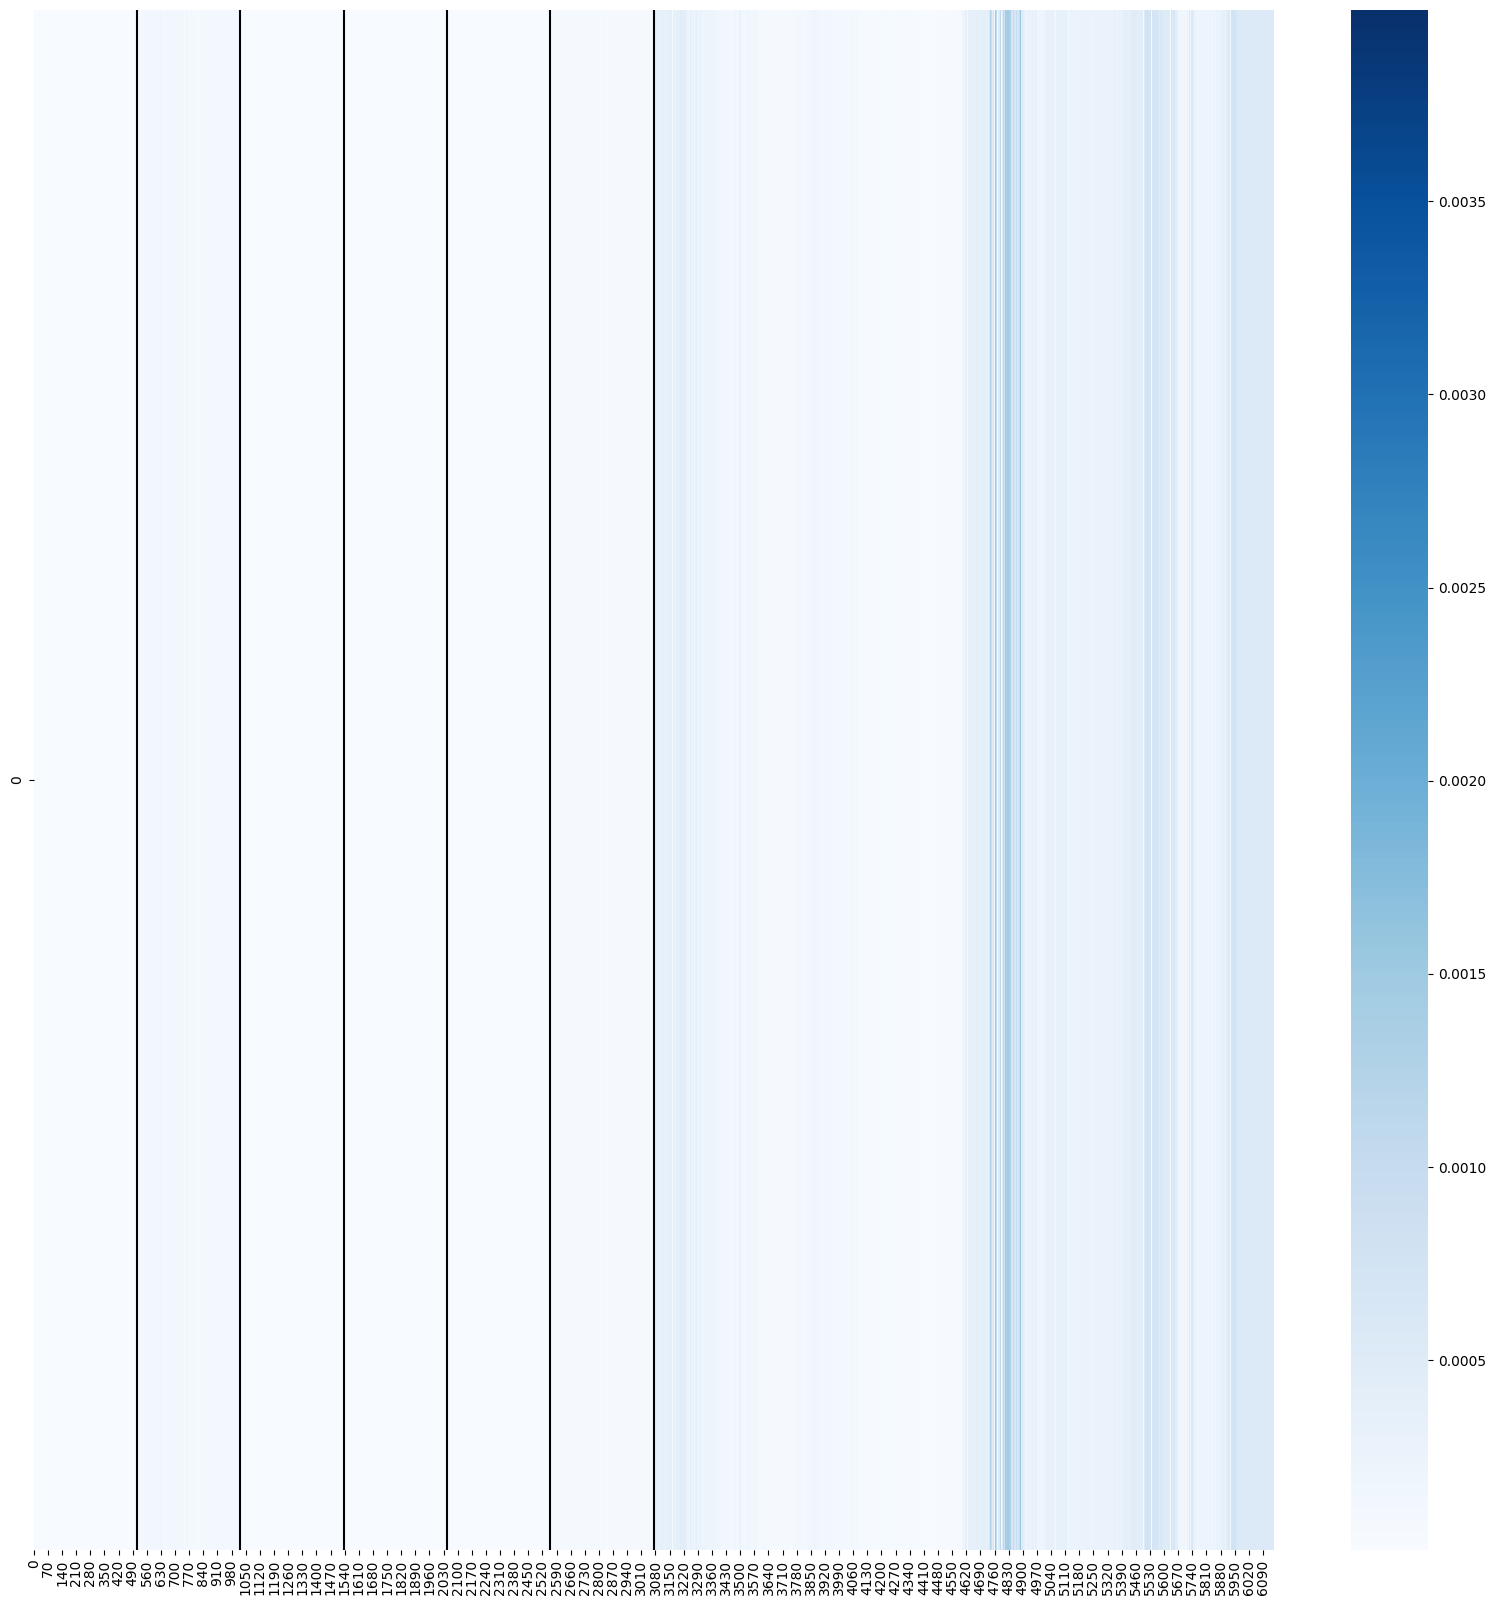

Label 43


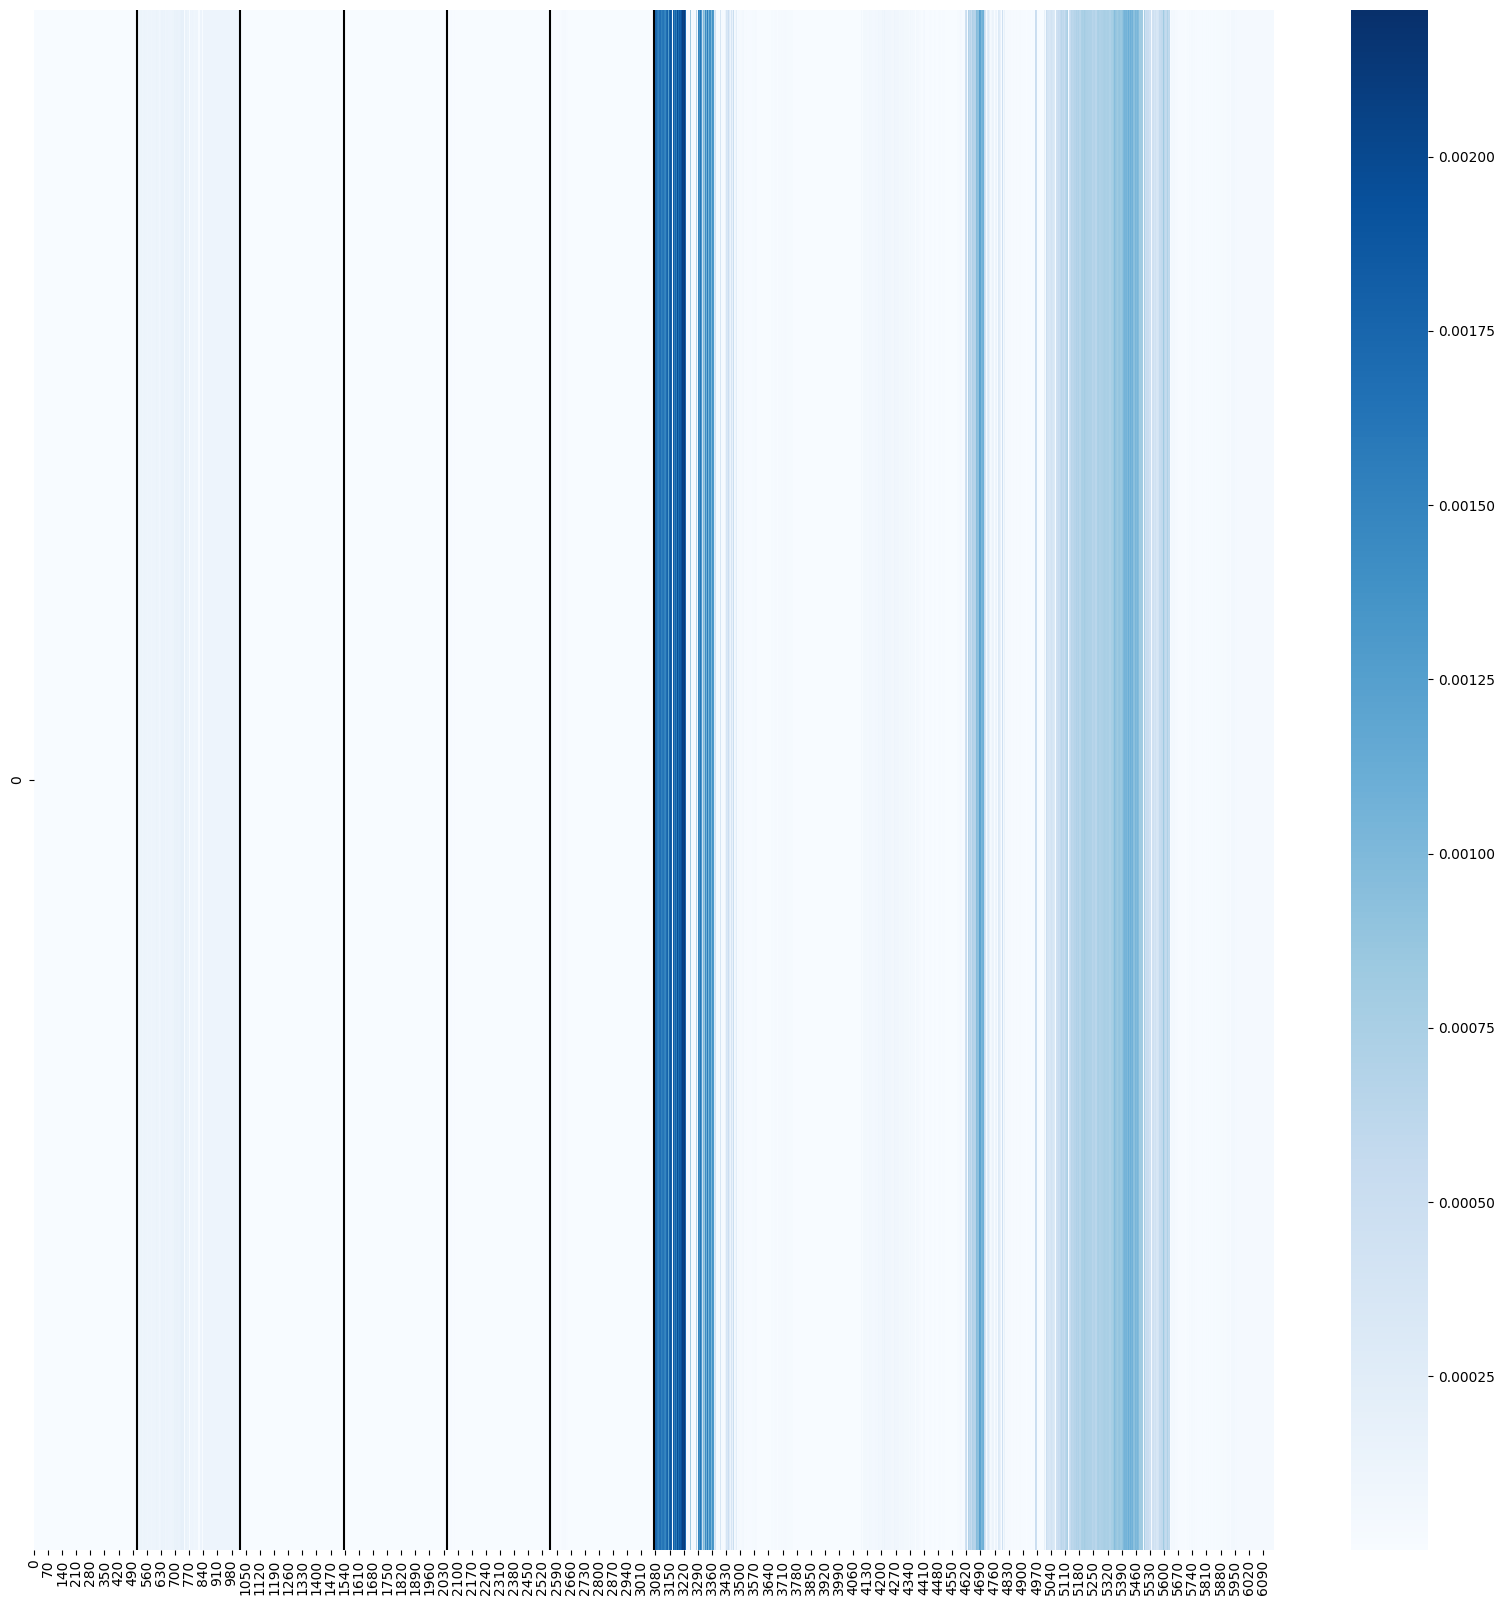

Label 45


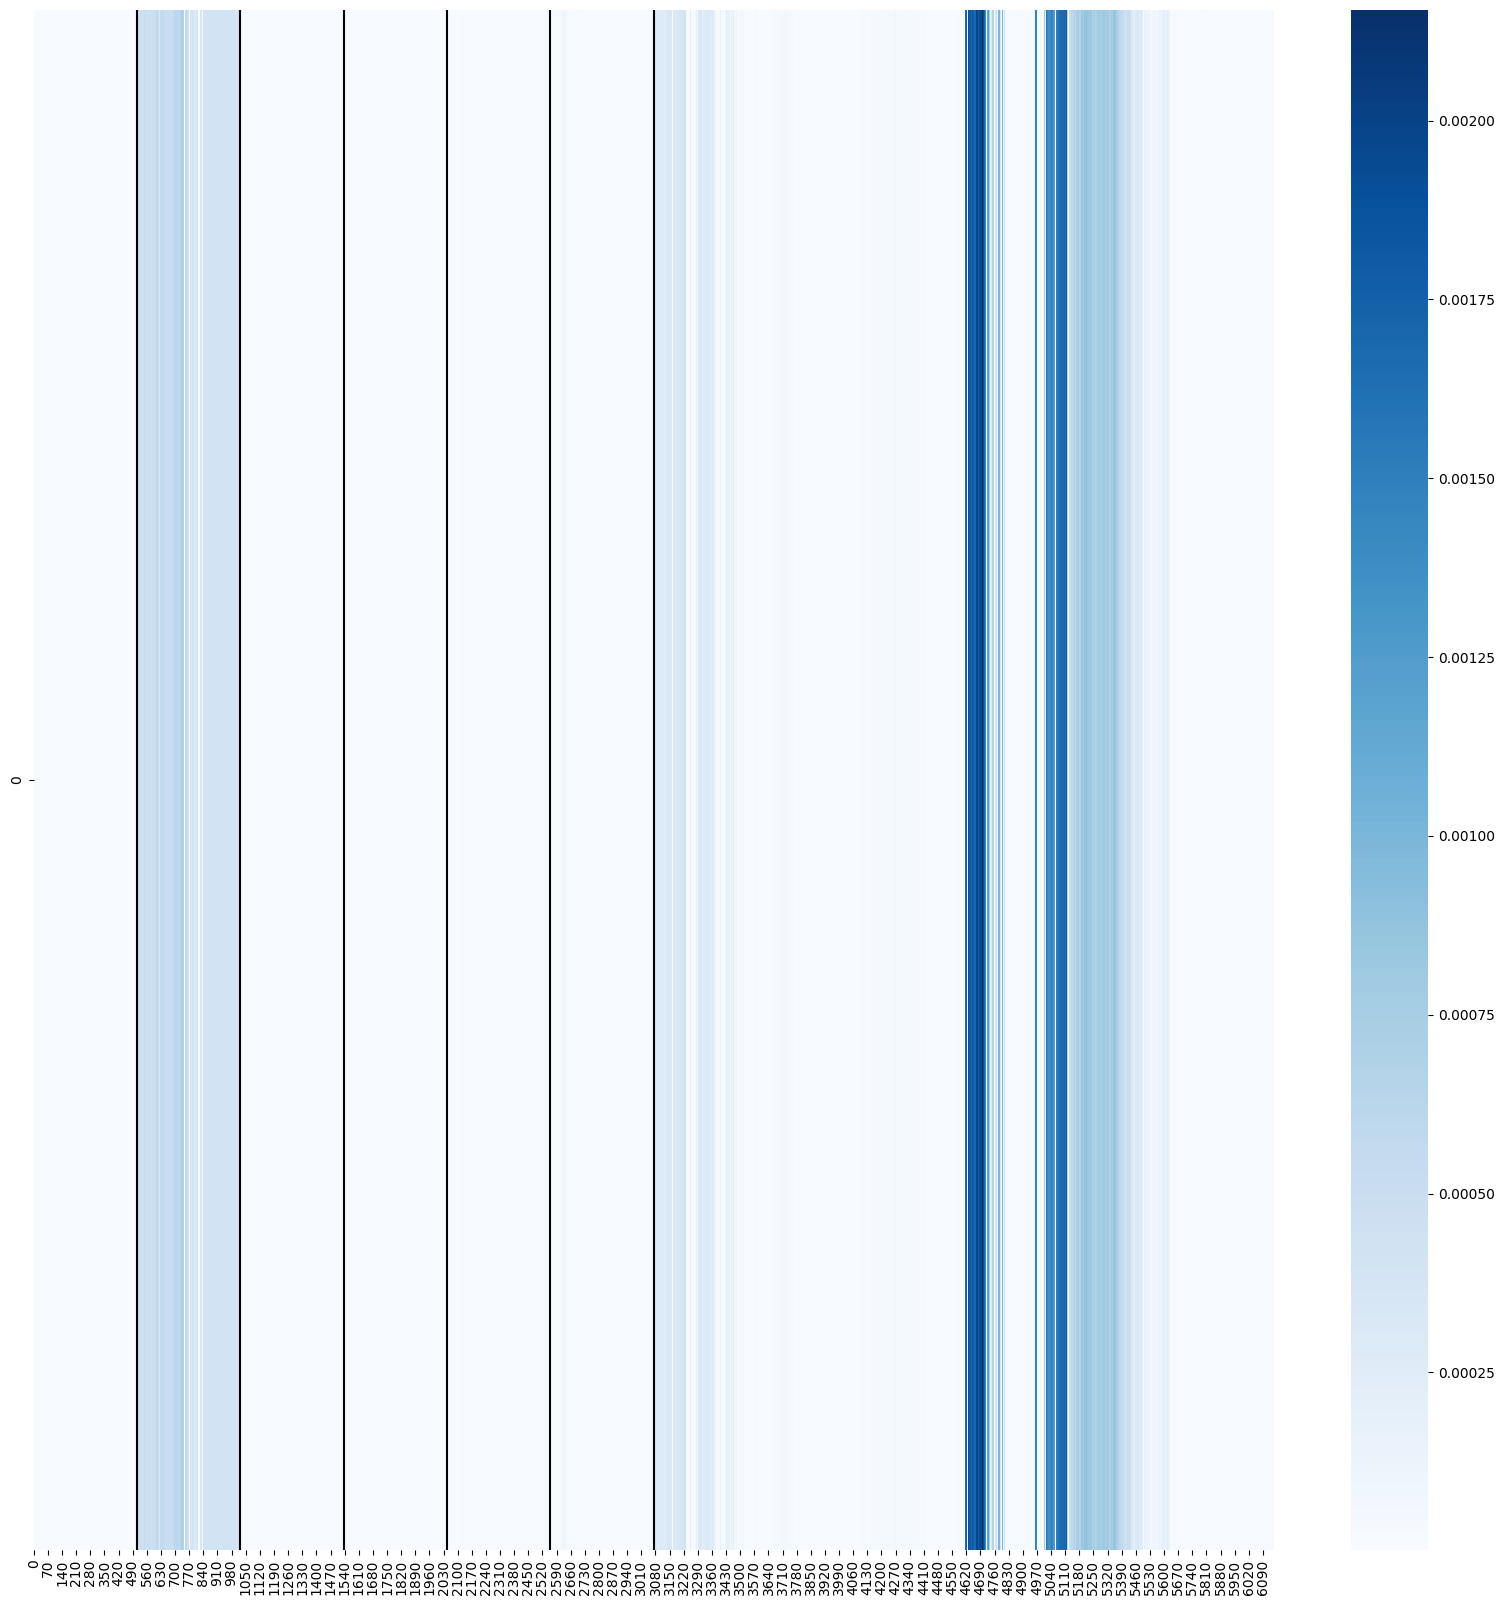

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize a heatmap of attn_output_weights[-1,l,:] for all l in 0,..,49 such that labels[l] == 1
for cutoff in cutoffs.keys():
    print(f"Cutoff {cutoff}")
    cutoff_idx = cutoffs[cutoff]
    for l in range(50):
        if labels[l] == 1:
            print(f"Label {l}")
            plt.figure(figsize=(20, 20))
            attn_weights= attn_output_weights[cutoff_idx, l, :].cpu().detach().numpy().reshape(1, -1)
            # make heatmap value range from the min to the max
            sns.heatmap(
                attn_weights,
                cmap="Blues",
                vmin=attn_weights.min(),
                vmax=attn_weights.max(),
            )
            # show lines between the notesº<
            # which are in seq_ids
            for i in range(1, seq_ids.shape[0]):
                if seq_ids[i-1] != seq_ids[i]:
                    plt.axvline(x=i*512, color="black")


            plt.show()
